# Βαθιά μάθηση στο CIFAR-100

## Εισαγωγή και επισκόπηση του συνόλου δεδομένων

In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals # legacy compatibility

import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# helper functions

# select from from_list elements with index in index_list
def select_from_list(from_list, index_list):
  filtered_list= [from_list[i] for i in index_list]
  return(filtered_list)

# append in filtered_list the index of each element of unfilterd_list if it exists in in target_list
def get_ds_index(unfiliterd_list, target_list):
  index = 0
  filtered_list=[]
  for i_ in unfiliterd_list:
    if i_[0] in target_list:
      filtered_list.append(index)
    index += 1
  return(filtered_list)

# select a url for a unique subset of CIFAR-100 with 20, 40, 60, or 80 classes
def select_classes_number(classes_number = 20):
  cifar100_20_classes_url = "https://pastebin.com/raw/nzE1n98V"
  cifar100_40_classes_url = "https://pastebin.com/raw/zGX4mCNP"
  cifar100_60_classes_url = "https://pastebin.com/raw/nsDTd3Qn"
  cifar100_80_classes_url = "https://pastebin.com/raw/SNbXz700"
  if classes_number == 20:
    return cifar100_20_classes_url
  elif classes_number == 40:
    return cifar100_40_classes_url
  elif classes_number == 60:
    return cifar100_60_classes_url
  elif classes_number == 80:
    return cifar100_80_classes_url
  else:
    return -1

In [ ]:
# load the entire dataset
(x_train_all, y_train_all), (x_test_all, y_test_all) = tf.keras.datasets.cifar100.load_data(label_mode='fine')

In [ ]:
print(x_train_all.shape)

(50000, 32, 32, 3)



Στο επόμενο κελί, αντικαταστήσαμε την τιμή της μεταβλητής `team_seed` με τον αριθμό της ομάδας μας.

In [ ]:
# REPLACE WITH YOUR TEAM NUMBER
team_seed = 79

Στο επόμενο κελί μπορείτε να διαλέξετε το πλήθος των κατηγορίων σας: 20 (default), 40, 60 ή 80.

In [ ]:
# select the number of classes
cifar100_classes_url = select_classes_number()

Δημιουργούμε το μοναδικό dataset της ομάδας μας:

In [ ]:
team_classes = pd.read_csv(cifar100_classes_url, sep=',', header=None)
CIFAR100_LABELS_LIST = pd.read_csv('https://pastebin.com/raw/qgDaNggt', sep=',', header=None).astype(str).values.tolist()[0]

our_index = team_classes.iloc[team_seed,:].values.tolist()
our_classes = select_from_list(CIFAR100_LABELS_LIST, our_index)
train_index = get_ds_index(y_train_all, our_index)
test_index = get_ds_index(y_test_all, our_index)

x_train_ds = np.asarray(select_from_list(x_train_all, train_index))
y_train_ds = np.asarray(select_from_list(y_train_all, train_index))
x_test_ds = np.asarray(select_from_list(x_test_all, test_index))
y_test_ds = np.asarray(select_from_list(y_test_all, test_index))

In [ ]:
# print our classes
print(our_classes)

['apple', ' beetle', ' bottle', ' bridge', ' chimpanzee', ' couch', ' dinosaur', ' dolphin', ' elephant', ' forest', ' girl', ' lamp', ' lion', ' mouse', ' oak_tree', ' orchid', ' possum', ' tulip', ' wardrobe', ' woman']


In [ ]:
CLASSES_NUM=len(our_classes)

In [ ]:
print(x_train_ds[1].shape)

(32, 32, 3)


1500
Train: X=(8500, 32, 32, 3), y=(8500, 1)
Validation: X=(1500, 32, 32, 3), y=(1500, 1)
Test: X=(2000, 32, 32, 3), y=(2000, 1)


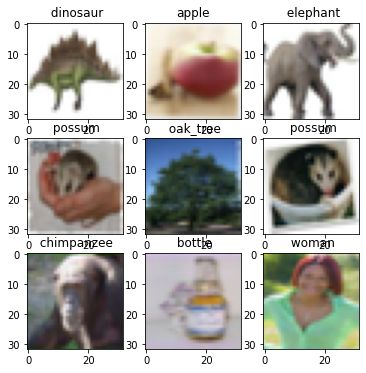

In [ ]:
# get (train) dataset dimensions
data_size, img_rows, img_cols, img_channels = x_train_ds.shape

# set validation set percentage (wrt the training set size)
validation_percentage = 0.15
val_size = round(validation_percentage * data_size)

# Reserve val_size samples for validation and normalize all values
x_val = x_train_ds[-val_size:]/255
y_val = y_train_ds[-val_size:]
x_train = x_train_ds[:-val_size]/255
y_train = y_train_ds[:-val_size]
x_test = x_test_ds/255
y_test = y_test_ds

print(len(x_val))

# summarize loaded dataset
print('Train: X=%s, y=%s' % (x_train.shape, y_train.shape))
print('Validation: X=%s, y=%s' % (x_val.shape, y_val.shape))
print('Test: X=%s, y=%s' % (x_test.shape, y_test.shape))

# get class label from class index
def class_label_from_index(fine_category):
  return(CIFAR100_LABELS_LIST[fine_category.item(0)])

# plot first few images
plt.figure(figsize=(6, 6))
for i in range(9):
	# define subplot
  plt.subplot(330 + 1 + i).set_title(class_label_from_index(y_train[i]))
	# plot raw pixel data
  plt.imshow(x_train[i], cmap=plt.get_cmap('gray'))
  #show the figure
plt.show()

##**TF Records**

In [ ]:
TARGET_SIZE = (82,82,3)

In [ ]:
tfr_directory = "/content/drive/My Drive/NN/Ex3/tfrecords/"

In [ ]:
def _bytes_feature(value):
    """Returns a bytes_list from a string / byte."""
    # If the value is an eager tensor BytesList won't unpack a string from an EagerTensor.
    if isinstance(value, type(tf.constant(0))):
        value = value.numpy() 
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _int64_feature(value):
    """Returns an int64_list from a bool / enum / int / uint."""
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

In [ ]:
def serialize_example(image, label, image_shape):
    feature = {
        "image": _bytes_feature(image),
        "label": _int64_feature(label),
        'height': _int64_feature(image_shape[0]),
        'width': _int64_feature(image_shape[1]),
        'depth': _int64_feature(image_shape[2]),
    }

    example_proto = tf.train.Example(features=tf.train.Features(feature=feature))
    return example_proto.SerializeToString()

In [ ]:
def write_TFR(tfrecord_dir, x, y):
  with tf.io.TFRecordWriter(tfrecord_dir) as writer:
      for img_array, label in zip(x, y):
                
          img_array = tf.image.resize(img_array, (TARGET_SIZE[0], TARGET_SIZE[1]))
          
          img_bytes = tf.io.serialize_tensor(img_array)
          image_shape = img_array.shape
          
          example = serialize_example(img_bytes, label, image_shape)
          writer.write(example)
  return None

In [ ]:
write_TFR(tfr_directory + "train.tfrecords", x_train, y_train)
write_TFR(tfr_directory + "validation.tfrecords", x_val, y_val)
write_TFR(tfr_directory + "test.tfrecords", x_test, y_test)

In [ ]:
def _parse_function(example_proto):
    feature_description = {
        'image': tf.io.FixedLenFeature([], tf.string),
        'label': tf.io.FixedLenFeature([], tf.int64),
        'height': tf.io.FixedLenFeature([], tf.int64),
        'width': tf.io.FixedLenFeature([], tf.int64),
        'depth': tf.io.FixedLenFeature([], tf.int64)
    }
    example = tf.io.parse_single_example(example_proto, feature_description)

    label = example["label"]
    image_shape = TARGET_SIZE

    image = tf.io.parse_tensor(example["image"], float)
    image = tf.reshape(image, image_shape)


    return  image , [label]

In [ ]:
def read_dataset(file):
    dataset = tf.data.TFRecordDataset(file)
    return dataset.map(_parse_function)

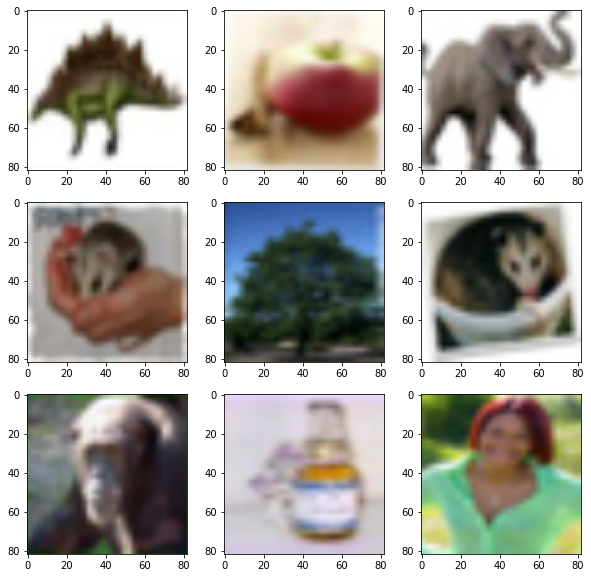

In [ ]:
train_ds_82 = read_dataset(tfr_directory + "train.tfrecords")
validation_ds_82 = read_dataset(tfr_directory + "validation.tfrecords")
test_ds_82 = read_dataset(tfr_directory + "test.tfrecords")

plt.figure(figsize=(10,10))
for i, data in enumerate(train_ds_82.take(9)):
    img = tf.keras.preprocessing.image.array_to_img(data[0])
    plt.subplot(3,3,i+1)
    plt.imshow(img)
plt.show()

## Συναρτήσεις εκπαίδευσης

Θα χρησιμοποιήσουμε την ιδιότητα data prefetch του tf2:

In [ ]:
# we user prefetch https://www.tensorflow.org/api_docs/python/tf/data/Dataset#prefetch 
# see also AUTOTUNE
# the dataset is now "infinite"

BATCH_SIZE = [32,64,128]
AUTOTUNE = tf.data.experimental.AUTOTUNE # https://www.tensorflow.org/guide/data_performance

def _input_fn(ds, BATCH_SIZE):
  ds = ds.shuffle(buffer_size=data_size)
  ds = ds.repeat()
  ds = ds.batch(BATCH_SIZE)
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds


In [ ]:
#Εκπαίδευση μοντέλων για τα διάφορα input data και batch sizes

#INPUT DATA SIZE : (32,32,3)
train_ds = tf.data.Dataset.from_tensor_slices((x_train,y_train))
validation_ds = tf.data.Dataset.from_tensor_slices((x_val,y_val))
test_ds = tf.data.Dataset.from_tensor_slices((x_test,y_test))

### BATCH_SIZE=32
train_ds_bs32 = _input_fn(train_ds, BATCH_SIZE[0]) #PrefetchDataset object
validation_ds_bs32 =_input_fn(validation_ds, BATCH_SIZE[0]) #PrefetchDataset object
test_ds_bs32 =_input_fn(test_ds, BATCH_SIZE[0]) #PrefetchDataset object

### BATCH_SIZE=64
train_ds_bs64 = _input_fn(train_ds, BATCH_SIZE[1]) #PrefetchDataset object
validation_ds_bs64 =_input_fn(validation_ds, BATCH_SIZE[1]) #PrefetchDataset object
test_ds_bs64 =_input_fn(test_ds, BATCH_SIZE[1]) #PrefetchDataset object

### BATCH_SIZE=128
train_ds = _input_fn(train_ds, BATCH_SIZE[2]) #PrefetchDataset object
validation_ds =_input_fn(validation_ds, BATCH_SIZE[2]) #PrefetchDataset object
test_ds =_input_fn(test_ds, BATCH_SIZE[2]) #PrefetchDataset object


#INPUT DATA SIZE : (82,82,3)

### BATCH_SIZE=32
train_ds_is82_bs32 =_input_fn(train_ds_82, BATCH_SIZE[0]) #PrefetchDataset object
validation_ds_is82_bs32 =_input_fn(validation_ds_82, BATCH_SIZE[0]) #PrefetchDataset object
test_ds_is82_bs32 =_input_fn(test_ds_82, BATCH_SIZE[0]) #PrefetchDataset object

### BATCH_SIZE=64
train_ds_is82_bs64 =_input_fn(train_ds_82, BATCH_SIZE[1]) #PrefetchDataset object
validation_ds_is82_bs64 =_input_fn(validation_ds_82, BATCH_SIZE[1]) #PrefetchDataset object
test_ds_is82_bs64 =_input_fn(test_ds_82, BATCH_SIZE[1]) #PrefetchDataset object

### BATCH_SIZE=128

train_ds_82 =_input_fn(train_ds_82, BATCH_SIZE[2]) #PrefetchDataset object
validation_ds_82 =_input_fn(validation_ds_82, BATCH_SIZE[2]) #PrefetchDataset object
test_ds_82 =_input_fn(test_ds_82, BATCH_SIZE[2]) #PrefetchDataset object


In [ ]:
# steps_per_epoch and validation_steps for training and validation: https://www.tensorflow.org/guide/keras/train_and_evaluate
import os
import datetime
def train_model(model, name, size, batch_size, epochs = 10, steps_per_epoch = 2, validation_steps = 1,train_d=train_ds):
  logdir = os.path.join("/content/drive/My Drive/NN/Ex3/Models/logs", name + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
  
  if batch_size==32:
    if size==32:
      train = train_ds_bs32
      val = validation_ds_bs32
    else:
      train = train_ds_is82_bs32
      val = validation_ds_is82_bs32

  elif batch_size==64:
    if size==32:
      train = train_ds_bs64
      val = validation_ds_bs64
    else:
      train = train_ds_is82_bs64
      val = validation_ds_is82_bs64
  else:
    if size==32:
      train = train_ds
      val = validation_ds
    else:
      train = train_ds_82
      val = validation_ds_82


  history = model.fit(train, epochs=epochs, steps_per_epoch=steps_per_epoch, validation_data=val, validation_steps=validation_steps)
  return(history)

In [ ]:
# steps_per_epoch and validation_steps for training and validation: https://www.tensorflow.org/guide/keras/train_and_evaluate

def train_model_TL(model, name, size, epochs = 10, steps_per_epoch = 2, validation_steps = 1):

  logdir = os.path.join("/content/drive/My Drive/ΝΝ/Ex3/Models/logs", name + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
  tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
  early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 10, restore_best_weights=True) 

  if (size==32):
    history = model.fit(train_ds, epochs=epochs, steps_per_epoch=steps_per_epoch, validation_data=validation_ds, validation_steps=validation_steps, callbacks=[tensorboard_callback, early_stopping_callback])
  elif (size == 82):
    history = model.fit(train_ds_82, epochs=epochs, steps_per_epoch=steps_per_epoch, validation_data=validation_ds_82, validation_steps=validation_steps, callbacks=[tensorboard_callback, early_stopping_callback])
  else:
    history = None
  
  return(history)

## Γραφικές παραστάσεις εκπαίδευσης και απόδοση στο σύνολο ελέγχου

In [ ]:
# plot diagnostic learning curves
def summarize_diagnostics(history):
	plt.figure(figsize=(8, 8))
	plt.suptitle('Training Curves')
	# plot loss
	plt.subplot(211)
	plt.title('Cross Entropy Loss')
	plt.plot(history.history['loss'], color='blue', label='train')
	plt.plot(history.history['val_loss'], color='orange', label='val')
	plt.legend(loc='upper right')
	# plot accuracy
	plt.subplot(212)
	plt.title('Classification Accuracy')
	plt.plot(history.history['accuracy'], color='blue', label='train')
	plt.plot(history.history['val_accuracy'], color='orange', label='val')
	plt.legend(loc='lower right')
	return plt
 
# print test set evaluation metrics
def model_evaluation(model, evaluation_steps, size):
	print('\nTest set evaluation metrics')
	if (size==32):
		loss0,accuracy0 = model.evaluate(test_ds, steps = evaluation_steps)
	elif (size==82):
		loss0,accuracy0 = model.evaluate(test_ds_82, steps = evaluation_steps)
	else:
		loss0,accuracy0 = None, None
	print("loss: {:.2f}".format(loss0))
	print("accuracy: {:.2f}".format(accuracy0))

def model_report(model, history, size, evaluation_steps = 10):
	plt = summarize_diagnostics(history)
	plt.show()
	model_evaluation(model, evaluation_steps, size)

## Μοντέλα δικτύων


### Μοντέλα "from scratch"



####**Simple Model**

In [ ]:
# a simple CNN https://www.tensorflow.org/tutorials/images/cnn

def init_simple_model(summary):
  model = models.Sequential()
  model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32,32,3)))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(64, (3, 3), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(64, (3, 3), activation='relu'))
  model.add(layers.Flatten())
  model.add(layers.Dense(64, activation='relu'))
  model.add(layers.Dense(100, activation='softmax'))
  
  model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.0001), loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=["accuracy"])
  if summary: 
    model.summary()
  return model

In [ ]:
SIMPLE_MODEL_32 = init_simple_model(summary = True)
start_time = time.time()
SIMPLE_MODEL_32_history = train_model(SIMPLE_MODEL_32, 'simple_model_32',32, 32, 50, 30, 5)
duration = time.time() - start_time
print('Training lasted {} seconds'.format(duration))

Model: "sequential_47"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_161 (Conv2D)          (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d_104 (MaxPoolin (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_162 (Conv2D)          (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_105 (MaxPoolin (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_163 (Conv2D)          (None, 4, 4, 64)          36928     
_________________________________________________________________
flatten_47 (Flatten)         (None, 1024)              0         
_________________________________________________________________
dense_114 (Dense)            (None, 64)              

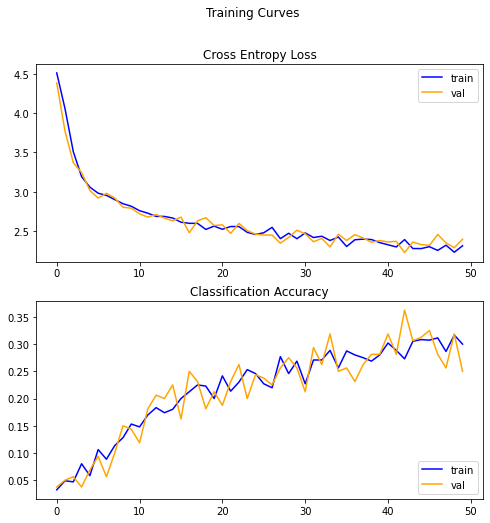


Test set evaluation metrics
10/10 [==============================] - 0s 4ms/step - loss: 2.2716 - accuracy: 0.3070
loss: 2.27
accuracy: 0.31


In [ ]:
SIMPLE_MODEL_32.save("/content/drive/My Drive/NN/Ex3/Models/SIMPLE_MODEL_32x32.h5")
model_report (SIMPLE_MODEL_32,SIMPLE_MODEL_32_history, 32)

Αρχικά θα δοκιμάσουμε κάποιες τεχνικές βελτιστοποίησης στο αρχικό CNN model που δίνεται παραπάνω.

#####Early Stopping

In [ ]:
#Early Stopping
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
def init_simple_model_es(summary):
  model = models.Sequential()
  model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32,32,3)))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(64, (3, 3), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(64, (3, 3), activation='relu'))
  model.add(layers.Flatten())
  model.add(layers.Dense(64, activation='relu'))
  model.add(layers.Dense(100, activation='softmax'))
  
  model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.0001), loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=["accuracy"])
  if summary: 
    model.summary()
  #Καθορισμός παραμέτρων Early Stopping
  es = EarlyStopping(monitor='val_loss', min_delta=0.0001, mode='auto', verbose=1, patience=3, restore_best_weights=True)
  #Eκπαίσευση του μοντέλου
  global SIMPLE_MODEL_32es_history
  SIMPLE_MODEL_32es_history = model.fit(train_ds, callbacks=[es], epochs=50, steps_per_epoch=30, validation_data=validation_ds, validation_steps=5)
  return model

In [ ]:
start_time = time.time()
SIMPLE_MODEL_32es = init_simple_model_es(summary = True)
duration = time.time() - start_time
print('Training lasted {} seconds'.format(duration))

Model: "sequential_48"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_164 (Conv2D)          (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d_106 (MaxPoolin (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_165 (Conv2D)          (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_107 (MaxPoolin (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_166 (Conv2D)          (None, 4, 4, 64)          36928     
_________________________________________________________________
flatten_48 (Flatten)         (None, 1024)              0         
_________________________________________________________________
dense_116 (Dense)            (None, 64)              

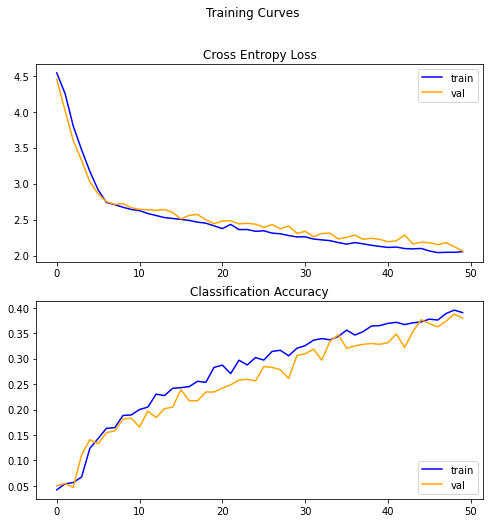


Test set evaluation metrics
10/10 [==============================] - 0s 4ms/step - loss: 2.0027 - accuracy: 0.4016
loss: 2.00
accuracy: 0.40


In [ ]:
SIMPLE_MODEL_32es.save("/content/drive/My Drive/NN/Ex3/Models/SIMPLE_MODEL_es_32x32.h5")
model_report (SIMPLE_MODEL_32es, SIMPLE_MODEL_32es_history, 32)

#####Reduce Learning Rate

In [ ]:
#Reduce Learning Rate
def init_simple_model_lr(summary):
  model = models.Sequential()
  model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32,32,3)))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(64, (3, 3), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(64, (3, 3), activation='relu'))
  model.add(layers.Flatten())
  model.add(layers.Dense(64, activation='relu'))
  model.add(layers.Dense(100, activation='softmax'))
  
  model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.0001), loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=["accuracy"])
  if summary: 
    model.summary()
  #Καθορισμός παραμέτρων Reduce Learning Rate
  reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)
  #Eκπαίσευση του μοντέλου
  global SIMPLE_MODEL_32lr_history
  SIMPLE_MODEL_32lr_history = model.fit(train_ds, callbacks=[reduce_lr], epochs=50, steps_per_epoch=30, validation_data=validation_ds, validation_steps=5)
  return model

In [ ]:
start_time = time.time()
SIMPLE_MODEL_32lr = init_simple_model_lr(summary = True)
duration = time.time() - start_time
print('Training lasted {} seconds'.format(duration))

Model: "sequential_49"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_167 (Conv2D)          (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d_108 (MaxPoolin (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_168 (Conv2D)          (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_109 (MaxPoolin (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_169 (Conv2D)          (None, 4, 4, 64)          36928     
_________________________________________________________________
flatten_49 (Flatten)         (None, 1024)              0         
_________________________________________________________________
dense_118 (Dense)            (None, 64)              

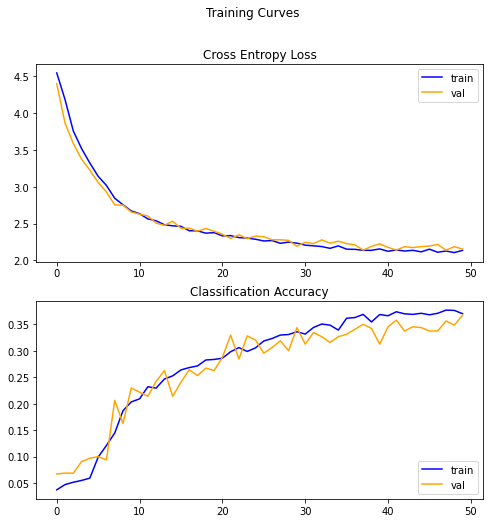


Test set evaluation metrics
10/10 [==============================] - 0s 4ms/step - loss: 2.1297 - accuracy: 0.3664
loss: 2.13
accuracy: 0.37


In [ ]:
SIMPLE_MODEL_32lr.save("/content/drive/My Drive/NN/Ex3/Models/SIMPLE_MODEL_lr_32x32.h5")
model_report (SIMPLE_MODEL_32lr, SIMPLE_MODEL_32lr_history, 32)

#####Dropout

In [ ]:
#Dropout
def init_simple_model_d(summary):
  model = models.Sequential()
  model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32,32,3)))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(64, (3, 3), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(64, (3, 3), activation='relu'))
  model.add(layers.Flatten())
  model.add(layers.Dropout(rate=0.3))
  model.add(layers.Dense(64, activation='relu'))
  model.add(layers.Dense(100, activation='softmax'))
  
  model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.0001), loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=["accuracy"])
  if summary: 
    model.summary()
  return model

In [ ]:
SIMPLE_MODEL_32d = init_simple_model_d(summary = True)
start_time = time.time()
SIMPLE_MODEL_32d_history = train_model(SIMPLE_MODEL_32d, 'simple_model_32d', 32, 32, 50, 30, 5)
duration = time.time() - start_time
print('Training lasted {} seconds'.format(duration))

Model: "sequential_50"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_170 (Conv2D)          (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d_110 (MaxPoolin (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_171 (Conv2D)          (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_111 (MaxPoolin (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_172 (Conv2D)          (None, 4, 4, 64)          36928     
_________________________________________________________________
flatten_50 (Flatten)         (None, 1024)              0         
_________________________________________________________________
dropout_55 (Dropout)         (None, 1024)            

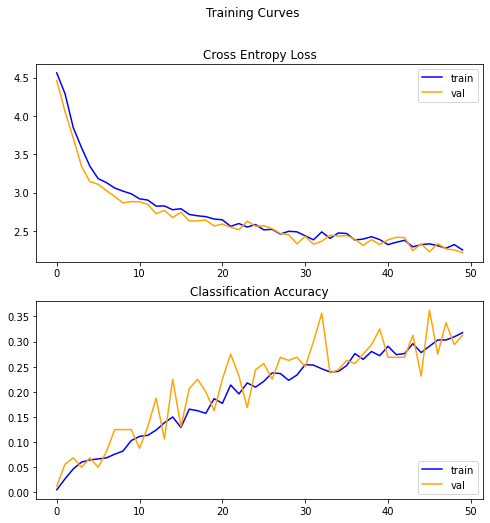


Test set evaluation metrics
10/10 [==============================] - 0s 5ms/step - loss: 2.1939 - accuracy: 0.3617
loss: 2.19
accuracy: 0.36


In [ ]:
SIMPLE_MODEL_32d.save("/content/drive/My Drive/NN/Ex3/Models/SIMPLE_MODEL_d_32x32.h5")
model_report (SIMPLE_MODEL_32d, SIMPLE_MODEL_32d_history, 32)

#####Data Augmentation

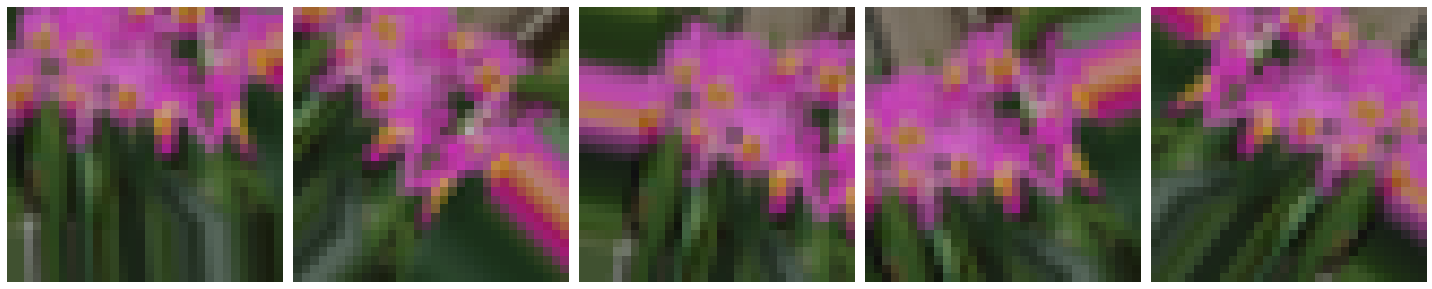

In [ ]:
#DataAugmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#Συνάρτηση εμφάνισης των εικόνων
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,30))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()
#Καθορισμός παραμέτρων και τιμών για τις επιπλέον εικόνες που θα παραχθούν από τον generator
image_gen = ImageDataGenerator(
                  rotation_range=45,
                  width_shift_range=.20,
                  height_shift_range=.20,
                  horizontal_flip=True,
                  )
#Καθορισμός παραμέτρων εκπαίδευσης με βάση τα νέα δεδομένα
#Με βάση το train_image_gen θα γίνει αργότερα η εκπαίδευση των μοντέλων μας
train_ds_image_gen=image_gen.flow(
    x=x_train.copy(), y=y_train.copy(), batch_size=BATCH_SIZE[0], shuffle=True
)

augmented_images = [train_ds_image_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

train_ds_image_gen = train_ds.shuffle(data_size).repeat().batch(BATCH_SIZE[0]).prefetch(tf.data.experimental.AUTOTUNE)

In [ ]:
SIMPLE_MODEL_32da = init_simple_model(summary = True)
start_time = time.time()
SIMPLE_MODEL_32da_history = train_model(SIMPLE_MODEL_32da, 'simple_model_32_da',32, 32, 50, 30, 5,train_ds_image_gen)
duration = time.time() - start_time
print('Training lasted {} seconds'.format(duration))

Model: "sequential_51"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_173 (Conv2D)          (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d_112 (MaxPoolin (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_174 (Conv2D)          (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_113 (MaxPoolin (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_175 (Conv2D)          (None, 4, 4, 64)          36928     
_________________________________________________________________
flatten_51 (Flatten)         (None, 1024)              0         
_________________________________________________________________
dense_122 (Dense)            (None, 64)              

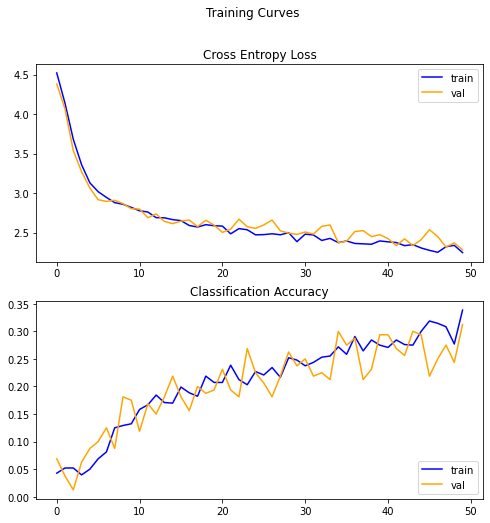


Test set evaluation metrics
10/10 [==============================] - 0s 6ms/step - loss: 2.2442 - accuracy: 0.3227
loss: 2.24
accuracy: 0.32


In [ ]:
SIMPLE_MODEL_32da.save("/content/drive/My Drive/NN/Ex3/Models/SIMPLE_MODEL_da_32x32.h5")
model_report (SIMPLE_MODEL_32da, SIMPLE_MODEL_32da_history, 32)

#####Resize Input

In [ ]:
#Resize input
def init_simple_model82(summary):
  model = models.Sequential()
  model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(82,82,3)))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(64, (3, 3), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(64, (3, 3), activation='relu'))
  model.add(layers.Flatten())
  model.add(layers.Dense(64, activation='relu'))
  model.add(layers.Dense(100, activation='softmax'))
  
  model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.0001), loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=["accuracy"])
  if summary: 
    model.summary()
  return model

In [ ]:
SIMPLE_MODEL_82 = init_simple_model82(summary = True)
start_time = time.time()
SIMPLE_MODEL_82_history = train_model(SIMPLE_MODEL_82, 'simple_model_82',82, 32, 50, 30, 5)
duration = time.time() - start_time
print('Training lasted {} seconds'.format(duration))

Model: "sequential_52"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_176 (Conv2D)          (None, 80, 80, 32)        896       
_________________________________________________________________
max_pooling2d_114 (MaxPoolin (None, 40, 40, 32)        0         
_________________________________________________________________
conv2d_177 (Conv2D)          (None, 38, 38, 64)        18496     
_________________________________________________________________
max_pooling2d_115 (MaxPoolin (None, 19, 19, 64)        0         
_________________________________________________________________
conv2d_178 (Conv2D)          (None, 17, 17, 64)        36928     
_________________________________________________________________
flatten_52 (Flatten)         (None, 18496)             0         
_________________________________________________________________
dense_124 (Dense)            (None, 64)              

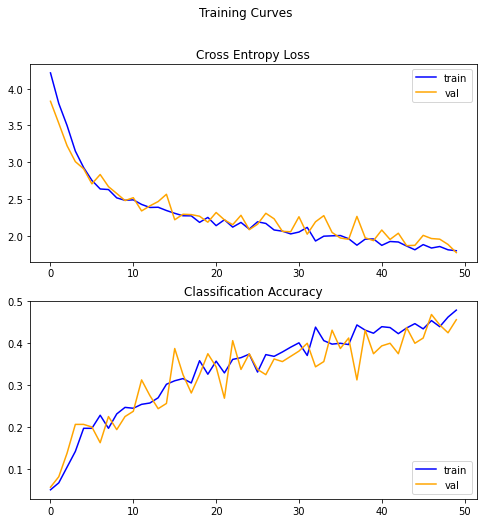


Test set evaluation metrics
10/10 [==============================] - 2s 39ms/step - loss: 1.8725 - accuracy: 0.4453
loss: 1.87
accuracy: 0.45


In [ ]:
SIMPLE_MODEL_82.save("/content/drive/My Drive/NN/Ex3/Models/SIMPLE_MODEL_64x64.h5")
model_report (SIMPLE_MODEL_82, SIMPLE_MODEL_82_history, 82)

#####Adagrad optimizer

In [ ]:
#Different Optimizers
#Adagrad
def init_simple_model_op2(summary):
  model = models.Sequential()
  model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32,32,3)))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(64, (3, 3), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(64, (3, 3), activation='relu'))
  model.add(layers.Flatten())
  model.add(layers.Dense(64, activation='relu'))
  model.add(layers.Dense(100, activation='softmax'))
  
  model.compile(optimizer=tf.optimizers.Adagrad(learning_rate=0.0001), loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=["accuracy"])
  if summary: 
    model.summary()
  return model


In [ ]:
SIMPLE_MODEL_32_op2 = init_simple_model_op2(summary = True)
start_time = time.time()
SIMPLE_MODEL_32_op2_history = train_model(SIMPLE_MODEL_32_op2, 'simple_model_32_op2',32, 32, 50, 30, 5)
duration = time.time() - start_time
print('Training lasted {} seconds'.format(duration))

Model: "sequential_53"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_179 (Conv2D)          (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d_116 (MaxPoolin (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_180 (Conv2D)          (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_117 (MaxPoolin (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_181 (Conv2D)          (None, 4, 4, 64)          36928     
_________________________________________________________________
flatten_53 (Flatten)         (None, 1024)              0         
_________________________________________________________________
dense_126 (Dense)            (None, 64)              

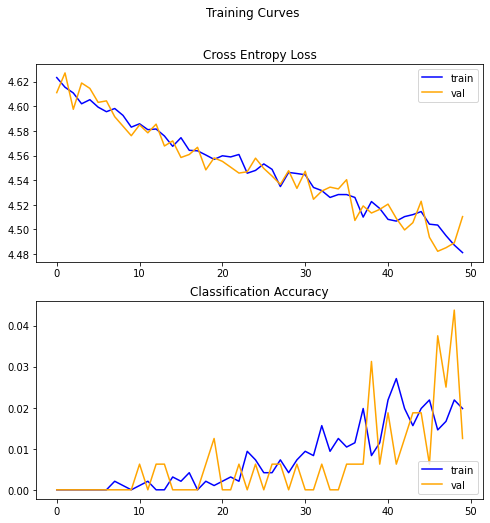


Test set evaluation metrics
10/10 [==============================] - 0s 4ms/step - loss: 4.4832 - accuracy: 0.0289
loss: 4.48
accuracy: 0.03


In [ ]:
SIMPLE_MODEL_32_op2.save("/content/drive/My Drive/NN/Ex3/Models/SIMPLE_MODEL_op2_32x32.h5")
model_report (SIMPLE_MODEL_32_op2,SIMPLE_MODEL_32_op2_history, 32)

#####RMSprop optimizer

In [ ]:
#RMSprop
def init_simple_model_op3(summary):
  model = models.Sequential()
  model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32,32,3)))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(64, (3, 3), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(64, (3, 3), activation='relu'))
  model.add(layers.Flatten())
  model.add(layers.Dense(64, activation='relu'))
  model.add(layers.Dense(100, activation='softmax'))
  
  model.compile(optimizer=tf.optimizers.RMSprop(learning_rate=0.0001), loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=["accuracy"])
  if summary: 
    model.summary()
  return model


In [ ]:
SIMPLE_MODEL_32_op3 = init_simple_model_op3(summary = True)
start_time = time.time()
SIMPLE_MODEL_32_op3_history = train_model(SIMPLE_MODEL_32_op3, 'simple_model_32_op3',32, 32, 50, 30, 5)
duration = time.time() - start_time
print('Training lasted {} seconds'.format(duration))

Model: "sequential_54"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_182 (Conv2D)          (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d_118 (MaxPoolin (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_183 (Conv2D)          (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_119 (MaxPoolin (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_184 (Conv2D)          (None, 4, 4, 64)          36928     
_________________________________________________________________
flatten_54 (Flatten)         (None, 1024)              0         
_________________________________________________________________
dense_128 (Dense)            (None, 64)              

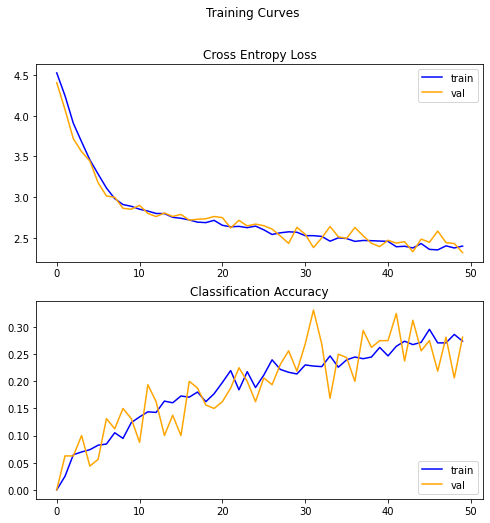


Test set evaluation metrics
10/10 [==============================] - 0s 4ms/step - loss: 2.3461 - accuracy: 0.2844
loss: 2.35
accuracy: 0.28


In [ ]:
SIMPLE_MODEL_32_op3.save("/content/drive/My Drive/NN/Ex3/Models/SIMPLE_MODEL_op3_32x32.h5")
model_report (SIMPLE_MODEL_32_op3,SIMPLE_MODEL_32_op3_history, 32)

#####Δοκιμή διαφορετικών batch sizes

In [ ]:
#Batch Size
#Batch_size=64

SIMPLE_MODEL_32_bs64 = init_simple_model(summary = True)
start_time = time.time()
SIMPLE_MODEL_32_bs64_history = train_model(SIMPLE_MODEL_32_bs64, 'simple_model_bs64',32, 64, 50, 30, 5)
duration = time.time() - start_time
print('Training lasted {} seconds'.format(duration))

Model: "sequential_55"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_185 (Conv2D)          (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d_120 (MaxPoolin (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_186 (Conv2D)          (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_121 (MaxPoolin (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_187 (Conv2D)          (None, 4, 4, 64)          36928     
_________________________________________________________________
flatten_55 (Flatten)         (None, 1024)              0         
_________________________________________________________________
dense_130 (Dense)            (None, 64)              

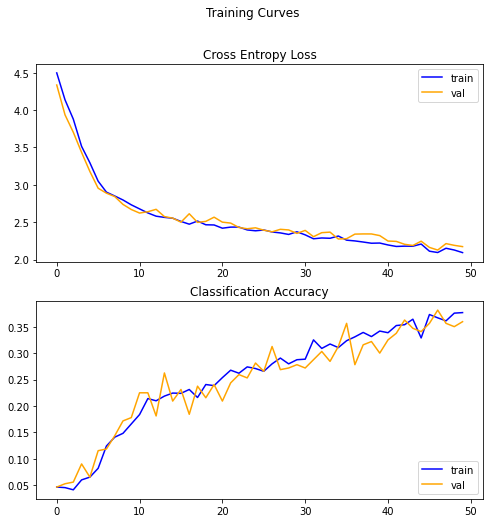


Test set evaluation metrics
10/10 [==============================] - 0s 4ms/step - loss: 2.1477 - accuracy: 0.3547
loss: 2.15
accuracy: 0.35


In [ ]:
SIMPLE_MODEL_32_bs64.save("/content/drive/My Drive/NN/Ex3/Models/SIMPLE_MODEL_bs64_32x32.h5")
model_report (SIMPLE_MODEL_32_bs64,SIMPLE_MODEL_32_bs64_history, 32)

In [ ]:
SIMPLE_MODEL_32_bs128 = init_simple_model(summary = True)
start_time = time.time()
SIMPLE_MODEL_32_bs128_history = train_model(SIMPLE_MODEL_32_bs128, 'simple_model_bs128',32, 128, 50, 30, 5)
duration = time.time() - start_time
print('Training lasted {} seconds'.format(duration))

Model: "sequential_56"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_188 (Conv2D)          (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d_122 (MaxPoolin (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_189 (Conv2D)          (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_123 (MaxPoolin (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_190 (Conv2D)          (None, 4, 4, 64)          36928     
_________________________________________________________________
flatten_56 (Flatten)         (None, 1024)              0         
_________________________________________________________________
dense_132 (Dense)            (None, 64)              

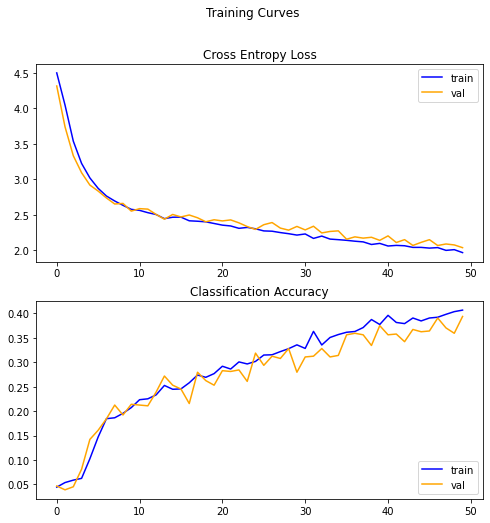


Test set evaluation metrics
10/10 [==============================] - 0s 4ms/step - loss: 1.9802 - accuracy: 0.4031
loss: 1.98
accuracy: 0.40


In [ ]:
SIMPLE_MODEL_32_bs128.save("/content/drive/My Drive/NN/Ex3/Models/SIMPLE_MODEL_bs128_32x32.h5")
model_report (SIMPLE_MODEL_32_bs128,SIMPLE_MODEL_32_bs128_history, 32)

####**First Model**

Το μοντέλο αποτελείται από:

1st Block
```
- Convolutional Layer
- Maxpooling Layer
```
2nd Block
```
- Convolutional Layer
- Maxpooling Layer
```
3rd Block
```
- Convolutional Layer
```
4th Block
```
- Convolutional Layer
```
Fully Connected Layers
```
- Dense layer
- Dropout layer
- Dense layer

In [ ]:
def init_first_model(summary):
  model = models.Sequential()
  model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(64, (3, 3), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(64, (3, 3), activation='relu'))
  model.add(layers.Conv2D(64, (3, 3), activation='relu'))
  model.add(layers.Flatten())
  model.add(layers.Dense(64, activation='relu'))
  model.add(layers.Dropout(rate=0.5))
  model.add(layers.Dense(100, activation='softmax'))
  
  model.compile(optimizer=tf.optimizers.Adam(), loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=["accuracy"])
  if summary: 
    model.summary()
  return model

In [ ]:
FIRST_MODEL_32 = init_first_model(summary = True)
start_time = time.time()

FIRST_MODEL_32_history = train_model(FIRST_MODEL_32, 'first_model_32',32, 32, 100, 30, 5)
duration = time.time() - start_time
print('Training lasted {} seconds'.format(duration))

Model: "sequential_57"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_191 (Conv2D)          (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d_124 (MaxPoolin (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_192 (Conv2D)          (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_125 (MaxPoolin (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_193 (Conv2D)          (None, 4, 4, 64)          36928     
_________________________________________________________________
conv2d_194 (Conv2D)          (None, 2, 2, 64)          36928     
_________________________________________________________________
flatten_57 (Flatten)         (None, 256)             

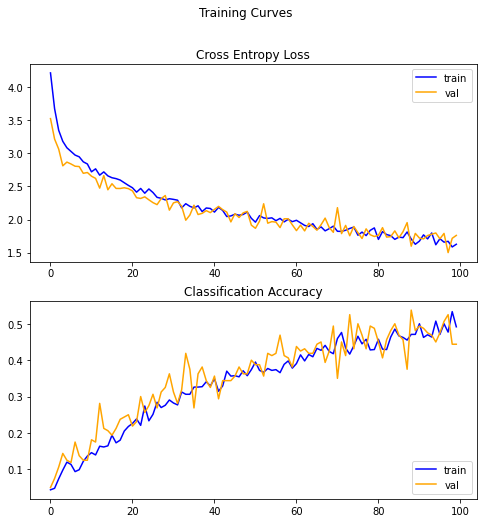


Test set evaluation metrics
10/10 [==============================] - 0s 5ms/step - loss: 1.6495 - accuracy: 0.4797
loss: 1.65
accuracy: 0.48


In [ ]:
FIRST_MODEL_32.save("/content/drive/My Drive/NN/Ex3/Models/FIRST_MODEL_32x32.h5")
model_report (FIRST_MODEL_32,FIRST_MODEL_32_history, 32)

#####Early Stopping

In [ ]:
 def init_first_model_es(summary):
  model = models.Sequential()
  model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(64, (3, 3), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(64, (3, 3), activation='relu'))
  model.add(layers.Conv2D(64, (3, 3), activation='relu'))
  model.add(layers.Flatten())
  model.add(layers.Dense(64, activation='relu'))
  model.add(layers.Dropout(rate=0.5))
  model.add(layers.Dense(100, activation='softmax'))
  
  model.compile(optimizer=tf.optimizers.Adam(), loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=["accuracy"])
  if summary: 
    model.summary()
 #Καθορισμός παραμέτρων Early Stopping
  es = EarlyStopping(monitor='val_loss', min_delta=0.0001, mode='auto', verbose=1, patience=3, restore_best_weights=True)
  #Eκπαίσευση του μοντέλου
  global FIRST_MODEL_32es_history
  FIRST_MODEL_32es_history = model.fit(train_ds, callbacks=[es], epochs=50, steps_per_epoch=30, validation_data=validation_ds, validation_steps=5)
  return model

In [ ]:
start_time = time.time()
FIRST_MODEL_32es = init_first_model_es(summary = True)

duration = time.time() - start_time
print('Training lasted {} seconds'.format(duration))

Model: "sequential_58"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_195 (Conv2D)          (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d_126 (MaxPoolin (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_196 (Conv2D)          (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_127 (MaxPoolin (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_197 (Conv2D)          (None, 4, 4, 64)          36928     
_________________________________________________________________
conv2d_198 (Conv2D)          (None, 2, 2, 64)          36928     
_________________________________________________________________
flatten_58 (Flatten)         (None, 256)             

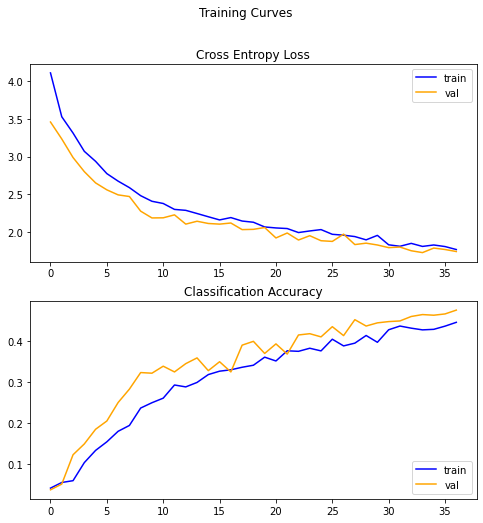


Test set evaluation metrics
10/10 [==============================] - 0s 4ms/step - loss: 1.6999 - accuracy: 0.4820
loss: 1.70
accuracy: 0.48


In [ ]:
FIRST_MODEL_32es.save("/content/drive/My Drive/NN/Ex3/Models/FIRST_MODEL_es_32x32.h5")
model_report (FIRST_MODEL_32es, FIRST_MODEL_32es_history, 32)

#####Reduce Learning Rate

In [ ]:
def init_first_model_lr(summary):
  model = models.Sequential()
  ##Conv1
  model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
  model.add(layers.MaxPooling2D((2, 2)))
  ##Conv2
  model.add(layers.Conv2D(64, (3, 3), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))
  ##Conv3
  model.add(layers.Conv2D(64, (3, 3), activation='relu'))
  ##Conv4
  model.add(layers.Conv2D(64, (3, 3), activation='relu'))

  ###Linear
  model.add(layers.Flatten())
  model.add(layers.Dense(64, activation='relu'))
  model.add(layers.Dropout(rate=0.5))
  model.add(layers.Dense(100, activation='softmax'))
  
  model.compile(optimizer=tf.optimizers.Adam(), loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=["accuracy"])
  if summary: 
    model.summary()
  #Καθορισμός παραμέτρων Reduce Learning Rate
  reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)
  #Eκπαίσευση του μοντέλου
  global FIRST_MODEL_32lr_history
  FIRST_MODEL_32lr_history = model.fit(train_ds, callbacks=[reduce_lr], epochs=50, steps_per_epoch=30, validation_data=validation_ds, validation_steps=5)
  return model

In [ ]:
start_time = time.time()
FIRST_MODEL_32lr = init_first_model_lr(summary = True)

duration = time.time() - start_time
print('Training lasted {} seconds'.format(duration))

Model: "sequential_59"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_199 (Conv2D)          (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d_128 (MaxPoolin (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_200 (Conv2D)          (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_129 (MaxPoolin (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_201 (Conv2D)          (None, 4, 4, 64)          36928     
_________________________________________________________________
conv2d_202 (Conv2D)          (None, 2, 2, 64)          36928     
_________________________________________________________________
flatten_59 (Flatten)         (None, 256)             

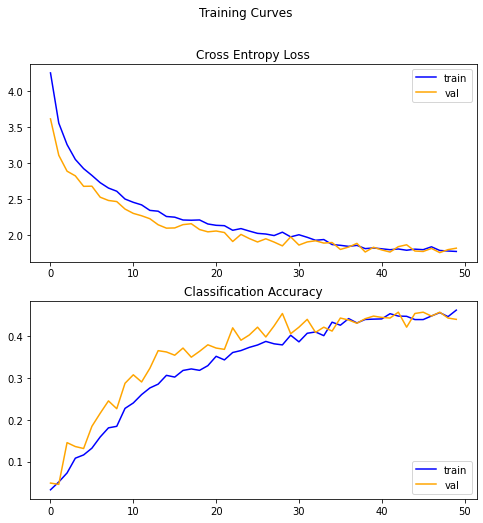


Test set evaluation metrics
10/10 [==============================] - 0s 4ms/step - loss: 1.6824 - accuracy: 0.4805
loss: 1.68
accuracy: 0.48


In [ ]:
FIRST_MODEL_32lr.save("/content/drive/My Drive/NN/Ex3/Models/FIRST_MODEL_lr_32x32.h5")
model_report (FIRST_MODEL_32lr, FIRST_MODEL_32lr_history, 32)

#####Dropout

In [ ]:
def init_first_model_d(summary):
  model = models.Sequential()
  model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(64, (3, 3), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Dropout(rate=0.3))
  model.add(layers.Conv2D(64, (3, 3), activation='relu'))
  model.add(layers.Conv2D(64, (3, 3), activation='relu'))
  model.add(layers.Flatten())
  model.add(layers.Dense(64, activation='relu'))
  model.add(layers.Dropout(rate=0.5))
  model.add(layers.Dense(100, activation='softmax'))
  
  model.compile(optimizer=tf.optimizers.Adam(), loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=["accuracy"])
  if summary: 
    model.summary()
  return model

In [ ]:
FIRST_MODEL_32d = init_first_model_d(summary = True)
start_time = time.time()

FIRST_MODEL_32d_history = train_model(FIRST_MODEL_32d, 'first_model_32d', 32, 32, 50, 30, 5)
duration = time.time() - start_time
print('Training lasted {} seconds'.format(duration))

Model: "sequential_60"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_203 (Conv2D)          (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d_130 (MaxPoolin (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_204 (Conv2D)          (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_131 (MaxPoolin (None, 6, 6, 64)          0         
_________________________________________________________________
dropout_59 (Dropout)         (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_205 (Conv2D)          (None, 4, 4, 64)          36928     
_________________________________________________________________
conv2d_206 (Conv2D)          (None, 2, 2, 64)        

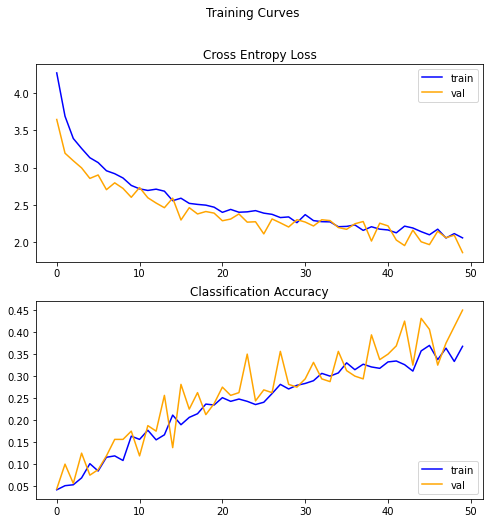


Test set evaluation metrics
10/10 [==============================] - 0s 5ms/step - loss: 1.8885 - accuracy: 0.4227
loss: 1.89
accuracy: 0.42


In [ ]:
FIRST_MODEL_32d.save("/content/drive/My Drive/NN/Ex3/Models/FIRST_MODEL_d_32x32.h5")
model_report (FIRST_MODEL_32d, FIRST_MODEL_32d_history, 32)

#####Data Augmentation

In [ ]:
#DataAugmentation
FIRST_MODEL_32da = init_first_model(summary = True)
start_time = time.time()

FIRST_MODEL_32da_history = train_model(FIRST_MODEL_32da, 'first_model_32_da',32, 32, 50, 30, 5,train_ds_image_gen)
duration = time.time() - start_time
print('Training lasted {} seconds'.format(duration))

Model: "sequential_61"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_207 (Conv2D)          (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d_132 (MaxPoolin (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_208 (Conv2D)          (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_133 (MaxPoolin (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_209 (Conv2D)          (None, 4, 4, 64)          36928     
_________________________________________________________________
conv2d_210 (Conv2D)          (None, 2, 2, 64)          36928     
_________________________________________________________________
flatten_61 (Flatten)         (None, 256)             

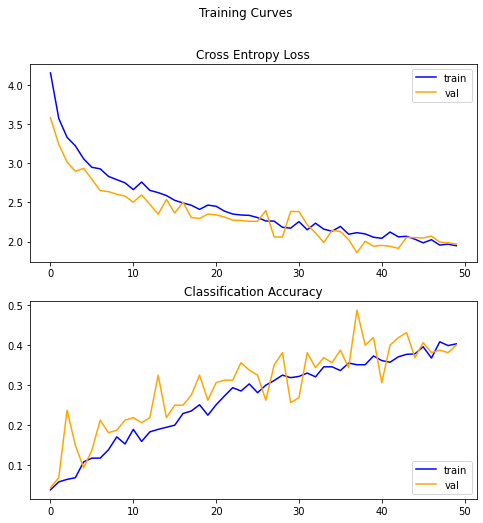


Test set evaluation metrics
10/10 [==============================] - 0s 5ms/step - loss: 1.8356 - accuracy: 0.4500
loss: 1.84
accuracy: 0.45


In [ ]:
FIRST_MODEL_32da.save("/content/drive/My Drive/NN/Ex3/Models/FIRST_MODEL_da_32x32.h5")
model_report (FIRST_MODEL_32da, FIRST_MODEL_32da_history, 32)

#####Resize Input

In [ ]:
def init_first_model82(summary):
  model = models.Sequential()
  model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(82, 82, 3)))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(64, (3, 3), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(64, (3, 3), activation='relu'))
  model.add(layers.Conv2D(64, (3, 3), activation='relu'))
  model.add(layers.Flatten())
  model.add(layers.Dense(64, activation='relu'))
  model.add(layers.Dropout(rate=0.5))
  model.add(layers.Dense(100, activation='softmax'))
  
  model.compile(optimizer=tf.optimizers.Adam(), loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=["accuracy"])
  if summary: 
    model.summary()
  return model

In [ ]:
FIRST_MODEL_82 = init_first_model82(summary = True)
start_time = time.time()

FIRST_MODEL_82_history = train_model(FIRST_MODEL_82, 'first_model_82',82, 32, 50, 30, 5)
duration = time.time() - start_time
print('Training lasted {} seconds'.format(duration))

Model: "sequential_62"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_211 (Conv2D)          (None, 80, 80, 32)        896       
_________________________________________________________________
max_pooling2d_134 (MaxPoolin (None, 40, 40, 32)        0         
_________________________________________________________________
conv2d_212 (Conv2D)          (None, 38, 38, 64)        18496     
_________________________________________________________________
max_pooling2d_135 (MaxPoolin (None, 19, 19, 64)        0         
_________________________________________________________________
conv2d_213 (Conv2D)          (None, 17, 17, 64)        36928     
_________________________________________________________________
conv2d_214 (Conv2D)          (None, 15, 15, 64)        36928     
_________________________________________________________________
flatten_62 (Flatten)         (None, 14400)           

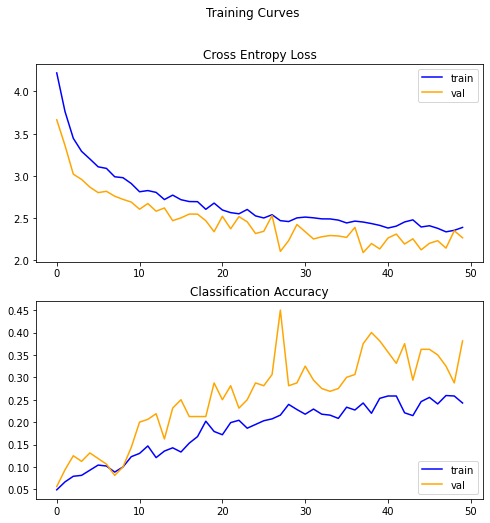


Test set evaluation metrics
10/10 [==============================] - 2s 39ms/step - loss: 2.1148 - accuracy: 0.3719
loss: 2.11
accuracy: 0.37


In [ ]:
FIRST_MODEL_82.save("/content/drive/My Drive/NN/Ex3/Models/FIRST_MODEL_82x82.h5")
model_report (FIRST_MODEL_82, FIRST_MODEL_82_history, 82)

#####Adagrad optimizer

In [ ]:
def init_first_model_op2(summary):
  model = models.Sequential()
  model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(64, (3, 3), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(64, (3, 3), activation='relu'))
  model.add(layers.Conv2D(64, (3, 3), activation='relu'))
  model.add(layers.Flatten())
  model.add(layers.Dense(64, activation='relu'))
  model.add(layers.Dropout(rate=0.5))
  model.add(layers.Dense(100, activation='softmax'))
  
  model.compile(optimizer=tf.optimizers.Adagrad(), loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=["accuracy"])
  if summary: 
    model.summary()
  return model

In [ ]:
FIRST_MODEL_32_op2 = init_first_model_op2(summary = True)
start_time = time.time()

FIRST_MODEL_32_op2_history = train_model(FIRST_MODEL_32_op2, 'first_model_32_op2',32, 32, 50, 30, 5)
duration = time.time() - start_time
print('Training lasted {} seconds'.format(duration))

Model: "sequential_63"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_215 (Conv2D)          (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d_136 (MaxPoolin (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_216 (Conv2D)          (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_137 (MaxPoolin (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_217 (Conv2D)          (None, 4, 4, 64)          36928     
_________________________________________________________________
conv2d_218 (Conv2D)          (None, 2, 2, 64)          36928     
_________________________________________________________________
flatten_63 (Flatten)         (None, 256)             

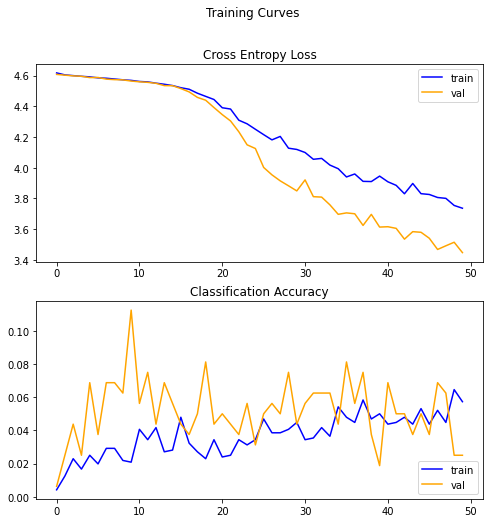


Test set evaluation metrics
10/10 [==============================] - 0s 4ms/step - loss: 3.4622 - accuracy: 0.0570
loss: 3.46
accuracy: 0.06


In [ ]:
FIRST_MODEL_32_op2.save("/content/drive/My Drive/NN/Ex3/Models/FIRST_MODEL_op2_32x32.h5")
model_report (FIRST_MODEL_32_op2,FIRST_MODEL_32_op2_history, 32)

#####RMSprop optimizer

In [ ]:
def init_first_model_op3(summary):
  model = models.Sequential()
  model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(64, (3, 3), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(64, (3, 3), activation='relu'))
  model.add(layers.Conv2D(64, (3, 3), activation='relu'))
  model.add(layers.Flatten())
  model.add(layers.Dense(64, activation='relu'))
  model.add(layers.Dropout(rate=0.5))
  model.add(layers.Dense(100, activation='softmax'))
  
  model.compile(optimizer=tf.optimizers.RMSprop(), loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=["accuracy"])
  if summary: 
    model.summary()
  return model

In [ ]:
FIRST_MODEL_32_op3 = init_first_model_op3(summary = True)
start_time = time.time()

FIRST_MODEL_32_op3_history = train_model(FIRST_MODEL_32_op3, 'first_model_32_op3',32, 32, 50, 30, 5)
duration = time.time() - start_time
print('Training lasted {} seconds'.format(duration))

Model: "sequential_64"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_219 (Conv2D)          (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d_138 (MaxPoolin (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_220 (Conv2D)          (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_139 (MaxPoolin (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_221 (Conv2D)          (None, 4, 4, 64)          36928     
_________________________________________________________________
conv2d_222 (Conv2D)          (None, 2, 2, 64)          36928     
_________________________________________________________________
flatten_64 (Flatten)         (None, 256)             

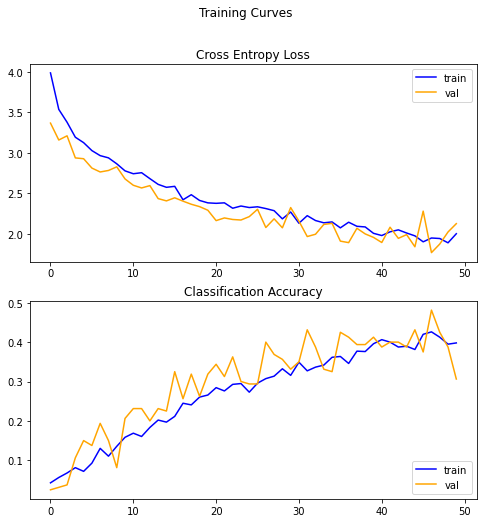


Test set evaluation metrics
10/10 [==============================] - 0s 5ms/step - loss: 1.9465 - accuracy: 0.3945
loss: 1.95
accuracy: 0.39


In [ ]:
FIRST_MODEL_32_op3.save("/content/drive/My Drive/NN/Ex3/Models/FIRST_MODEL_op3_32x32.h5")
model_report (FIRST_MODEL_32_op3,FIRST_MODEL_32_op3_history, 32)

#####Δοκιμή διαφορετικών batch sizes

In [ ]:
#Batch Size
#Batch_size=64

FIRST_MODEL_32_bs64 = init_first_model(summary = True)
start_time = time.time()

FIRST_MODEL_32_bs64_history = train_model(FIRST_MODEL_32_bs64, 'first_model_32_bs64',32, 64, 50, 30, 5)
duration = time.time() - start_time
print('Training lasted {} seconds'.format(duration))

Model: "sequential_65"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_223 (Conv2D)          (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d_140 (MaxPoolin (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_224 (Conv2D)          (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_141 (MaxPoolin (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_225 (Conv2D)          (None, 4, 4, 64)          36928     
_________________________________________________________________
conv2d_226 (Conv2D)          (None, 2, 2, 64)          36928     
_________________________________________________________________
flatten_65 (Flatten)         (None, 256)             

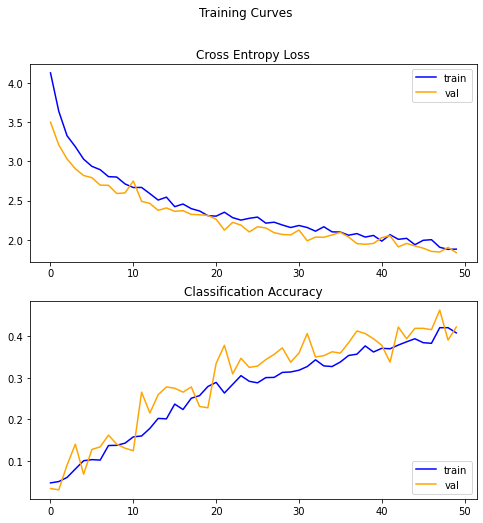


Test set evaluation metrics
10/10 [==============================] - 0s 4ms/step - loss: 1.7541 - accuracy: 0.4664
loss: 1.75
accuracy: 0.47


In [ ]:
FIRST_MODEL_32_bs64.save("/content/drive/My Drive/NN/Ex3/Models/FIRST_MODEL_bs64_32x32.h5")
model_report (FIRST_MODEL_32_bs64,FIRST_MODEL_32_bs64_history, 32)

In [ ]:
#Batch_size=128
FIRST_MODEL_32_bs128 = init_first_model(summary = True)
start_time = time.time()

FIRST_MODEL_32_bs128_history = train_model(FIRST_MODEL_32_bs128, 'first_model_bs128',32, 128, 50, 30, 5)
duration = time.time() - start_time
print('Training lasted {} seconds'.format(duration))

Model: "sequential_66"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_227 (Conv2D)          (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d_142 (MaxPoolin (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_228 (Conv2D)          (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_143 (MaxPoolin (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_229 (Conv2D)          (None, 4, 4, 64)          36928     
_________________________________________________________________
conv2d_230 (Conv2D)          (None, 2, 2, 64)          36928     
_________________________________________________________________
flatten_66 (Flatten)         (None, 256)             

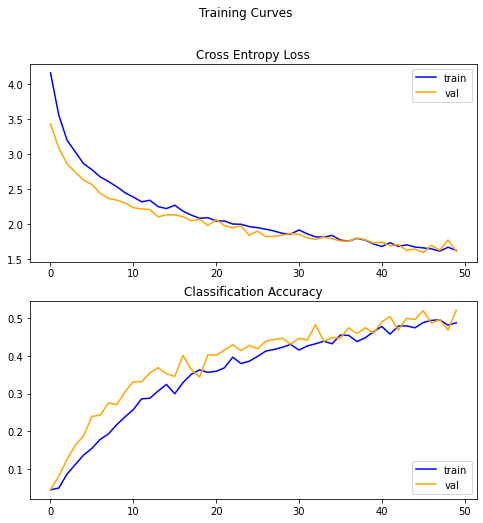


Test set evaluation metrics
10/10 [==============================] - 0s 4ms/step - loss: 1.5158 - accuracy: 0.5281
loss: 1.52
accuracy: 0.53


In [ ]:
FIRST_MODEL_32_bs128.save("/content/drive/My Drive/NN/Ex3/Models/FIRST_MODEL_bs128_32x32.h5")
model_report (FIRST_MODEL_32_bs128,FIRST_MODEL_32_bs128_history, 32)

####**Second Model**

Το μοντέλο αποτελείται από:

1st Block
```
- Convolutional Layer
- Maxpooling Layer
- Batch Normalization
```
2nd Block
```
- Convolutional Layer
- Maxpooling Layer

```
3rd Block
```
- Convolutional Layer
- Maxpooling Layer
```
Fully Connected Layers
```
- Dense layer
- Dense layer
- Dense layer
```

In [ ]:
def init_second_model(summary):
  model = models.Sequential()
  model.add(layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(32,32,3)))
  model.add(layers.MaxPooling2D(pool_size=(2, 2)))
  model.add(layers.BatchNormalization(axis=-1,scale=False))
  model.add(layers.Conv2D(64, kernel_size=(3, 3), activation='relu'))
  model.add(layers.MaxPooling2D(pool_size=(2, 2)))
  model.add(layers.Conv2D(128, kernel_size=(3, 3), activation='relu'))
  model.add(layers.MaxPooling2D(pool_size=(2, 2)))
  model.add(layers.Flatten())
  model.add(layers.Dense(256, activation='relu'))
  
  model.add(layers.Dense(64, activation='relu'))
  
  model.add(layers.Dense(100, activation='softmax'))
  
  model.compile(optimizer=tf.optimizers.Adam(), loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=["accuracy"])
  if summary: 
    model.summary()
  return model

In [ ]:
SECOND_MODEL_32 = init_second_model(summary = True)
start_time = time.time()

SECOND_MODEL_32_history = train_model(SECOND_MODEL_32, 'second_model_32',32, 32, 100, 30, 5)
duration = time.time() - start_time
print('Training lasted {} seconds'.format(duration))

Model: "sequential_67"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_231 (Conv2D)          (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d_144 (MaxPoolin (None, 15, 15, 32)        0         
_________________________________________________________________
batch_normalization_10 (Batc (None, 15, 15, 32)        96        
_________________________________________________________________
conv2d_232 (Conv2D)          (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_145 (MaxPoolin (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_233 (Conv2D)          (None, 4, 4, 128)         73856     
_________________________________________________________________
max_pooling2d_146 (MaxPoolin (None, 2, 2, 128)       

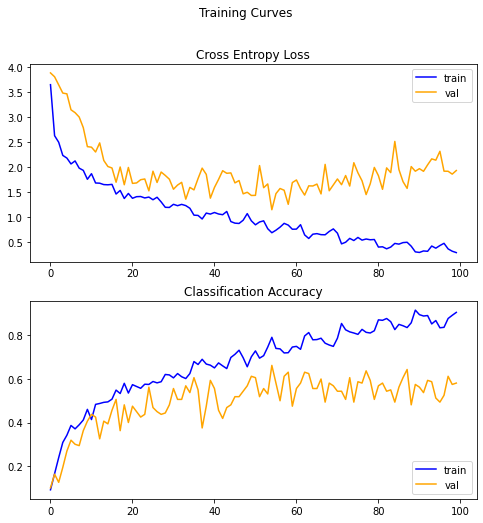


Test set evaluation metrics
10/10 [==============================] - 0s 5ms/step - loss: 1.8847 - accuracy: 0.5773
loss: 1.88
accuracy: 0.58


In [ ]:
SECOND_MODEL_32.save("/content/drive/My Drive/NN/Ex3/Models/SECOND_MODEL_32x32.h5")
model_report (SECOND_MODEL_32,SECOND_MODEL_32_history, 32)

#####Early Stopping

In [ ]:
def init_second_model_es(summary):
  model = models.Sequential()
  
  
  model.add(layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(32,32,3)))
  model.add(layers.MaxPooling2D(pool_size=(2, 2)))
  model.add(layers.BatchNormalization(axis=-1,scale=False))
  
  
  model.add(layers.Conv2D(64, kernel_size=(3, 3), activation='relu'))
  model.add(layers.MaxPooling2D(pool_size=(2, 2)))
  
  
  
  model.add(layers.Conv2D(128, kernel_size=(3, 3), activation='relu'))
  model.add(layers.MaxPooling2D(pool_size=(2, 2)))
  
  

  model.add(layers.Flatten())
  model.add(layers.Dense(256, activation='relu'))
  
  model.add(layers.Dense(64, activation='relu'))
  
  model.add(layers.Dense(100, activation='softmax'))
  
  model.compile(optimizer=tf.optimizers.Adam(), loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=["accuracy"])
  if summary: 
    model.summary()
#Καθορισμός παραμέτρων Early Stopping
  es = EarlyStopping(monitor='val_loss', min_delta=0.0001, mode='auto', verbose=1, patience=3, restore_best_weights=True)
  #Eκπαίσευση του μοντέλου
  global SECOND_MODEL_32es_history
  SECOND_MODEL_32es_history = model.fit(train_ds, callbacks=[es], epochs=50, steps_per_epoch=30, validation_data=validation_ds, validation_steps=5)
  return model

In [ ]:
start_time = time.time()
SECOND_MODEL_32es = init_second_model_es(summary = True)

duration = time.time() - start_time
print('Training lasted {} seconds'.format(duration))

Model: "sequential_68"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_234 (Conv2D)          (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d_147 (MaxPoolin (None, 15, 15, 32)        0         
_________________________________________________________________
batch_normalization_11 (Batc (None, 15, 15, 32)        96        
_________________________________________________________________
conv2d_235 (Conv2D)          (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_148 (MaxPoolin (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_236 (Conv2D)          (None, 4, 4, 128)         73856     
_________________________________________________________________
max_pooling2d_149 (MaxPoolin (None, 2, 2, 128)       

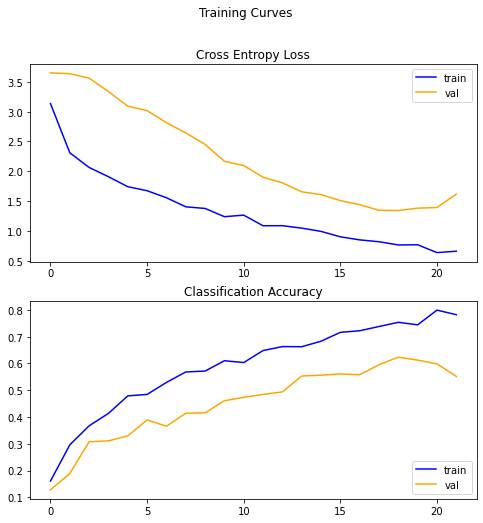


Test set evaluation metrics
10/10 [==============================] - 0s 4ms/step - loss: 1.3137 - accuracy: 0.6062
loss: 1.31
accuracy: 0.61


In [ ]:
SECOND_MODEL_32es.save("/content/drive/My Drive/NN/Ex3/Models/SECOND_MODEL_es_32x32.h5")
model_report (SECOND_MODEL_32es, SECOND_MODEL_32es_history, 32)

#####Reduce Learning Rate

In [ ]:
def init_second_model_lr(summary):
  model = models.Sequential()
  
  
  model.add(layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(32,32,3)))
  model.add(layers.MaxPooling2D(pool_size=(2, 2)))
  model.add(layers.BatchNormalization(axis=-1,scale=False))
  
  
  model.add(layers.Conv2D(64, kernel_size=(3, 3), activation='relu'))
  model.add(layers.MaxPooling2D(pool_size=(2, 2)))
  
  
  
  model.add(layers.Conv2D(128, kernel_size=(3, 3), activation='relu'))
  model.add(layers.MaxPooling2D(pool_size=(2, 2)))
  
  

  model.add(layers.Flatten())
  model.add(layers.Dense(256, activation='relu'))
  
  model.add(layers.Dense(64, activation='relu'))
  
  model.add(layers.Dense(100, activation='softmax'))
  
  model.compile(optimizer=tf.optimizers.Adam(), loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=["accuracy"])
  if summary: 
    model.summary()
    #Καθορισμός παραμέτρων Reduce Learning Rate
  reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)
  #Eκπαίσευση του μοντέλου
  global SECOND_MODEL_32lr_history
  SECOND_MODEL_32lr_history = model.fit(train_ds, callbacks=[reduce_lr], epochs=50, steps_per_epoch=30, validation_data=validation_ds, validation_steps=5)
  return model

In [ ]:
start_time = time.time()
SECOND_MODEL_32lr = init_second_model_lr(summary = True)

duration = time.time() - start_time
print('Training lasted {} seconds'.format(duration))

Model: "sequential_69"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_237 (Conv2D)          (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d_150 (MaxPoolin (None, 15, 15, 32)        0         
_________________________________________________________________
batch_normalization_12 (Batc (None, 15, 15, 32)        96        
_________________________________________________________________
conv2d_238 (Conv2D)          (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_151 (MaxPoolin (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_239 (Conv2D)          (None, 4, 4, 128)         73856     
_________________________________________________________________
max_pooling2d_152 (MaxPoolin (None, 2, 2, 128)       

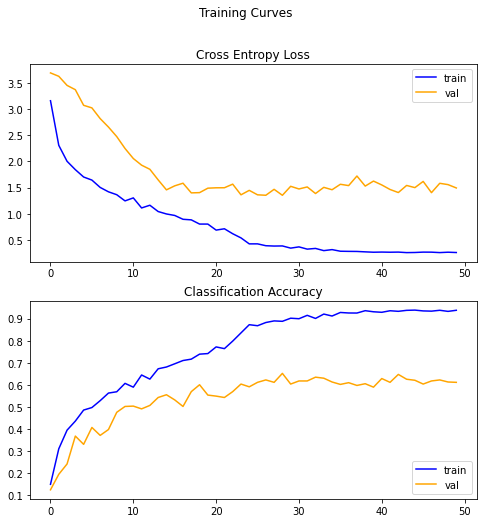


Test set evaluation metrics
10/10 [==============================] - 0s 4ms/step - loss: 1.3099 - accuracy: 0.6328
loss: 1.31
accuracy: 0.63


In [ ]:
SECOND_MODEL_32lr.save("/content/drive/My Drive/NN/Ex3/Models/SECOND_MODEL_lr_32x32.h5")
model_report (SECOND_MODEL_32lr, SECOND_MODEL_32lr_history, 32)

#####Dropout

In [ ]:
def init_second_model_d(summary):
  model = models.Sequential()
  
  
  model.add(layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(32,32,3)))
  model.add(layers.MaxPooling2D(pool_size=(2, 2)))
  model.add(layers.BatchNormalization(axis=-1,scale=False))
  
  
  model.add(layers.Conv2D(64, kernel_size=(3, 3), activation='relu'))
  model.add(layers.MaxPooling2D(pool_size=(2, 2)))
  
  
  
  model.add(layers.Conv2D(128, kernel_size=(3, 3), activation='relu'))
  model.add(layers.MaxPooling2D(pool_size=(2, 2)))
  
  model.add(layers.Dropout(rate=0.3))
  

  model.add(layers.Flatten())
  model.add(layers.Dense(256, activation='relu'))
  
  model.add(layers.Dense(64, activation='relu'))
  
  model.add(layers.Dense(100, activation='softmax'))
  
  model.compile(optimizer=tf.optimizers.Adam(), loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=["accuracy"])
  if summary: 
    model.summary()
  return model

In [ ]:
SECOND_MODEL_32d = init_second_model_d(summary = True)
start_time = time.time()

SECOND_MODEL_32d_history = train_model(SECOND_MODEL_32d, 'second_model_32d', 32, 32, 50, 30, 5)
duration = time.time() - start_time
print('Training lasted {} seconds'.format(duration))

Model: "sequential_70"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_240 (Conv2D)          (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d_153 (MaxPoolin (None, 15, 15, 32)        0         
_________________________________________________________________
batch_normalization_13 (Batc (None, 15, 15, 32)        96        
_________________________________________________________________
conv2d_241 (Conv2D)          (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_154 (MaxPoolin (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_242 (Conv2D)          (None, 4, 4, 128)         73856     
_________________________________________________________________
max_pooling2d_155 (MaxPoolin (None, 2, 2, 128)       

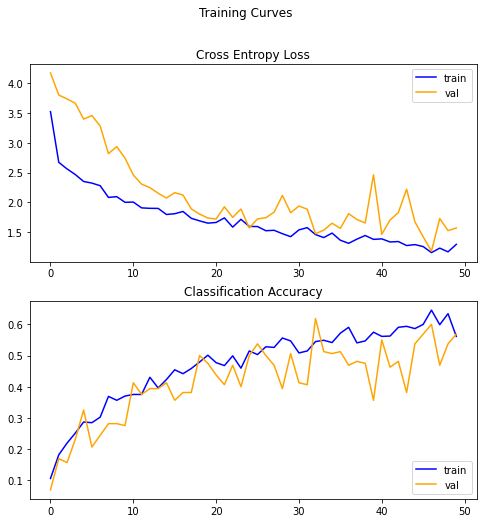


Test set evaluation metrics
10/10 [==============================] - 0s 4ms/step - loss: 1.5084 - accuracy: 0.5477
loss: 1.51
accuracy: 0.55


In [ ]:
SECOND_MODEL_32d.save("/content/drive/My Drive/NN/Ex3/Models/SECOND_MODEL_d_32x32.h5")
model_report (SECOND_MODEL_32d, SECOND_MODEL_32d_history, 32)

#####Data Augmentation

In [ ]:
#DataAugmentation
SECOND_MODEL_32da = init_second_model(summary = True)
start_time = time.time()

SECOND_MODEL_32da_history = train_model(SECOND_MODEL_32da, 'second_model_32_da',32, 32, 50, 30, 5,train_ds_image_gen)
duration = time.time() - start_time
print('Training lasted {} seconds'.format(duration))

Model: "sequential_71"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_243 (Conv2D)          (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d_156 (MaxPoolin (None, 15, 15, 32)        0         
_________________________________________________________________
batch_normalization_14 (Batc (None, 15, 15, 32)        96        
_________________________________________________________________
conv2d_244 (Conv2D)          (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_157 (MaxPoolin (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_245 (Conv2D)          (None, 4, 4, 128)         73856     
_________________________________________________________________
max_pooling2d_158 (MaxPoolin (None, 2, 2, 128)       

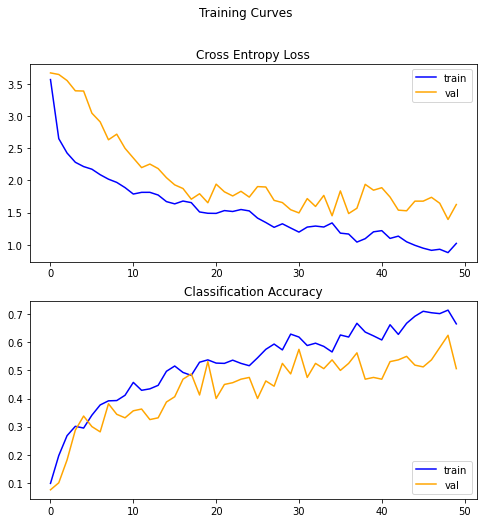


Test set evaluation metrics
10/10 [==============================] - 0s 5ms/step - loss: 1.4979 - accuracy: 0.5539
loss: 1.50
accuracy: 0.55


In [ ]:
SECOND_MODEL_32da.save("/content/drive/My Drive/NN/Ex3/Models/SECOND_MODEL_da_32x32.h5")
model_report (SECOND_MODEL_32da, SECOND_MODEL_32da_history, 32)

#####Resize Input

In [ ]:
def init_second_model82(summary):
  model = models.Sequential()
  
  
  model.add(layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(82,82,3)))
  model.add(layers.MaxPooling2D(pool_size=(2, 2)))
  model.add(layers.BatchNormalization(axis=-1,scale=False))
  
 
  model.add(layers.Conv2D(64, kernel_size=(3, 3), activation='relu'))
  model.add(layers.MaxPooling2D(pool_size=(2, 2)))
  
  
  
  model.add(layers.Conv2D(128, kernel_size=(3, 3), activation='relu'))
  model.add(layers.MaxPooling2D(pool_size=(2, 2)))
  
  

  model.add(layers.Flatten())
  model.add(layers.Dense(256, activation='relu'))
  
  model.add(layers.Dense(64, activation='relu'))
  
  model.add(layers.Dense(100, activation='softmax'))
  
  model.compile(optimizer=tf.optimizers.Adam(), loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=["accuracy"])
  if summary: 
    model.summary()
  return model

In [ ]:
SECOND_MODEL_82 = init_second_model82(summary = True)
start_time = time.time()

SECOND_MODEL_82_history = train_model(SECOND_MODEL_82, 'second_model_82',82, 32, 50, 30, 5)
duration = time.time() - start_time
print('Training lasted {} seconds'.format(duration))

Model: "sequential_72"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_246 (Conv2D)          (None, 80, 80, 32)        896       
_________________________________________________________________
max_pooling2d_159 (MaxPoolin (None, 40, 40, 32)        0         
_________________________________________________________________
batch_normalization_15 (Batc (None, 40, 40, 32)        96        
_________________________________________________________________
conv2d_247 (Conv2D)          (None, 38, 38, 64)        18496     
_________________________________________________________________
max_pooling2d_160 (MaxPoolin (None, 19, 19, 64)        0         
_________________________________________________________________
conv2d_248 (Conv2D)          (None, 17, 17, 128)       73856     
_________________________________________________________________
max_pooling2d_161 (MaxPoolin (None, 8, 8, 128)       

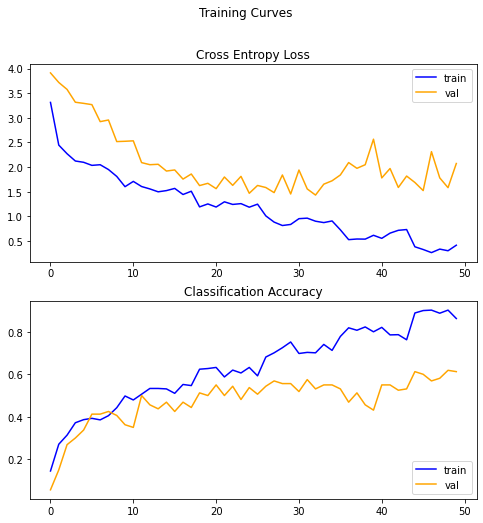


Test set evaluation metrics
10/10 [==============================] - 2s 40ms/step - loss: 1.8817 - accuracy: 0.5742
loss: 1.88
accuracy: 0.57


In [ ]:
SECOND_MODEL_82.save("/content/drive/My Drive/NN/Ex3/Models/SECOND_MODEL_82x32.h5")
model_report (SECOND_MODEL_82,SECOND_MODEL_82_history, 82)

#####Adagrad optimizer

In [ ]:
def init_second_model_op2(summary):
  model = models.Sequential()
  
  
  model.add(layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(32,32,3)))
  model.add(layers.MaxPooling2D(pool_size=(2, 2)))
  model.add(layers.BatchNormalization(axis=-1,scale=False))
  
  
  model.add(layers.Conv2D(64, kernel_size=(3, 3), activation='relu'))
  model.add(layers.MaxPooling2D(pool_size=(2, 2)))
  
  
  
  model.add(layers.Conv2D(128, kernel_size=(3, 3), activation='relu'))
  model.add(layers.MaxPooling2D(pool_size=(2, 2)))
  
  

  model.add(layers.Flatten())
  model.add(layers.Dense(256, activation='relu'))
  
  model.add(layers.Dense(64, activation='relu'))
  
  model.add(layers.Dense(100, activation='softmax'))
  
  model.compile(optimizer=tf.optimizers.Adagrad(), loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=["accuracy"])
  if summary: 
    model.summary()
  return model

In [ ]:
SECOND_MODEL_32_op2 = init_second_model_op2(summary = True)
start_time = time.time()

SECOND_MODEL_32_op2_history = train_model(SECOND_MODEL_32_op2, 'second_model_32_op2',32, 32, 50, 30, 5)
duration = time.time() - start_time
print('Training lasted {} seconds'.format(duration))

Model: "sequential_73"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_249 (Conv2D)          (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d_162 (MaxPoolin (None, 15, 15, 32)        0         
_________________________________________________________________
batch_normalization_16 (Batc (None, 15, 15, 32)        96        
_________________________________________________________________
conv2d_250 (Conv2D)          (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_163 (MaxPoolin (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_251 (Conv2D)          (None, 4, 4, 128)         73856     
_________________________________________________________________
max_pooling2d_164 (MaxPoolin (None, 2, 2, 128)       

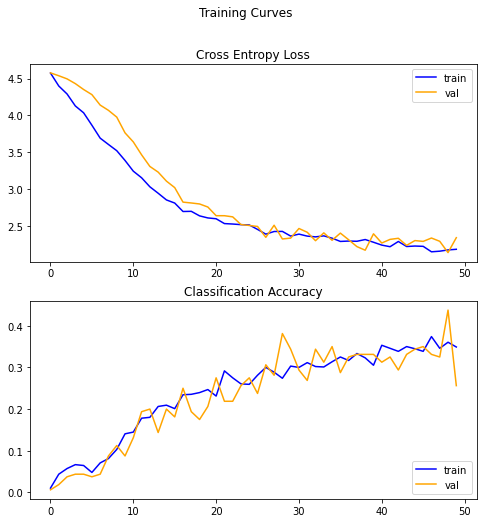


Test set evaluation metrics
10/10 [==============================] - 0s 4ms/step - loss: 2.1709 - accuracy: 0.3727
loss: 2.17
accuracy: 0.37


In [ ]:
SECOND_MODEL_32_op2.save("/content/drive/My Drive/NN/Ex3/Models/SECOND_MODEL_op2_32x32.h5")
model_report (SECOND_MODEL_32_op2,SECOND_MODEL_32_op2_history, 32)

#####RMSprop optimizer

In [ ]:
def init_second_model_op3(summary):
  model = models.Sequential()
  

  model.add(layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(32,32,3)))
  model.add(layers.MaxPooling2D(pool_size=(2, 2)))
  model.add(layers.BatchNormalization(axis=-1,scale=False))
  
  
  model.add(layers.Conv2D(64, kernel_size=(3, 3), activation='relu'))
  model.add(layers.MaxPooling2D(pool_size=(2, 2)))
  
  
  model.add(layers.Conv2D(128, kernel_size=(3, 3), activation='relu'))
  model.add(layers.MaxPooling2D(pool_size=(2, 2)))
  
  

  model.add(layers.Flatten())
  model.add(layers.Dense(256, activation='relu'))
  
  model.add(layers.Dense(64, activation='relu'))
  
  model.add(layers.Dense(100, activation='softmax'))
  
  model.compile(optimizer=tf.optimizers.RMSprop(), loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=["accuracy"])
  if summary: 
    model.summary()
  return model

In [ ]:
SECOND_MODEL_32_op3 = init_second_model_op3(summary = True)
start_time = time.time()

SECOND_MODEL_32_op3_history = train_model(SECOND_MODEL_32_op3, 'second_model_32_op3',32, 32, 50, 30, 5)
duration = time.time() - start_time
print('Training lasted {} seconds'.format(duration))

Model: "sequential_74"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_252 (Conv2D)          (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d_165 (MaxPoolin (None, 15, 15, 32)        0         
_________________________________________________________________
batch_normalization_17 (Batc (None, 15, 15, 32)        96        
_________________________________________________________________
conv2d_253 (Conv2D)          (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_166 (MaxPoolin (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_254 (Conv2D)          (None, 4, 4, 128)         73856     
_________________________________________________________________
max_pooling2d_167 (MaxPoolin (None, 2, 2, 128)       

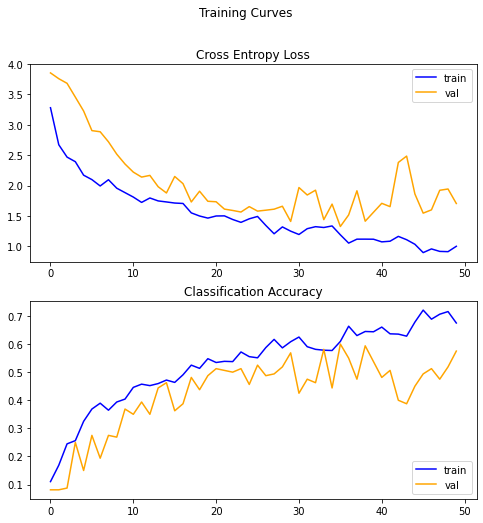


Test set evaluation metrics
10/10 [==============================] - 0s 7ms/step - loss: 1.6249 - accuracy: 0.5594
loss: 1.62
accuracy: 0.56


In [ ]:
SECOND_MODEL_32_op3.save("/content/drive/My Drive/NN/Ex3/Models/SECOND_MODEL_op3_32x32.h5")
model_report (SECOND_MODEL_32_op3,SECOND_MODEL_32_op3_history, 32)

#####Δοκιμή διαφορετικών batch sizes

In [ ]:
#Batch size=64
SECOND_MODEL_32_bs64 = init_second_model(summary = True)
start_time = time.time()

SECOND_MODEL_32_bs64_history = train_model(SECOND_MODEL_32_bs64, 'second_model_32',32, 64, 50, 30, 5)
duration = time.time() - start_time
print('Training lasted {} seconds'.format(duration))

Model: "sequential_75"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_255 (Conv2D)          (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d_168 (MaxPoolin (None, 15, 15, 32)        0         
_________________________________________________________________
batch_normalization_18 (Batc (None, 15, 15, 32)        96        
_________________________________________________________________
conv2d_256 (Conv2D)          (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_169 (MaxPoolin (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_257 (Conv2D)          (None, 4, 4, 128)         73856     
_________________________________________________________________
max_pooling2d_170 (MaxPoolin (None, 2, 2, 128)       

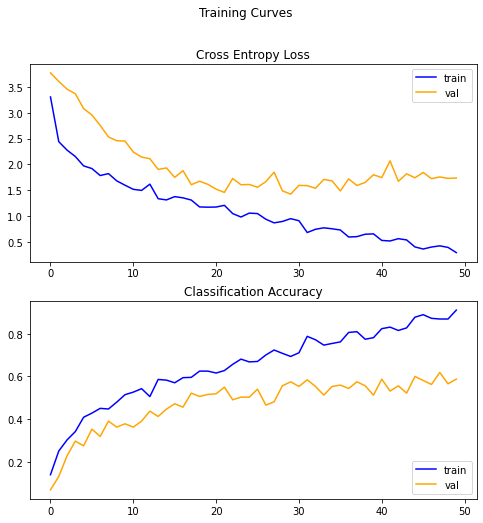


Test set evaluation metrics
10/10 [==============================] - 0s 5ms/step - loss: 1.6746 - accuracy: 0.5977
loss: 1.67
accuracy: 0.60


In [ ]:
SECOND_MODEL_32_bs64.save("/content/drive/My Drive/NN/Ex3/Models/SECOND_MODEL_bs64_32x32.h5")
model_report (SECOND_MODEL_32_bs64,SECOND_MODEL_32_bs64_history, 32)

In [ ]:
#Batch size=128
SECOND_MODEL_32_bs128 = init_second_model(summary = True)
start_time = time.time()

SECOND_MODEL_32_bs128_history = train_model(SECOND_MODEL_32_bs128, 'second_model_128',32, 128, 50, 30, 5)
duration = time.time() - start_time
print('Training lasted {} seconds'.format(duration))

Model: "sequential_76"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_258 (Conv2D)          (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d_171 (MaxPoolin (None, 15, 15, 32)        0         
_________________________________________________________________
batch_normalization_19 (Batc (None, 15, 15, 32)        96        
_________________________________________________________________
conv2d_259 (Conv2D)          (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_172 (MaxPoolin (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_260 (Conv2D)          (None, 4, 4, 128)         73856     
_________________________________________________________________
max_pooling2d_173 (MaxPoolin (None, 2, 2, 128)       

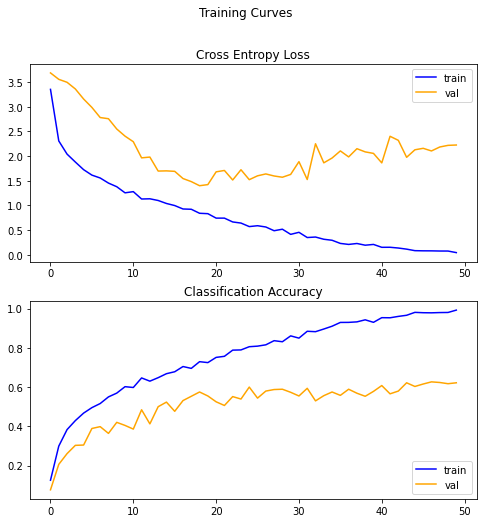


Test set evaluation metrics
10/10 [==============================] - 0s 4ms/step - loss: 2.1726 - accuracy: 0.6281
loss: 2.17
accuracy: 0.63


In [ ]:
SECOND_MODEL_32_bs128.save("/content/drive/My Drive/NN/Ex3/Models/SECOND_MODEL_bs128_32x32.h5")
model_report (SECOND_MODEL_32_bs128,SECOND_MODEL_32_bs128_history, 32)

####**Third Model**

Το μοντέλο αποτελείται από: 

1st Block
```
- Convolutional Layer
- Convolutional Layer
- Maxpooling Layer
- Dropout
```
2nd Block
```
- Convolutional Layer
- Convolutional Layer
- Maxpooling Layer
- Dropout
```
Fully Connected Layers
```
- Dense layer
- Dropout layer
- Dense layer
- Dropout layer
- Dense layer
```

In [ ]:
def init_third_model(summary):
  model = models.Sequential()


  model.add(layers.Conv2D(32, (5, 5),padding='valid',activation='relu', input_shape=(32, 32, 3)))
  model.add(layers.Conv2D(64, (5, 5),padding='valid',activation='relu'))

  model.add(layers.MaxPooling2D(pool_size=(2, 2)))
  model.add(layers.Dropout(rate=0.25))
  
  model.add(layers.Conv2D(64, (3, 3),padding='valid',activation='relu'))
  model.add(layers.Conv2D(64, (3, 3),padding='valid',activation='relu'))
  
  model.add(layers.MaxPooling2D(pool_size=(2, 2)))
  model.add(layers.Dropout(rate=0.25))

  
  
  model.add(layers.Flatten())
  model.add(layers.Dense(1024, activation='relu'))
  model.add(layers.Dropout(rate=0.4))

  model.add(layers.Dense(512, activation='relu'))
  model.add(layers.Dropout(rate=0.4))
  
  model.add(layers.Dense(100, activation='softmax'))
  
  model.compile(optimizer=tf.optimizers.Adam(), loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=["accuracy"])
  if summary: 
    model.summary()
  return model
  

In [ ]:
THIRD_MODEL_32 = init_third_model(summary = True)
start_time = time.time()

THIRD_MODEL_32_history = train_model(THIRD_MODEL_32, 'second_third_32',32, 32, 100, 30, 5)
duration = time.time() - start_time
print('Training lasted {} seconds'.format(duration))

Model: "sequential_77"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_261 (Conv2D)          (None, 28, 28, 32)        2432      
_________________________________________________________________
conv2d_262 (Conv2D)          (None, 24, 24, 64)        51264     
_________________________________________________________________
max_pooling2d_174 (MaxPoolin (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_68 (Dropout)         (None, 12, 12, 64)        0         
_________________________________________________________________
conv2d_263 (Conv2D)          (None, 10, 10, 64)        36928     
_________________________________________________________________
conv2d_264 (Conv2D)          (None, 8, 8, 64)          36928     
_________________________________________________________________
max_pooling2d_175 (MaxPoolin (None, 4, 4, 64)        

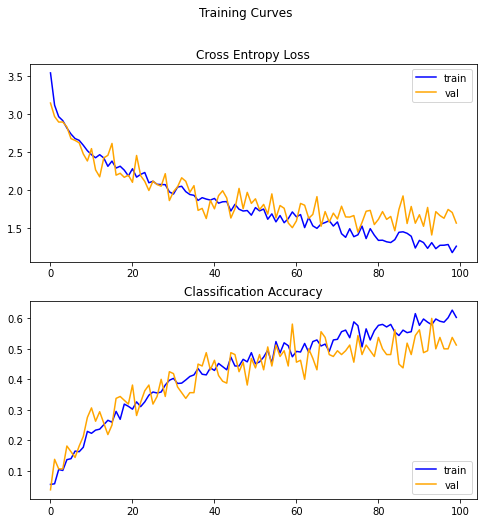


Test set evaluation metrics
10/10 [==============================] - 0s 6ms/step - loss: 1.5749 - accuracy: 0.5102
loss: 1.57
accuracy: 0.51


In [ ]:
THIRD_MODEL_32.save("/content/drive/My Drive/NN/Ex3/Models/THIRD_MODEL_32x32.h5")
model_report (THIRD_MODEL_32,THIRD_MODEL_32_history, 32)

#####Early Stopping

In [ ]:
#Early Stopping
def init_third_model_es(summary):
  model = models.Sequential()


  model.add(layers.Conv2D(32, (5, 5),padding='valid',activation='relu', input_shape=(32, 32, 3)))
  model.add(layers.Conv2D(64, (5, 5),padding='valid',activation='relu'))

  model.add(layers.MaxPooling2D(pool_size=(2, 2)))
  model.add(layers.Dropout(rate=0.25))
  
  model.add(layers.Conv2D(64, (3, 3),padding='valid',activation='relu'))
  model.add(layers.Conv2D(64, (3, 3),padding='valid',activation='relu'))
  
  model.add(layers.MaxPooling2D(pool_size=(2, 2)))
  model.add(layers.Dropout(rate=0.25))

  
  
  model.add(layers.Flatten())
  model.add(layers.Dense(1024, activation='relu'))
  model.add(layers.Dropout(rate=0.4))

  model.add(layers.Dense(512, activation='relu'))
  model.add(layers.Dropout(rate=0.4))
  
  model.add(layers.Dense(100, activation='softmax'))
  
  model.compile(optimizer=tf.optimizers.Adam(), loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=["accuracy"])
  if summary: 
    model.summary()
  #Καθορισμός παραμέτρων Early Stopping
  es = EarlyStopping(monitor='val_loss', min_delta=0.0001, mode='auto', verbose=1, patience=3, restore_best_weights=True)
  #Eκπαίσευση του μοντέλου
  global THIRD_MODEL_32es_history
  THIRD_MODEL_32es_history = model.fit(train_ds, callbacks=[es], epochs=50, steps_per_epoch=30, validation_data=validation_ds, validation_steps=5)
  return model

In [ ]:
start_time = time.time()
THIRD_MODEL_32es = init_third_model_es(summary = True)

duration = time.time() - start_time
print('Training lasted {} seconds'.format(duration))

Model: "sequential_78"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_265 (Conv2D)          (None, 28, 28, 32)        2432      
_________________________________________________________________
conv2d_266 (Conv2D)          (None, 24, 24, 64)        51264     
_________________________________________________________________
max_pooling2d_176 (MaxPoolin (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_72 (Dropout)         (None, 12, 12, 64)        0         
_________________________________________________________________
conv2d_267 (Conv2D)          (None, 10, 10, 64)        36928     
_________________________________________________________________
conv2d_268 (Conv2D)          (None, 8, 8, 64)          36928     
_________________________________________________________________
max_pooling2d_177 (MaxPoolin (None, 4, 4, 64)        

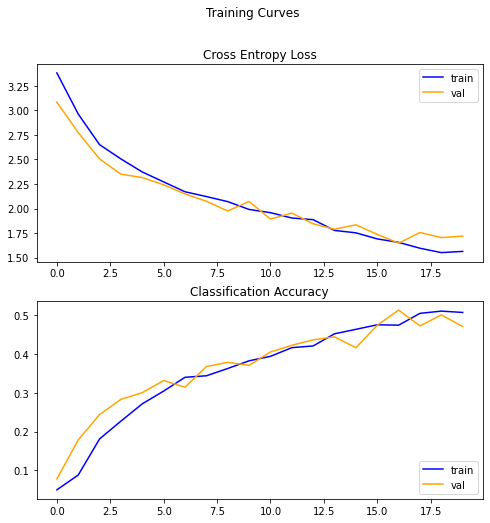


Test set evaluation metrics
10/10 [==============================] - 0s 5ms/step - loss: 1.6149 - accuracy: 0.5070
loss: 1.61
accuracy: 0.51


In [ ]:
THIRD_MODEL_32es.save("/content/drive/My Drive/NN/Ex3/Models/THIRD_MODEL_es_32x32.h5")
model_report (THIRD_MODEL_32es, THIRD_MODEL_32es_history, 32)

#####Reduce Learning Rate

In [ ]:
def init_third_model_lr(summary):
  model = models.Sequential()


  model.add(layers.Conv2D(32, (5, 5),padding='valid',activation='relu', input_shape=(32, 32, 3)))
  model.add(layers.Conv2D(64, (5, 5),padding='valid',activation='relu'))

  model.add(layers.MaxPooling2D(pool_size=(2, 2)))
  model.add(layers.Dropout(rate=0.25))
  
  model.add(layers.Conv2D(64, (3, 3),padding='valid',activation='relu'))
  model.add(layers.Conv2D(64, (3, 3),padding='valid',activation='relu'))
  
  model.add(layers.MaxPooling2D(pool_size=(2, 2)))
  model.add(layers.Dropout(rate=0.25))

  
  
  model.add(layers.Flatten())
  model.add(layers.Dense(1024, activation='relu'))
  model.add(layers.Dropout(rate=0.4))

  model.add(layers.Dense(512, activation='relu'))
  model.add(layers.Dropout(rate=0.4))
  
  model.add(layers.Dense(100, activation='softmax'))
  
  model.compile(optimizer=tf.optimizers.Adam(), loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=["accuracy"])
  if summary: 
    model.summary()
  #Καθορισμός παραμέτρων Reduce Learning Rate
  reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)
  #Eκπαίσευση του μοντέλου
  global THIRD_MODEL_32lr_history
  THIRD_MODEL_32lr_history = model.fit(train_ds, callbacks=[reduce_lr], epochs=50, steps_per_epoch=30, validation_data=validation_ds, validation_steps=5)
  return model

In [ ]:
start_time = time.time()
THIRD_MODEL_32lr = init_third_model_lr(summary = True)

duration = time.time() - start_time
print('Training lasted {} seconds'.format(duration))

Model: "sequential_79"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_269 (Conv2D)          (None, 28, 28, 32)        2432      
_________________________________________________________________
conv2d_270 (Conv2D)          (None, 24, 24, 64)        51264     
_________________________________________________________________
max_pooling2d_178 (MaxPoolin (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_76 (Dropout)         (None, 12, 12, 64)        0         
_________________________________________________________________
conv2d_271 (Conv2D)          (None, 10, 10, 64)        36928     
_________________________________________________________________
conv2d_272 (Conv2D)          (None, 8, 8, 64)          36928     
_________________________________________________________________
max_pooling2d_179 (MaxPoolin (None, 4, 4, 64)        

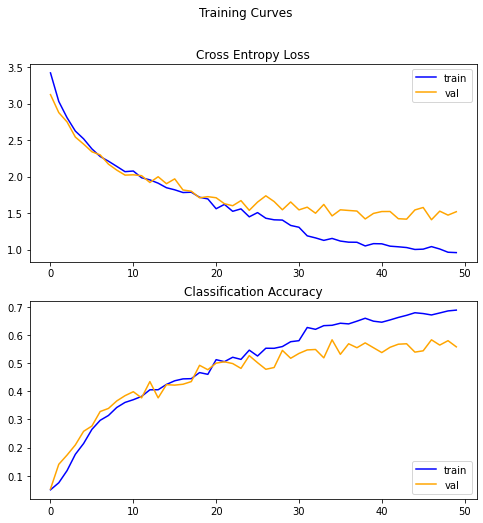


Test set evaluation metrics
10/10 [==============================] - 0s 5ms/step - loss: 1.4232 - accuracy: 0.5844
loss: 1.42
accuracy: 0.58


In [ ]:
THIRD_MODEL_32lr.save("/content/drive/My Drive/NN/Ex3/Models/THIRD_MODEL_lr_32x32.h5")
model_report (THIRD_MODEL_32lr, THIRD_MODEL_32lr_history, 32)

#####Dropout

In [ ]:
def init_third_model_d(summary):
  model = models.Sequential()


  model.add(layers.Conv2D(32, (5, 5),padding='valid',activation='relu', input_shape=(32, 32, 3)))
  model.add(layers.Conv2D(64, (5, 5),padding='valid',activation='relu'))

  model.add(layers.MaxPooling2D(pool_size=(2, 2)))
  model.add(layers.Dropout(rate=0.25))
  
  model.add(layers.Conv2D(64, (3, 3),padding='valid',activation='relu'))
  model.add(layers.Conv2D(64, (3, 3),padding='valid',activation='relu'))
  model.add(layers.Dropout(rate=0.3))
  
  model.add(layers.MaxPooling2D(pool_size=(2, 2)))
  model.add(layers.Dropout(rate=0.25))

  
  model.add(layers.Flatten())
  model.add(layers.Dense(1024, activation='relu'))
  model.add(layers.Dropout(rate=0.4))

  model.add(layers.Dense(512, activation='relu'))
  model.add(layers.Dropout(rate=0.4))
  
  model.add(layers.Dense(100, activation='softmax'))
  
  model.compile(optimizer=tf.optimizers.Adam(), loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=["accuracy"])
  if summary: 
    model.summary()
  return model

In [ ]:
THIRD_MODEL_32d = init_third_model_d(summary = True)
start_time = time.time()

THIRD_MODEL_32d_history = train_model(THIRD_MODEL_32d, 'third_model_32d', 32, 32, 50, 30, 5)
duration = time.time() - start_time
print('Training lasted {} seconds'.format(duration))

Model: "sequential_66"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_225 (Conv2D)          (None, 28, 28, 32)        2432      
_________________________________________________________________
conv2d_226 (Conv2D)          (None, 24, 24, 64)        51264     
_________________________________________________________________
max_pooling2d_145 (MaxPoolin (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_42 (Dropout)         (None, 12, 12, 64)        0         
_________________________________________________________________
conv2d_227 (Conv2D)          (None, 10, 10, 64)        36928     
_________________________________________________________________
conv2d_228 (Conv2D)          (None, 8, 8, 64)          36928     
_________________________________________________________________
dropout_43 (Dropout)         (None, 8, 8, 64)        

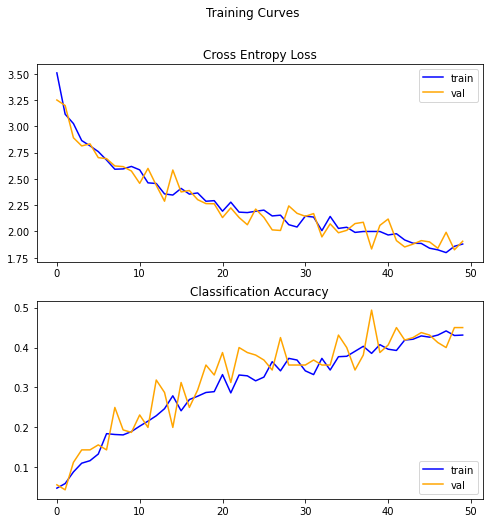


Test set evaluation metrics
10/10 [==============================] - 0s 5ms/step - loss: 1.9070 - accuracy: 0.4258
loss: 1.91
accuracy: 0.43


In [ ]:
THIRD_MODEL_32d.save("/content/drive/My Drive/NN/Ex3/Models/THIRD_MODEL_d_32x32.h5")
model_report (THIRD_MODEL_32d, THIRD_MODEL_32d_history, 32)

#####Data Augmentation

In [ ]:
#DataAugmentation
THIRD_MODEL_32da = init_third_model(summary = True)
start_time = time.time()

THIRD_MODEL_32da_history = train_model(THIRD_MODEL_32da, 'third_model_32_da',32, 32, 50, 30, 5,train_ds_image_gen)
duration = time.time() - start_time
print('Training lasted {} seconds'.format(duration))

Model: "sequential_67"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_229 (Conv2D)          (None, 28, 28, 32)        2432      
_________________________________________________________________
conv2d_230 (Conv2D)          (None, 24, 24, 64)        51264     
_________________________________________________________________
max_pooling2d_147 (MaxPoolin (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_47 (Dropout)         (None, 12, 12, 64)        0         
_________________________________________________________________
conv2d_231 (Conv2D)          (None, 10, 10, 64)        36928     
_________________________________________________________________
conv2d_232 (Conv2D)          (None, 8, 8, 64)          36928     
_________________________________________________________________
dropout_48 (Dropout)         (None, 8, 8, 64)        

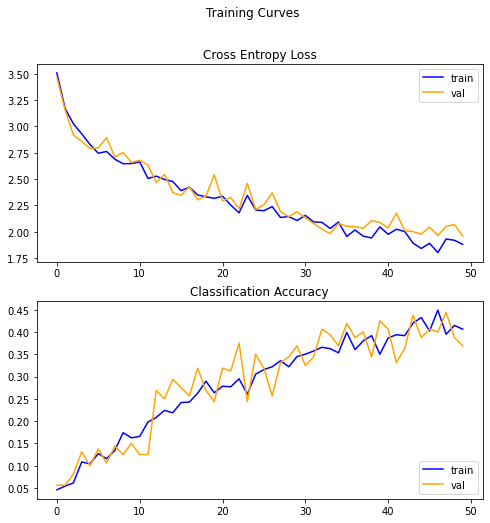


Test set evaluation metrics
10/10 [==============================] - 0s 6ms/step - loss: 1.8720 - accuracy: 0.4320
loss: 1.87
accuracy: 0.43


In [ ]:
THIRD_MODEL_32da.save("/content/drive/My Drive/NN/Ex3/Models/THIRD_MODEL_da_32x32.h5")
model_report (THIRD_MODEL_32da, THIRD_MODEL_32da_history, 32)

#####Resize Input

In [ ]:
def init_third_model82(summary):
  model = models.Sequential()


  model.add(layers.Conv2D(32, (5, 5),padding='valid',activation='relu', input_shape=(82, 82, 3)))
  model.add(layers.Conv2D(64, (5, 5),padding='valid',activation='relu'))

  model.add(layers.MaxPooling2D(pool_size=(2, 2)))
  model.add(layers.Dropout(rate=0.25))
  
  model.add(layers.Conv2D(64, (3, 3),padding='valid',activation='relu'))
  model.add(layers.Conv2D(64, (3, 3),padding='valid',activation='relu'))
  
  model.add(layers.MaxPooling2D(pool_size=(2, 2)))
  model.add(layers.Dropout(rate=0.25))

  
  
  model.add(layers.Flatten())
  model.add(layers.Dense(1024, activation='relu'))
  model.add(layers.Dropout(rate=0.4))

  model.add(layers.Dense(512, activation='relu'))
  model.add(layers.Dropout(rate=0.4))
  
  model.add(layers.Dense(100, activation='softmax'))
  
  model.compile(optimizer=tf.optimizers.Adam(), loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=["accuracy"])
  if summary: 
    model.summary()
  return model

In [ ]:
THIRD_MODEL_82 = init_third_model82(summary = True)
start_time = time.time()

THIRD_MODEL_82_history = train_model(THIRD_MODEL_82, 'second_third_32',82, 32, 50, 30, 5)
duration = time.time() - start_time
print('Training lasted {} seconds'.format(duration))

Model: "sequential_68"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_233 (Conv2D)          (None, 78, 78, 32)        2432      
_________________________________________________________________
conv2d_234 (Conv2D)          (None, 74, 74, 64)        51264     
_________________________________________________________________
max_pooling2d_149 (MaxPoolin (None, 37, 37, 64)        0         
_________________________________________________________________
dropout_52 (Dropout)         (None, 37, 37, 64)        0         
_________________________________________________________________
conv2d_235 (Conv2D)          (None, 35, 35, 64)        36928     
_________________________________________________________________
conv2d_236 (Conv2D)          (None, 33, 33, 64)        36928     
_________________________________________________________________
max_pooling2d_150 (MaxPoolin (None, 16, 16, 64)      

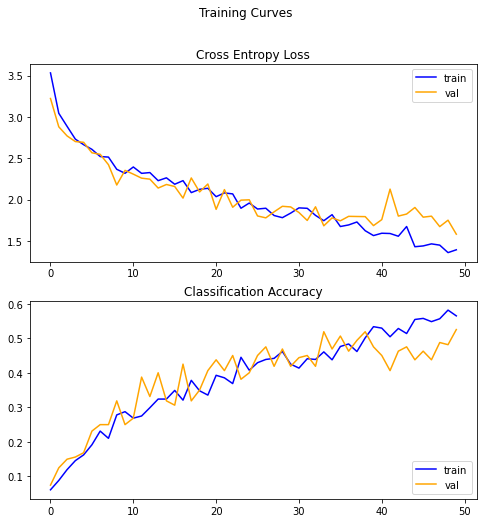


Test set evaluation metrics
10/10 [==============================] - 2s 40ms/step - loss: 1.6279 - accuracy: 0.5063
loss: 1.63
accuracy: 0.51


In [ ]:
THIRD_MODEL_82.save("/content/drive/My Drive/NN/Ex3/Models/THIRD_MODEL_82x82.h5")
model_report (THIRD_MODEL_82,THIRD_MODEL_82_history, 82)

#####Adagrad optimizer

In [ ]:
def init_third_model_op2(summary):
  model = models.Sequential()


  model.add(layers.Conv2D(32, (5, 5),padding='valid',activation='relu', input_shape=(32, 32, 3)))
  model.add(layers.Conv2D(64, (5, 5),padding='valid',activation='relu'))

  model.add(layers.MaxPooling2D(pool_size=(2, 2)))
  model.add(layers.Dropout(rate=0.25))
  
  model.add(layers.Conv2D(64, (3, 3),padding='valid',activation='relu'))
  model.add(layers.Conv2D(64, (3, 3),padding='valid',activation='relu'))
  
  model.add(layers.MaxPooling2D(pool_size=(2, 2)))
  model.add(layers.Dropout(rate=0.25))

  
  
  model.add(layers.Flatten())
  model.add(layers.Dense(1024, activation='relu'))
  model.add(layers.Dropout(rate=0.4))

  model.add(layers.Dense(512, activation='relu'))
  model.add(layers.Dropout(rate=0.4))
  
  model.add(layers.Dense(100, activation='softmax'))
  
  model.compile(optimizer=tf.optimizers.Adagrad(), loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=["accuracy"])
  if summary: 
    model.summary()
  return model
  

In [ ]:
THIRD_MODEL_32_op2 = init_third_model_op2(summary = True)
start_time = time.time()

THIRD_MODEL_32_op2_history = train_model(THIRD_MODEL_32_op2, 'third_model_32_op2',32, 32, 50, 30, 5)
duration = time.time() - start_time
print('Training lasted {} seconds'.format(duration))

Model: "sequential_69"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_237 (Conv2D)          (None, 28, 28, 32)        2432      
_________________________________________________________________
conv2d_238 (Conv2D)          (None, 24, 24, 64)        51264     
_________________________________________________________________
max_pooling2d_151 (MaxPoolin (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_56 (Dropout)         (None, 12, 12, 64)        0         
_________________________________________________________________
conv2d_239 (Conv2D)          (None, 10, 10, 64)        36928     
_________________________________________________________________
conv2d_240 (Conv2D)          (None, 8, 8, 64)          36928     
_________________________________________________________________
max_pooling2d_152 (MaxPoolin (None, 4, 4, 64)        

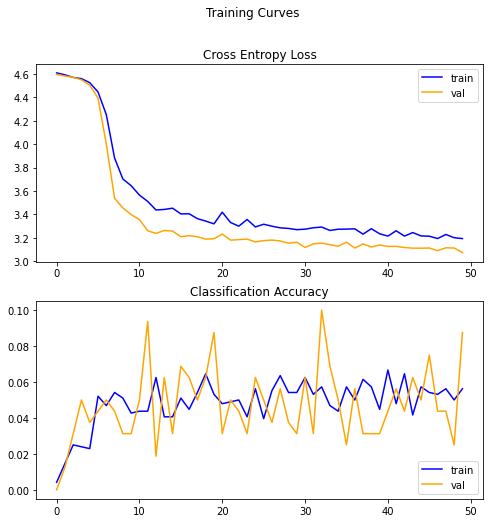


Test set evaluation metrics
10/10 [==============================] - 0s 4ms/step - loss: 3.0881 - accuracy: 0.0594
loss: 3.09
accuracy: 0.06


In [ ]:
THIRD_MODEL_32_op2.save("/content/drive/My Drive/NN/Ex3/Models/THIRD_MODEL_op2_32x32.h5")
model_report (THIRD_MODEL_32_op2,THIRD_MODEL_32_op2_history, 32)

#####RMSprop optimizer

In [ ]:
def init_third_model_op3(summary):
  model = models.Sequential()


  model.add(layers.Conv2D(32, (5, 5),padding='valid',activation='relu', input_shape=(32, 32, 3)))
  model.add(layers.Conv2D(64, (5, 5),padding='valid',activation='relu'))

  model.add(layers.MaxPooling2D(pool_size=(2, 2)))
  model.add(layers.Dropout(rate=0.25))
  
  model.add(layers.Conv2D(64, (3, 3),padding='valid',activation='relu'))
  model.add(layers.Conv2D(64, (3, 3),padding='valid',activation='relu'))
  
  model.add(layers.MaxPooling2D(pool_size=(2, 2)))
  model.add(layers.Dropout(rate=0.25))

  
  model.add(layers.Flatten())
  model.add(layers.Dense(1024, activation='relu'))
  model.add(layers.Dropout(rate=0.4))

  model.add(layers.Dense(512, activation='relu'))
  model.add(layers.Dropout(rate=0.4))
  
  model.add(layers.Dense(100, activation='softmax'))
  
  model.compile(optimizer=tf.optimizers.RMSprop(), loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=["accuracy"])
  if summary: 
    model.summary()
  return model

In [ ]:
THIRD_MODEL_32_op3 = init_third_model_op3(summary = True)
start_time = time.time()

THIRD_MODEL_32_op3_history = train_model(THIRD_MODEL_32_op3, 'third_model_32_op3',32, 32, 50, 30, 5)
duration = time.time() - start_time
print('Training lasted {} seconds'.format(duration))

Model: "sequential_70"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_241 (Conv2D)          (None, 28, 28, 32)        2432      
_________________________________________________________________
conv2d_242 (Conv2D)          (None, 24, 24, 64)        51264     
_________________________________________________________________
max_pooling2d_153 (MaxPoolin (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_60 (Dropout)         (None, 12, 12, 64)        0         
_________________________________________________________________
conv2d_243 (Conv2D)          (None, 10, 10, 64)        36928     
_________________________________________________________________
conv2d_244 (Conv2D)          (None, 8, 8, 64)          36928     
_________________________________________________________________
max_pooling2d_154 (MaxPoolin (None, 4, 4, 64)        

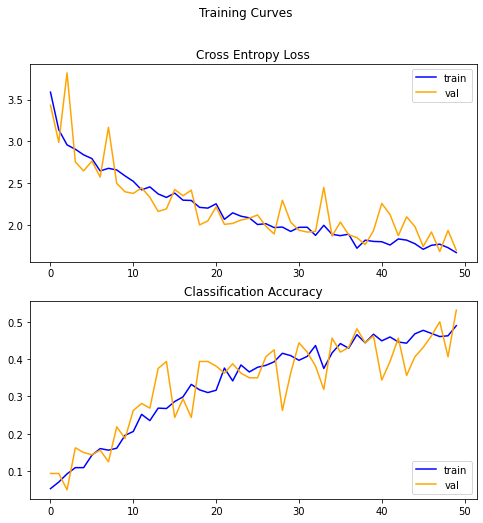


Test set evaluation metrics
10/10 [==============================] - 0s 5ms/step - loss: 1.6853 - accuracy: 0.4891
loss: 1.69
accuracy: 0.49


In [ ]:
THIRD_MODEL_32_op3.save("/content/drive/My Drive/NN/Ex3/Models/THIRD_MODEL_op3_32x32.h5")
model_report (THIRD_MODEL_32_op3,THIRD_MODEL_32_op3_history, 32)

#####Δοκιμή διαφορετικών batch sizes

In [ ]:
#Batch size=64
THIRD_MODEL_32_bs64 = init_third_model(summary = True)
start_time = time.time()

THIRD_MODEL_32_bs64_history = train_model(THIRD_MODEL_32_bs64, 'third_model_32',32, 64, 50, 30, 5)
duration = time.time() - start_time
print('Training lasted {} seconds'.format(duration))

Model: "sequential_71"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_245 (Conv2D)          (None, 28, 28, 32)        2432      
_________________________________________________________________
conv2d_246 (Conv2D)          (None, 24, 24, 64)        51264     
_________________________________________________________________
max_pooling2d_155 (MaxPoolin (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_64 (Dropout)         (None, 12, 12, 64)        0         
_________________________________________________________________
conv2d_247 (Conv2D)          (None, 10, 10, 64)        36928     
_________________________________________________________________
conv2d_248 (Conv2D)          (None, 8, 8, 64)          36928     
_________________________________________________________________
dropout_65 (Dropout)         (None, 8, 8, 64)        

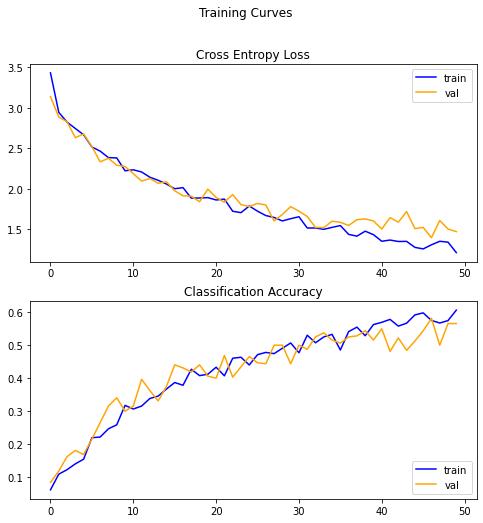


Test set evaluation metrics
10/10 [==============================] - 0s 5ms/step - loss: 1.3572 - accuracy: 0.5656
loss: 1.36
accuracy: 0.57


In [ ]:
THIRD_MODEL_32_bs64.save("/content/drive/My Drive/NN/Ex3/Models/THIRD_MODEL_bs64_32x32.h5")
model_report (THIRD_MODEL_32_bs64,THIRD_MODEL_32_bs64_history, 32)

In [ ]:
#Batch size=128
THIRD_MODEL_32_bs128 = init_third_model(summary = True)
start_time = time.time()

THIRD_MODEL_32_bs128_history = train_model(THIRD_MODEL_32_bs128, 'third_model_bs128',32, 128, 50, 30, 5)
duration = time.time() - start_time
print('Training lasted {} seconds'.format(duration))

Model: "sequential_72"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_249 (Conv2D)          (None, 28, 28, 32)        2432      
_________________________________________________________________
conv2d_250 (Conv2D)          (None, 24, 24, 64)        51264     
_________________________________________________________________
max_pooling2d_157 (MaxPoolin (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_69 (Dropout)         (None, 12, 12, 64)        0         
_________________________________________________________________
conv2d_251 (Conv2D)          (None, 10, 10, 64)        36928     
_________________________________________________________________
conv2d_252 (Conv2D)          (None, 8, 8, 64)          36928     
_________________________________________________________________
dropout_70 (Dropout)         (None, 8, 8, 64)        

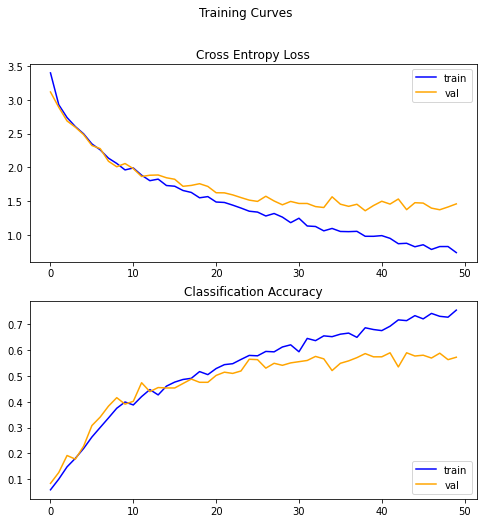


Test set evaluation metrics
10/10 [==============================] - 0s 5ms/step - loss: 1.3639 - accuracy: 0.5977
loss: 1.36
accuracy: 0.60


In [ ]:
THIRD_MODEL_32_bs128.save("/content/drive/My Drive/NN/Ex3/Models/THIRD_MODEL_bs128_32x32.h5")
model_report (THIRD_MODEL_32_bs128,THIRD_MODEL_32_bs128_history, 32)

## Μεταφορά μάθησης

In [ ]:
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.applications.resnet_v2 import ResNet50V2
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.applications.nasnet import NASNetMobile
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications import EfficientNetB4
from tensorflow.keras.applications import EfficientNetB7

from math import ceil

##  XCEPTION

In [ ]:
def init_Xception_model(summary, trainable):
  Xception_MODEL=Xception(input_shape=TARGET_SIZE, include_top=False, weights='imagenet')

  if (trainable == "all"):
    # unfreeze conv layers
    Xception_MODEL.trainable=True
  elif (trainable == "top"):
    Xception_MODEL.trainable=False
  else:
    percentage = float(trainable)/100
    nlayers =  len(Xception_MODEL.layers)
    nfreeze = ceil(nlayers*percentage)

    for layer in Xception_MODEL.layers[:nfreeze]:
	    layer.trainable = False


  dropout_layer = tf.keras.layers.Dropout(rate = 0.5)
  global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

  # add top layer for CIFAR100 classification
  prediction_layer = tf.keras.layers.Dense(len(CIFAR100_LABELS_LIST),activation='softmax')
  model = tf.keras.Sequential([Xception_MODEL, dropout_layer, global_average_layer, prediction_layer])
  model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.00005), loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=["accuracy"])
  if summary: 
    model.summary()
  return model

### Εκπαίδευση όλων των επιπέδων

In [ ]:
Xception_MODEL_all = init_Xception_model(True, "all")
start_time = time.time()

Xception_MODEL_history_all = train_model_TL(Xception_MODEL_all, "Xception_all", 82, 50, 30, 5)
duration = time.time() - start_time
print('Training lasted {} seconds'.format(duration))

Model: "sequential_81"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 3, 3, 2048)        20861480  
_________________________________________________________________
dropout_81 (Dropout)         (None, 3, 3, 2048)        0         
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_194 (Dense)            (None, 100)               204900    
Total params: 21,066,380
Trainable params: 21,011,852
Non-trainable params: 54,528
_________________________________________________________________
Epoch 1/50
30/30 [==============================] - 19s 376ms/step - loss: 4.4483 - accuracy: 0.0639 - val_loss: 3.6593 - val_accuracy: 0.2297
Epoch 2/50
30/30 [==============================] - 10s 344ms/step - loss: 3.6126 - accurac

In [ ]:
Xception_MODEL_all.save("/content/drive/My Drive/NN/Ex3/Models/Xception_all_trainable_82x82.h5")

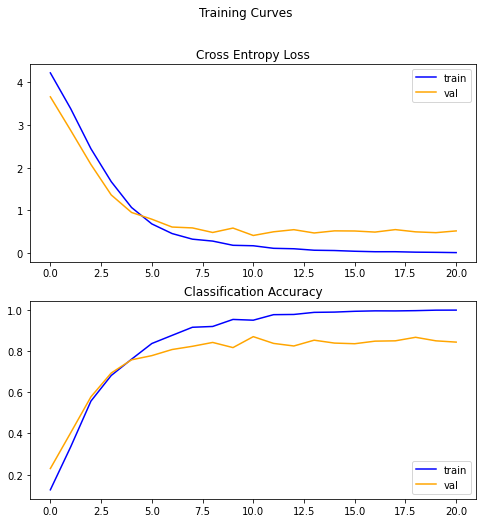


Test set evaluation metrics
10/10 [==============================] - 2s 73ms/step - loss: 0.4826 - accuracy: 0.8594
loss: 0.48
accuracy: 0.86


In [ ]:
model_report(Xception_MODEL_all, Xception_MODEL_history_all, 82)

### Πάγωμα του πρώτου 15% των επιπέδων

In [ ]:
Xception_MODEL_15 = init_Xception_model(summary = True, trainable = "15")
start_time = time.time()

Xception_MODEL_history_15 = train_model_TL(Xception_MODEL_15,"Xception_15", 82, 50, 30, 5)
duration = time.time() - start_time
print('Training lasted {} seconds'.format(duration))

Model: "sequential_82"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 3, 3, 2048)        20861480  
_________________________________________________________________
dropout_82 (Dropout)         (None, 3, 3, 2048)        0         
_________________________________________________________________
global_average_pooling2d_2 ( (None, 2048)              0         
_________________________________________________________________
dense_195 (Dense)            (None, 100)               204900    
Total params: 21,066,380
Trainable params: 20,922,668
Non-trainable params: 143,712
_________________________________________________________________
Epoch 1/50
30/30 [==============================] - 16s 323ms/step - loss: 4.4620 - accuracy: 0.0568 - val_loss: 3.5009 - val_accuracy: 0.2766
Epoch 2/50
30/30 [==============================] - 8s 279ms/step - loss: 3.5380 - accurac

In [ ]:
Xception_MODEL_15.save("/content/drive/My Drive/NN/Ex3/Models/Xception_15_trainable_82x82.h5")

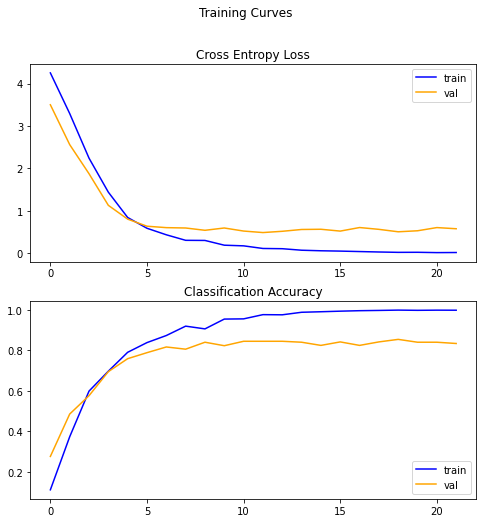


Test set evaluation metrics
10/10 [==============================] - 2s 74ms/step - loss: 0.5612 - accuracy: 0.8234
loss: 0.56
accuracy: 0.82


In [ ]:
model_report(Xception_MODEL_15, Xception_MODEL_history_15, 82)

### Πάγωμα του πρώτου 30% των επιπέδων

In [ ]:
Xception_MODEL_30 = init_Xception_model(summary = True, trainable = "30")
start_time = time.time()

Xception_MODEL_history_30 = train_model_TL(Xception_MODEL_30,"Xception_30", 82, 50, 30, 5)
duration = time.time() - start_time
print('Training lasted {} seconds'.format(duration))

Model: "sequential_83"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 3, 3, 2048)        20861480  
_________________________________________________________________
dropout_83 (Dropout)         (None, 3, 3, 2048)        0         
_________________________________________________________________
global_average_pooling2d_3 ( (None, 2048)              0         
_________________________________________________________________
dense_196 (Dense)            (None, 100)               204900    
Total params: 21,066,380
Trainable params: 19,367,100
Non-trainable params: 1,699,280
_________________________________________________________________
Epoch 1/50
30/30 [==============================] - 15s 283ms/step - loss: 4.4782 - accuracy: 0.0452 - val_loss: 3.6039 - val_accuracy: 0.2547
Epoch 2/50
30/30 [==============================] - 7s 239ms/step - loss: 3.6272 - accur

In [ ]:
Xception_MODEL_30.save("/content/drive/My Drive/NN/Ex3/Models/Xception_30_trainable_82x82.h5")

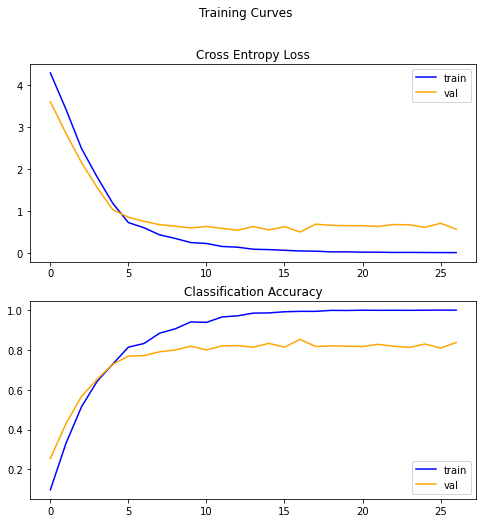


Test set evaluation metrics
10/10 [==============================] - 2s 76ms/step - loss: 0.6118 - accuracy: 0.8164
loss: 0.61
accuracy: 0.82


In [ ]:
model_report(Xception_MODEL_30, Xception_MODEL_history_30, 82)

### Εκπαίδευση μόνο του ανώτερου στρώματος

In [ ]:
Xception_MODEL_top = init_Xception_model(summary = True, trainable = "top")
start_time = time.time()

Xception_MODEL_history_top = train_model_TL(Xception_MODEL_top,"Xception_top", 82, 50, 30, 5)
duration = time.time() - start_time
print('Training lasted {} seconds'.format(duration))

Model: "sequential_84"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 3, 3, 2048)        20861480  
_________________________________________________________________
dropout_84 (Dropout)         (None, 3, 3, 2048)        0         
_________________________________________________________________
global_average_pooling2d_4 ( (None, 2048)              0         
_________________________________________________________________
dense_197 (Dense)            (None, 100)               204900    
Total params: 21,066,380
Trainable params: 204,900
Non-trainable params: 20,861,480
_________________________________________________________________
Epoch 1/50
30/30 [==============================] - 10s 169ms/step - loss: 4.5926 - accuracy: 0.0241 - val_loss: 4.0379 - val_accuracy: 0.0594
Epoch 2/50
30/30 [==============================] - 4s 127ms/step - loss: 3.9077 - accurac

In [ ]:
Xception_MODEL_top.save("/content/drive/My Drive/NN/Ex3/Models/Xception_top_trainable_82x82.h5")

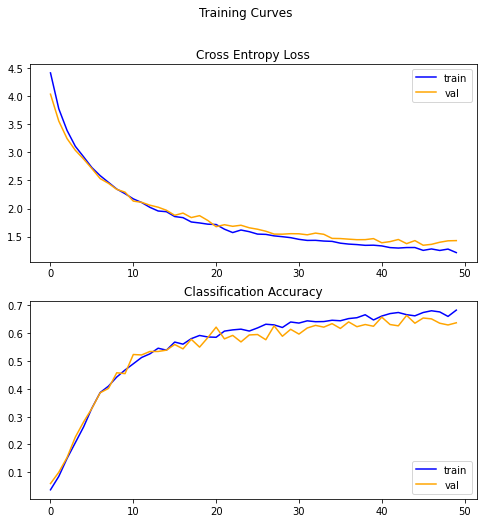


Test set evaluation metrics
10/10 [==============================] - 2s 75ms/step - loss: 1.3058 - accuracy: 0.6594
loss: 1.31
accuracy: 0.66


In [ ]:
model_report(Xception_MODEL_top, Xception_MODEL_history_top, 82)

##  VGG16 

In [ ]:
# transfer learning: VGG16 trained on ImageNet without the top layer

def init_VGG16_model(summary, trainable):
  VGG16_MODEL=VGG16(input_shape=(img_rows, img_cols, img_channels), include_top=False, weights='imagenet')

  if (trainable == "all"):
    # unfreeze conv layers
    VGG16_MODEL.trainable=True
  elif (trainable == "top"):
    VGG16_MODEL.trainable=False
  else:
    percentage = float(trainable)/100
    nlayers =  len(VGG16_MODEL.layers)
    nfreeze = ceil(nlayers*percentage)

    for layer in VGG16_MODEL.layers[:nfreeze]:
	    layer.trainable = False


  dropout_layer = tf.keras.layers.Dropout(rate = 0.5)
  global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

  # add top layer for CIFAR100 classification
  prediction_layer = tf.keras.layers.Dense(len(CIFAR100_LABELS_LIST),activation='softmax')
  model = tf.keras.Sequential([VGG16_MODEL, dropout_layer, global_average_layer, prediction_layer])
  model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.00005), loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=["accuracy"])
  if summary: 
    model.summary()
  return model

### Εκπαίδευση όλων των επιπέδων

In [ ]:
VGG16_MODEL_all = init_VGG16_model( True, "all")
start_time = time.time()

VGG16_MODEL_history_all = train_model_TL(VGG16_MODEL_all, "VGG16_all", 32, 50, 30, 5)
duration = time.time() - start_time
print('Training lasted {} seconds'.format(duration))

58892288/58889256 [==============================] - 1s 0us/step
Model: "sequential_85"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 1, 1, 512)         14714688  
_________________________________________________________________
dropout_85 (Dropout)         (None, 1, 1, 512)         0         
_________________________________________________________________
global_average_pooling2d_5 ( (None, 512)               0         
_________________________________________________________________
dense_198 (Dense)            (None, 100)               51300     
Total params: 14,765,988
Trainable params: 14,765,988
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
30/30 [==============================] - 4s 76ms/step - loss: 4.3467 - accuracy: 0.0709 - val_loss: 2.2397 - val_accuracy: 0.3953
Epoch 2/50
30/30 [===============

In [ ]:
VGG16_MODEL_all.save("/content/drive/My Drive/NN/Ex3/Models/VGG16_all_trainable_32x32.h5")

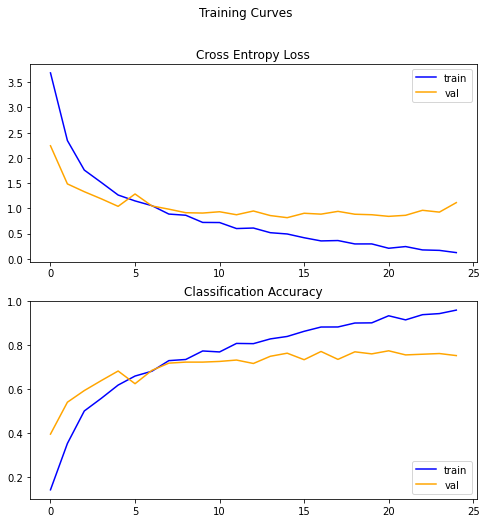


Test set evaluation metrics
10/10 [==============================] - 0s 23ms/step - loss: 0.7802 - accuracy: 0.7461
loss: 0.78
accuracy: 0.75


In [ ]:
model_report(VGG16_MODEL_all, VGG16_MODEL_history_all, 32)

### Πάγωμα του 15% των επιπέδων

In [ ]:
VGG16_MODEL_15 = init_VGG16_model(summary = True, trainable = "15")
start_time = time.time()

VGG16_MODEL_history_15 = train_model_TL(VGG16_MODEL_15,"VGG16_15", 32, 50, 30, 5)
duration = time.time() - start_time
print('Training lasted {} seconds'.format(duration))

Model: "sequential_86"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 1, 1, 512)         14714688  
_________________________________________________________________
dropout_86 (Dropout)         (None, 1, 1, 512)         0         
_________________________________________________________________
global_average_pooling2d_6 ( (None, 512)               0         
_________________________________________________________________
dense_199 (Dense)            (None, 100)               51300     
Total params: 14,765,988
Trainable params: 14,727,268
Non-trainable params: 38,720
_________________________________________________________________
Epoch 1/50
30/30 [==============================] - 3s 65ms/step - loss: 4.2563 - accuracy: 0.0874 - val_loss: 2.3054 - val_accuracy: 0.3750
Epoch 2/50
30/30 [==============================] - 2s 54ms/step - loss: 2.5844 - accuracy: 0

In [ ]:
VGG16_MODEL_15.save("/content/drive/My Drive/NN/Ex3/Models/VGG16_15_trainable_32x32.h5")

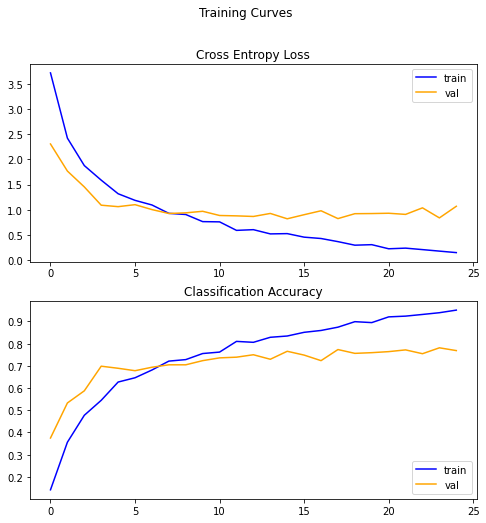


Test set evaluation metrics
10/10 [==============================] - 0s 22ms/step - loss: 0.7920 - accuracy: 0.7570
loss: 0.79
accuracy: 0.76


In [ ]:
model_report(VGG16_MODEL_15, VGG16_MODEL_history_15, 32)

### Πάγωμα του 30% των επιπέδων

In [ ]:
VGG16_MODEL_30 = init_VGG16_model(summary = True, trainable = "30")
start_time = time.time()

VGG16_MODEL_history_30 = train_model_TL(VGG16_MODEL_30,"VGG16_30", 32, 50, 30, 5)
duration = time.time() - start_time
print('Training lasted {} seconds'.format(duration))

Model: "sequential_87"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 1, 1, 512)         14714688  
_________________________________________________________________
dropout_87 (Dropout)         (None, 1, 1, 512)         0         
_________________________________________________________________
global_average_pooling2d_7 ( (None, 512)               0         
_________________________________________________________________
dense_200 (Dense)            (None, 100)               51300     
Total params: 14,765,988
Trainable params: 14,505,828
Non-trainable params: 260,160
_________________________________________________________________
Epoch 1/50
30/30 [==============================] - 3s 61ms/step - loss: 4.2778 - accuracy: 0.0704 - val_loss: 2.0462 - val_accuracy: 0.4359
Epoch 2/50
30/30 [==============================] - 1s 48ms/step - loss: 2.2815 - accuracy: 

In [ ]:
VGG16_MODEL_30.save("/content/drive/My Drive/NN/Ex3/Models/VGG16_30_trainable_32x32.h5")

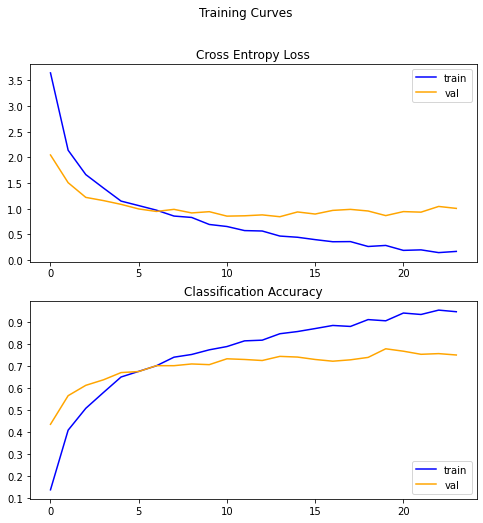


Test set evaluation metrics
10/10 [==============================] - 0s 25ms/step - loss: 0.8177 - accuracy: 0.7383
loss: 0.82
accuracy: 0.74


In [ ]:
model_report(VGG16_MODEL_30, VGG16_MODEL_history_30, 32)

### Εκπαίδευση μόνο του ανώτερου στρώματος

In [ ]:
VGG16_MODEL_top = init_VGG16_model(summary = True, trainable = "top")
start_time = time.time()

VGG16_MODEL_history_top = train_model_TL(VGG16_MODEL_top,"VGG16_top", 32, 50, 30, 5)
duration = time.time() - start_time
print('Training lasted {} seconds'.format(duration))

Model: "sequential_88"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 1, 1, 512)         14714688  
_________________________________________________________________
dropout_88 (Dropout)         (None, 1, 1, 512)         0         
_________________________________________________________________
global_average_pooling2d_8 ( (None, 512)               0         
_________________________________________________________________
dense_201 (Dense)            (None, 100)               51300     
Total params: 14,765,988
Trainable params: 51,300
Non-trainable params: 14,714,688
_________________________________________________________________
Epoch 1/50
30/30 [==============================] - 2s 34ms/step - loss: 5.2921 - accuracy: 0.0040 - val_loss: 4.8954 - val_accuracy: 0.0125
Epoch 2/50
30/30 [==============================] - 1s 22ms/step - loss: 5.0886 - accuracy: 0

In [ ]:
VGG16_MODEL_top.save("/content/drive/My Drive/NN/Ex3/Models/VGG16_top_trainable_32x32.h5")

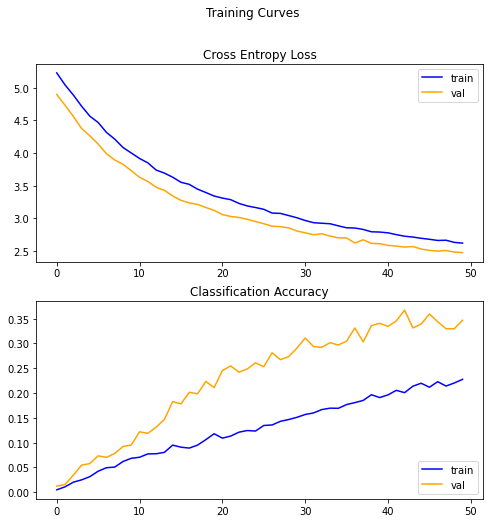


Test set evaluation metrics
10/10 [==============================] - 0s 16ms/step - loss: 2.4580 - accuracy: 0.3469
loss: 2.46
accuracy: 0.35


In [ ]:
model_report(VGG16_MODEL_top, VGG16_MODEL_history_top, 32)

##  VGG19

In [ ]:
# transfer learning: VGG19 trained on ImageNet without the top layer

def init_VGG19_model(summary, trainable):
  VGG19_MODEL=VGG19(input_shape=(img_rows, img_cols, img_channels), include_top=False, weights='imagenet')

  if (trainable == "all"):
    # unfreeze conv layers
    VGG19_MODEL.trainable=True
  elif (trainable == "top"):
    VGG19_MODEL.trainable=False
  else:
    percentage = float(trainable)/100
    nlayers =  len(VGG19_MODEL.layers)
    nfreeze = ceil(nlayers*percentage)

    for layer in VGG19_MODEL.layers[:nfreeze]:
	    layer.trainable = False


  dropout_layer = tf.keras.layers.Dropout(rate = 0.5)
  global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

  # add top layer for CIFAR100 classification
  prediction_layer = tf.keras.layers.Dense(len(CIFAR100_LABELS_LIST),activation='softmax')
  model = tf.keras.Sequential([VGG19_MODEL, dropout_layer, global_average_layer, prediction_layer])
  model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.00005), loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=["accuracy"])
  if summary: 
    model.summary()
  return model

### Εκπαίδευση όλων των επιπέδων

In [ ]:
VGG19_MODEL_all = init_VGG19_model( True, "all")
start_time = time.time()

VGG19_MODEL_history_all = train_model_TL(VGG19_MODEL_all, "VGG19_all", 32, 50, 30, 5)
duration = time.time() - start_time
print('Training lasted {} seconds'.format(duration))

80142336/80134624 [==============================] - 1s 0us/step
Model: "sequential_89"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 1, 1, 512)         20024384  
_________________________________________________________________
dropout_89 (Dropout)         (None, 1, 1, 512)         0         
_________________________________________________________________
global_average_pooling2d_9 ( (None, 512)               0         
_________________________________________________________________
dense_202 (Dense)            (None, 100)               51300     
Total params: 20,075,684
Trainable params: 20,075,684
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
30/30 [==============================] - 4s 89ms/step - loss: 4.3793 - accuracy: 0.0752 - val_loss: 2.2854 - val_accuracy: 0.3688
Epoch 2/50
30/30 [===============

In [ ]:
VGG19_MODEL_all.save("/content/drive/My Drive/NN/Ex3/Models/VGG19_all_trainable_32x32.h5")

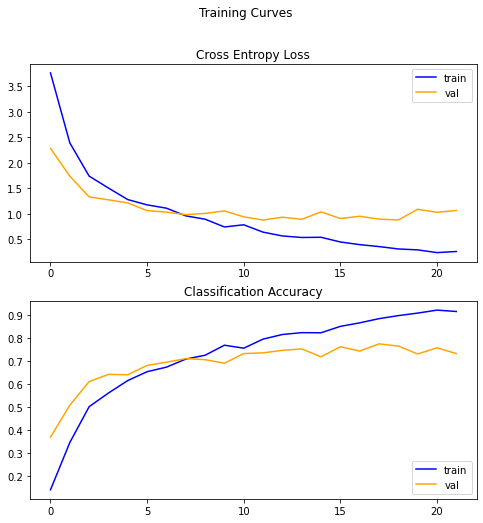


Test set evaluation metrics
10/10 [==============================] - 0s 28ms/step - loss: 0.8507 - accuracy: 0.7258
loss: 0.85
accuracy: 0.73


In [ ]:
model_report(VGG19_MODEL_all, VGG19_MODEL_history_all, 32)

### Πάγωμα του 15% των επιπέδων

In [ ]:
VGG19_MODEL_15 = init_VGG19_model(summary = True, trainable = "15")
start_time = time.time()

VGG19_MODEL_history_15 = train_model_TL(VGG19_MODEL_15,"VGG19_15", 32, 50, 30, 5)
duration = time.time() - start_time
print('Training lasted {} seconds'.format(duration))

Model: "sequential_90"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 1, 1, 512)         20024384  
_________________________________________________________________
dropout_90 (Dropout)         (None, 1, 1, 512)         0         
_________________________________________________________________
global_average_pooling2d_10  (None, 512)               0         
_________________________________________________________________
dense_203 (Dense)            (None, 100)               51300     
Total params: 20,075,684
Trainable params: 20,036,964
Non-trainable params: 38,720
_________________________________________________________________
Epoch 1/50
30/30 [==============================] - 3s 80ms/step - loss: 4.3676 - accuracy: 0.0633 - val_loss: 2.4685 - val_accuracy: 0.2531
Epoch 2/50
30/30 [==============================] - 2s 69ms/step - loss: 2.6869 - accuracy: 0

In [ ]:
VGG19_MODEL_15.save("/content/drive/My Drive/NN/Ex3/Models/VGG19_15_trainable_32x32.h5")

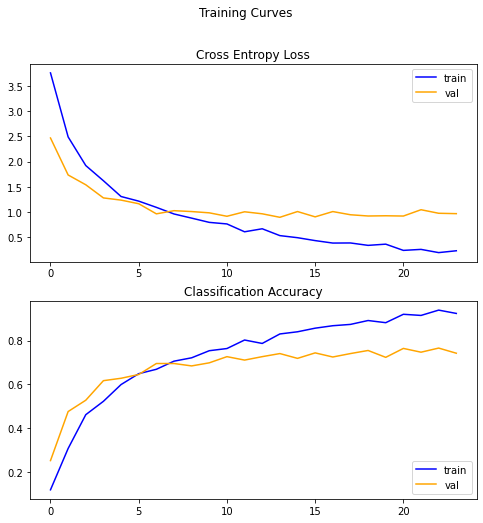


Test set evaluation metrics
10/10 [==============================] - 0s 29ms/step - loss: 0.8237 - accuracy: 0.7641
loss: 0.82
accuracy: 0.76


In [ ]:
model_report(VGG19_MODEL_15, VGG19_MODEL_history_15, 32)

### Πάγωμα του 30% των επιπέδων

In [ ]:
VGG19_MODEL_30 = init_VGG19_model(summary = True, trainable = "30")
start_time = time.time()

VGG19_MODEL_history_30 = train_model_TL(VGG19_MODEL_30,"VGG19_30", 32, 50, 30, 5)
duration = time.time() - start_time
print('Training lasted {} seconds'.format(duration))

Model: "sequential_91"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 1, 1, 512)         20024384  
_________________________________________________________________
dropout_91 (Dropout)         (None, 1, 1, 512)         0         
_________________________________________________________________
global_average_pooling2d_11  (None, 512)               0         
_________________________________________________________________
dense_204 (Dense)            (None, 100)               51300     
Total params: 20,075,684
Trainable params: 19,815,524
Non-trainable params: 260,160
_________________________________________________________________
Epoch 1/50
30/30 [==============================] - 3s 76ms/step - loss: 4.3775 - accuracy: 0.0599 - val_loss: 2.1131 - val_accuracy: 0.3938
Epoch 2/50
30/30 [==============================] - 2s 63ms/step - loss: 2.5303 - accuracy: 

In [ ]:
VGG19_MODEL_30.save("/content/drive/My Drive/NN/Ex3/Models/VGG19_30_trainable_32x32.h5")

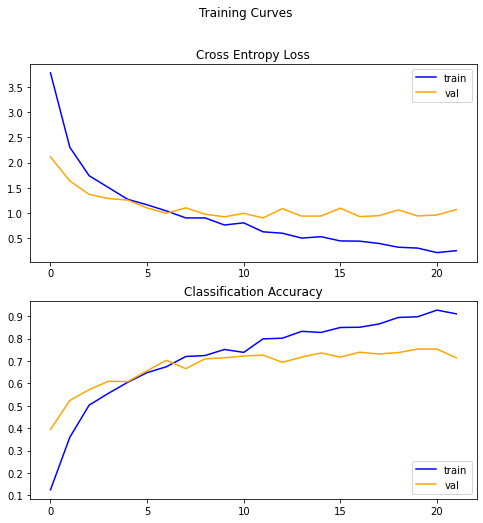


Test set evaluation metrics
10/10 [==============================] - 0s 26ms/step - loss: 0.8870 - accuracy: 0.7148
loss: 0.89
accuracy: 0.71


In [ ]:
model_report(VGG19_MODEL_30, VGG19_MODEL_history_30, 32)

### Εκπαίδευση μόνο του ανώτερου στρώματος

In [ ]:
VGG19_MODEL_top = init_VGG19_model(summary = True, trainable = "top")
start_time = time.time()

VGG19_MODEL_history_top = train_model_TL(VGG19_MODEL_top,"VGG19_top", 32, 50, 30, 5)
duration = time.time() - start_time
print('Training lasted {} seconds'.format(duration))

Model: "sequential_92"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 1, 1, 512)         20024384  
_________________________________________________________________
dropout_92 (Dropout)         (None, 1, 1, 512)         0         
_________________________________________________________________
global_average_pooling2d_12  (None, 512)               0         
_________________________________________________________________
dense_205 (Dense)            (None, 100)               51300     
Total params: 20,075,684
Trainable params: 51,300
Non-trainable params: 20,024,384
_________________________________________________________________
Epoch 1/50
30/30 [==============================] - 2s 38ms/step - loss: 5.2378 - accuracy: 0.0195 - val_loss: 4.8272 - val_accuracy: 0.0281
Epoch 2/50
30/30 [==============================] - 1s 29ms/step - loss: 4.9988 - accuracy: 0

In [ ]:
VGG19_MODEL_top.save("/content/drive/My Drive/NN/Ex3/Models/VGG19_top_trainable_32x32.h5")

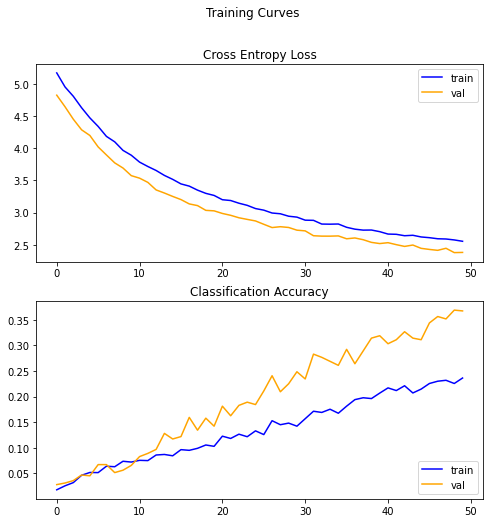


Test set evaluation metrics
10/10 [==============================] - 0s 28ms/step - loss: 2.3842 - accuracy: 0.3547
loss: 2.38
accuracy: 0.35


In [ ]:
model_report(VGG19_MODEL_top, VGG19_MODEL_history_top, 32)

##  ResNet50

In [ ]:
# transfer learning: ResNet50 trained on ImageNet without the top layer

def init_ResNet50_model(summary, trainable):
  ResNet50_MODEL=ResNet50(input_shape=(img_rows, img_cols, img_channels), include_top=False, weights='imagenet')

  if (trainable == "all"):
    # unfreeze conv layers
    ResNet50_MODEL.trainable=True
  elif (trainable == "top"):
    ResNet50_MODEL.trainable=False
  else:
    percentage = float(trainable)/100
    nlayers =  len(ResNet50_MODEL.layers)
    nfreeze = ceil(nlayers*percentage)

    for layer in ResNet50_MODEL.layers[:nfreeze]:
	    layer.trainable = False


  dropout_layer = tf.keras.layers.Dropout(rate = 0.5)
  global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

  # add top layer for CIFAR100 classification
  prediction_layer = tf.keras.layers.Dense(len(CIFAR100_LABELS_LIST),activation='softmax')
  model = tf.keras.Sequential([ResNet50_MODEL, dropout_layer, global_average_layer, prediction_layer])
  model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.00005), loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=["accuracy"])
  if summary: 
    model.summary()
  return model

### Εκπαίδευση όλων των επιπέδων

In [ ]:
ResNet50_MODEL_all = init_ResNet50_model( True, "all")
start_time = time.time()

ResNet50_MODEL_history_all = train_model_TL(ResNet50_MODEL_all, "ResNet50_all", 32, 50, 30, 5)
duration = time.time() - start_time
print('Training lasted {} seconds'.format(duration))

94773248/94765736 [==============================] - 1s 0us/step
Model: "sequential_93"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 1, 1, 2048)        23587712  
_________________________________________________________________
dropout_93 (Dropout)         (None, 1, 1, 2048)        0         
_________________________________________________________________
global_average_pooling2d_13  (None, 2048)              0         
_________________________________________________________________
dense_206 (Dense)            (None, 100)               204900    
Total params: 23,792,612
Trainable params: 23,739,492
Non-trainable params: 53,120
_________________________________________________________________
Epoch 1/50
30/30 [==============================] - 10s 120ms/step - loss: 7.1800 - accuracy: 0.0247 - val_loss: 8.9118 - val_accuracy: 0.0031
Epoch 2/50
30/30 [========

In [ ]:
ResNet50_MODEL_all.save("/content/drive/My Drive/NN/Ex3/Models/ResNet50_all_trainable_32x32.h5")

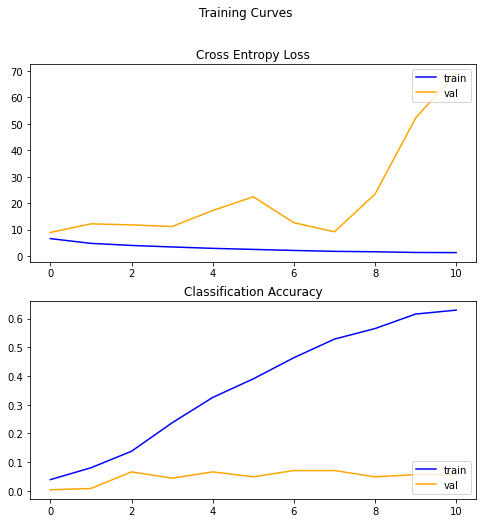


Test set evaluation metrics
10/10 [==============================] - 0s 28ms/step - loss: 8.6537 - accuracy: 0.0039
loss: 8.65
accuracy: 0.00


In [ ]:
model_report(ResNet50_MODEL_all, ResNet50_MODEL_history_all, 32)

### Πάγωμα του 15% των επιπέδων

In [ ]:
ResNet50_MODEL_15 = init_ResNet50_model(summary = True, trainable = "15")
start_time = time.time()

ResNet50_MODEL_history_15 = train_model_TL(ResNet50_MODEL_15,"ResNet50_15", 32, 50, 30, 5)
duration = time.time() - start_time
print('Training lasted {} seconds'.format(duration))

Model: "sequential_94"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 1, 1, 2048)        23587712  
_________________________________________________________________
dropout_94 (Dropout)         (None, 1, 1, 2048)        0         
_________________________________________________________________
global_average_pooling2d_14  (None, 2048)              0         
_________________________________________________________________
dense_207 (Dense)            (None, 100)               204900    
Total params: 23,792,612
Trainable params: 23,583,460
Non-trainable params: 209,152
_________________________________________________________________
Epoch 1/50
30/30 [==============================] - 8s 130ms/step - loss: 7.2303 - accuracy: 0.0099 - val_loss: 7.4028 - val_accuracy: 0.0734
Epoch 2/50
30/30 [==============================] - 2s 68ms/step - loss: 5.9148 - accuracy:

In [ ]:
ResNet50_MODEL_15.save("/content/drive/My Drive/NN/Ex3/Models/ResNet50_15_trainable_32x32.h5")

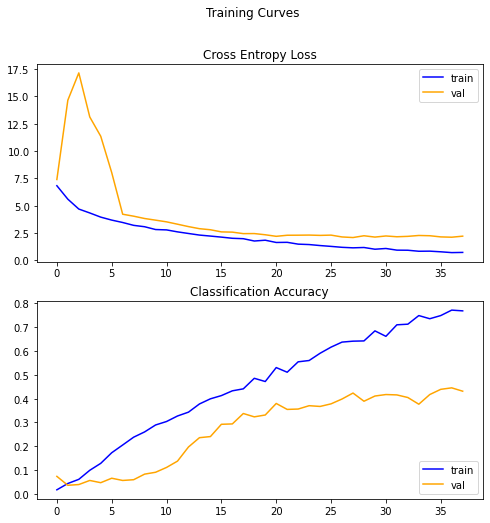


Test set evaluation metrics
10/10 [==============================] - 0s 27ms/step - loss: 2.2209 - accuracy: 0.3953
loss: 2.22
accuracy: 0.40


In [ ]:
model_report(ResNet50_MODEL_15, ResNet50_MODEL_history_15, 32)

### Πάγωμα του 30% των επιπέδων

In [ ]:
ResNet50_MODEL_30 = init_ResNet50_model(summary = True, trainable = "30")
start_time = time.time()

ResNet50_MODEL_history_30 = train_model_TL(ResNet50_MODEL_30,"ResNet50_30", 32, 50, 30, 5)
duration = time.time() - start_time
print('Training lasted {} seconds'.format(duration))

Model: "sequential_95"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 1, 1, 2048)        23587712  
_________________________________________________________________
dropout_95 (Dropout)         (None, 1, 1, 2048)        0         
_________________________________________________________________
global_average_pooling2d_15  (None, 2048)              0         
_________________________________________________________________
dense_208 (Dense)            (None, 100)               204900    
Total params: 23,792,612
Trainable params: 23,066,084
Non-trainable params: 726,528
_________________________________________________________________
Epoch 1/50
30/30 [==============================] - 8s 133ms/step - loss: 6.3702 - accuracy: 0.0169 - val_loss: 5.0487 - val_accuracy: 0.0000e+00
Epoch 2/50
30/30 [==============================] - 2s 63ms/step - loss: 5.0671 - accur

In [ ]:
ResNet50_MODEL_30.save("/content/drive/My Drive/NN/Ex3/Models/ResNet50_30_trainable_32x32.h5")

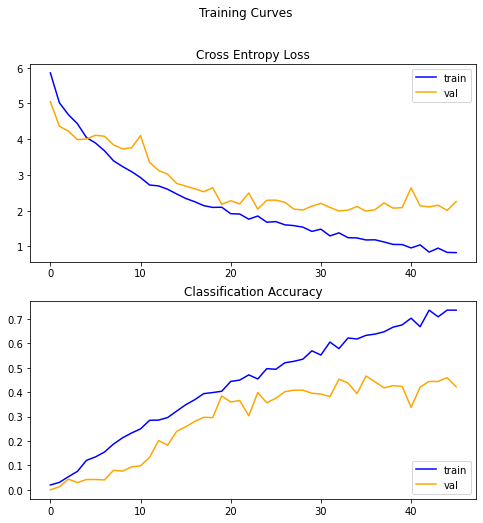


Test set evaluation metrics
10/10 [==============================] - 0s 26ms/step - loss: 2.1048 - accuracy: 0.4211
loss: 2.10
accuracy: 0.42


In [ ]:
model_report(ResNet50_MODEL_30, ResNet50_MODEL_history_30, 32)

### Εκπαίδευση μόνο του ανώτερου στρώματος

In [ ]:
ResNet50_MODEL_top = init_ResNet50_model(summary = True, trainable = "top")
start_time = time.time()

ResNet50_MODEL_history_top = train_model_TL(ResNet50_MODEL_top,"ResNet50_top", 32, 50, 30, 5)
duration = time.time() - start_time
print('Training lasted {} seconds'.format(duration))

Model: "sequential_96"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 1, 1, 2048)        23587712  
_________________________________________________________________
dropout_96 (Dropout)         (None, 1, 1, 2048)        0         
_________________________________________________________________
global_average_pooling2d_16  (None, 2048)              0         
_________________________________________________________________
dense_209 (Dense)            (None, 100)               204900    
Total params: 23,792,612
Trainable params: 204,900
Non-trainable params: 23,587,712
_________________________________________________________________
Epoch 1/50
30/30 [==============================] - 5s 81ms/step - loss: 7.8393 - accuracy: 0.0039 - val_loss: 5.2884 - val_accuracy: 0.0000e+00
Epoch 2/50
30/30 [==============================] - 1s 27ms/step - loss: 6.4439 - accura

In [ ]:
ResNet50_MODEL_top.save("/content/drive/My Drive/NN/Ex3/Models/ResNet50_top_trainable_32x32.h5")

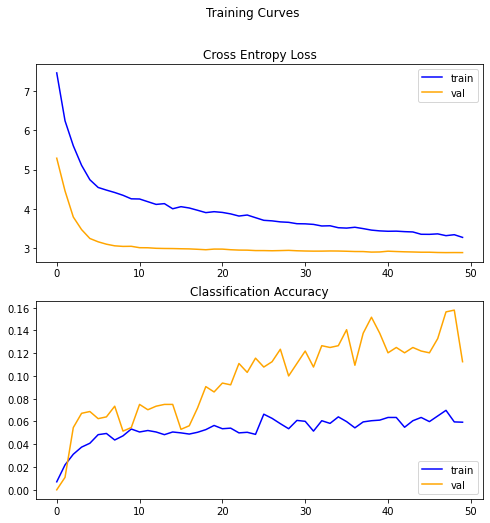


Test set evaluation metrics
10/10 [==============================] - 0s 26ms/step - loss: 2.8838 - accuracy: 0.1336
loss: 2.88
accuracy: 0.13


In [ ]:
model_report(ResNet50_MODEL_top, ResNet50_MODEL_history_top, 32)

##  ResNet50V2

In [ ]:
# transfer learning: ResNet50V2 trained on ImageNet without the top layer

def init_ResNet50V2_model(summary, trainable):
  ResNet50V2_MODEL=ResNet50V2(input_shape=(img_rows, img_cols, img_channels), include_top=False, weights='imagenet')

  if (trainable == "all"):
    # unfreeze conv layers
    ResNet50V2_MODEL.trainable=True
  elif (trainable == "top"):
    ResNet50V2_MODEL.trainable=False
  else:
    percentage = float(trainable)/100
    nlayers =  len(ResNet50V2_MODEL.layers)
    nfreeze = ceil(nlayers*percentage)

    for layer in ResNet50V2_MODEL.layers[:nfreeze]:
	    layer.trainable = False


  dropout_layer = tf.keras.layers.Dropout(rate = 0.5)
  global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

  # add top layer for CIFAR100 classification
  prediction_layer = tf.keras.layers.Dense(len(CIFAR100_LABELS_LIST),activation='softmax')
  model = tf.keras.Sequential([ResNet50V2_MODEL, dropout_layer, global_average_layer, prediction_layer])
  model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.00005), loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=["accuracy"])
  if summary: 
    model.summary()
  return model

### Εκπαίδευση όλων των επιπέδων

In [ ]:
ResNet50V2_MODEL_all = init_ResNet50V2_model( True, "all")
start_time = time.time()

ResNet50V2_MODEL_history_all = train_model_TL(ResNet50V2_MODEL_all, "ResNet50V2_all", 32, 50, 30, 5)
duration = time.time() - start_time
print('Training lasted {} seconds'.format(duration))

94674944/94668760 [==============================] - 1s 0us/step
Model: "sequential_97"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Functional)      (None, 1, 1, 2048)        23564800  
_________________________________________________________________
dropout_97 (Dropout)         (None, 1, 1, 2048)        0         
_________________________________________________________________
global_average_pooling2d_17  (None, 2048)              0         
_________________________________________________________________
dense_210 (Dense)            (None, 100)               204900    
Total params: 23,769,700
Trainable params: 23,724,260
Non-trainable params: 45,440
_________________________________________________________________
Epoch 1/50
30/30 [==============================] - 9s 108ms/step - loss: 5.4541 - accuracy: 0.0077 - val_loss: 4.6340 - val_accuracy: 0.0125
Epoch 2/50
30/30 [=========

In [ ]:
ResNet50V2_MODEL_all.save("/content/drive/My Drive/NN/Ex3/Models/ResNet50V2_all_trainable_32x32.h5")

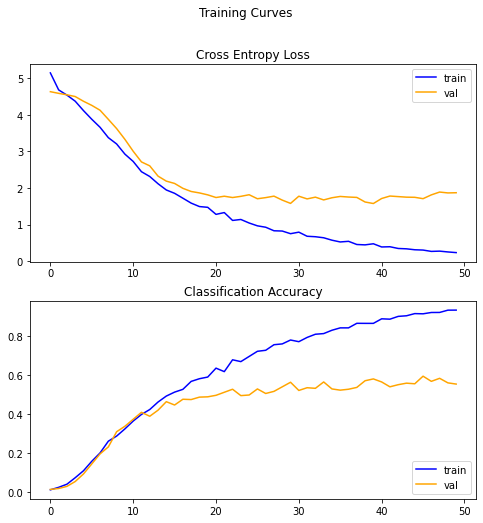


Test set evaluation metrics
10/10 [==============================] - 0s 24ms/step - loss: 1.6328 - accuracy: 0.5797
loss: 1.63
accuracy: 0.58


In [ ]:
model_report(ResNet50V2_MODEL_all, ResNet50V2_MODEL_history_all, 32)

### Πάγωμα του 15% των επιπέδων

In [ ]:
ResNet50V2_MODEL_15 = init_ResNet50V2_model(summary = True, trainable = "15")
start_time = time.time()

ResNet50V2_MODEL_history_15 = train_model_TL(ResNet50V2_MODEL_15,"ResNet50V2_15", 32, 50, 30, 5)
duration = time.time() - start_time
print('Training lasted {} seconds'.format(duration))

Model: "sequential_98"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Functional)      (None, 1, 1, 2048)        23564800  
_________________________________________________________________
dropout_98 (Dropout)         (None, 1, 1, 2048)        0         
_________________________________________________________________
global_average_pooling2d_18  (None, 2048)              0         
_________________________________________________________________
dense_211 (Dense)            (None, 100)               204900    
Total params: 23,769,700
Trainable params: 23,568,996
Non-trainable params: 200,704
_________________________________________________________________
Epoch 1/50
30/30 [==============================] - 8s 115ms/step - loss: 5.2549 - accuracy: 0.0186 - val_loss: 4.6118 - val_accuracy: 0.0109
Epoch 2/50
30/30 [==============================] - 2s 60ms/step - loss: 4.6317 - accuracy:

In [ ]:
ResNet50V2_MODEL_15.save("/content/drive/My Drive/NN/Ex3/Models/ResNet50V2_15_trainable_32x32.h5")

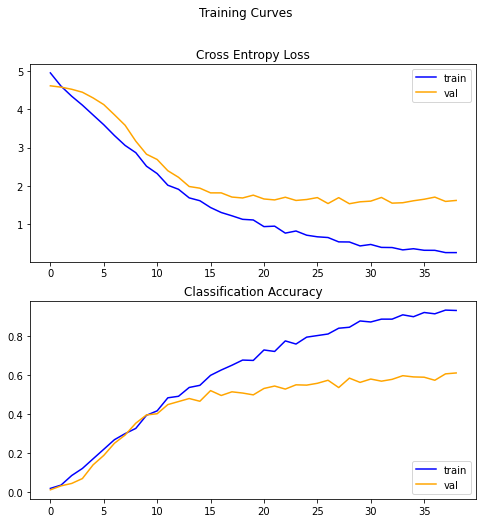


Test set evaluation metrics
10/10 [==============================] - 0s 27ms/step - loss: 1.5587 - accuracy: 0.5734
loss: 1.56
accuracy: 0.57


In [ ]:
model_report(ResNet50V2_MODEL_15, ResNet50V2_MODEL_history_15, 32)

### Πάγωμα του 30% των επιπέδων

In [ ]:
ResNet50V2_MODEL_30 = init_ResNet50V2_model(summary = True, trainable = "30")
start_time = time.time()

ResNet50V2_MODEL_history_30 = train_model_TL(ResNet50V2_MODEL_30,"ResNet50V2_30", 32, 50, 30, 5)
duration = time.time() - start_time
print('Training lasted {} seconds'.format(duration))

Model: "sequential_99"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Functional)      (None, 1, 1, 2048)        23564800  
_________________________________________________________________
dropout_99 (Dropout)         (None, 1, 1, 2048)        0         
_________________________________________________________________
global_average_pooling2d_19  (None, 2048)              0         
_________________________________________________________________
dense_212 (Dense)            (None, 100)               204900    
Total params: 23,769,700
Trainable params: 23,053,156
Non-trainable params: 716,544
_________________________________________________________________
Epoch 1/50
30/30 [==============================] - 7s 118ms/step - loss: 5.3155 - accuracy: 0.0108 - val_loss: 4.6093 - val_accuracy: 0.0078
Epoch 2/50
30/30 [==============================] - 2s 57ms/step - loss: 4.6517 - accuracy:

In [ ]:
ResNet50V2_MODEL_30.save("/content/drive/My Drive/NN/Ex3/Models/ResNet50V2_30_trainable_32x32.h5")

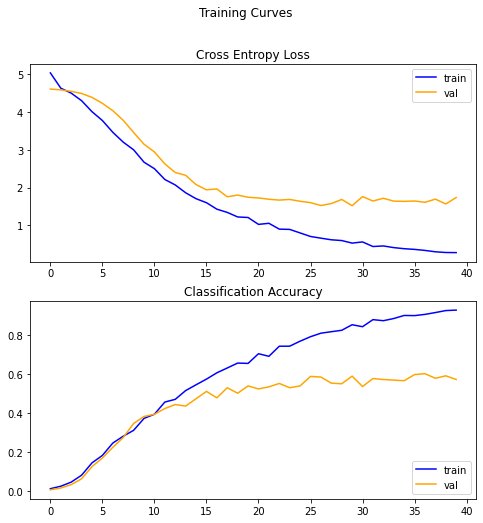


Test set evaluation metrics
10/10 [==============================] - 0s 24ms/step - loss: 1.6398 - accuracy: 0.5688
loss: 1.64
accuracy: 0.57


In [ ]:
model_report(ResNet50V2_MODEL_30, ResNet50V2_MODEL_history_30, 32)

### Εκπαίδευση μόνο του ανώτερου στρώματος

In [ ]:
ResNet50V2_MODEL_top = init_ResNet50V2_model(summary = True, trainable = "top")
start_time = time.time()

ResNet50V2_MODEL_history_top = train_model_TL(ResNet50V2_MODEL_top,"ResNet50V2_top", 32, 50, 30, 5)
duration = time.time() - start_time
print('Training lasted {} seconds'.format(duration))

Model: "sequential_100"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Functional)      (None, 1, 1, 2048)        23564800  
_________________________________________________________________
dropout_100 (Dropout)        (None, 1, 1, 2048)        0         
_________________________________________________________________
global_average_pooling2d_20  (None, 2048)              0         
_________________________________________________________________
dense_213 (Dense)            (None, 100)               204900    
Total params: 23,769,700
Trainable params: 204,900
Non-trainable params: 23,564,800
_________________________________________________________________
Epoch 1/50
30/30 [==============================] - 4s 69ms/step - loss: 4.7317 - accuracy: 0.0113 - val_loss: 4.6379 - val_accuracy: 0.0141
Epoch 2/50
30/30 [==============================] - 1s 28ms/step - loss: 4.6826 - accuracy:

In [ ]:
ResNet50V2_MODEL_top.save("/content/drive/My Drive/NN/Ex3/Models/ResNet50V2_top_trainable_32x32.h5")

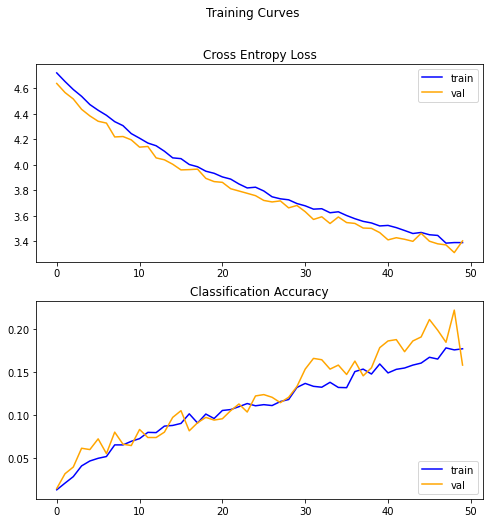


Test set evaluation metrics
10/10 [==============================] - 0s 23ms/step - loss: 3.3225 - accuracy: 0.2156
loss: 3.32
accuracy: 0.22


In [ ]:
model_report(ResNet50V2_MODEL_top, ResNet50V2_MODEL_history_top, 32)

##  InceptionV3

In [ ]:
# transfer learning: InceptionV3 trained on ImageNet without the top layer

def init_InceptionV3_model(summary, trainable):
  InceptionV3_MODEL=InceptionV3(input_shape=TARGET_SIZE, include_top=False, weights='imagenet')

  if (trainable == "all"):
    # unfreeze conv layers
    InceptionV3_MODEL.trainable=True
  elif (trainable == "top"):
    InceptionV3_MODEL.trainable=False
  else:
    percentage = float(trainable)/100
    nlayers =  len(InceptionV3_MODEL.layers)
    nfreeze = ceil(nlayers*percentage)

    for layer in InceptionV3_MODEL.layers[:nfreeze]:
	    layer.trainable = False


  dropout_layer = tf.keras.layers.Dropout(rate = 0.5)
  global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

  # add top layer for CIFAR100 classification
  prediction_layer = tf.keras.layers.Dense(len(CIFAR100_LABELS_LIST),activation='softmax')
  model = tf.keras.Sequential([InceptionV3_MODEL, dropout_layer, global_average_layer, prediction_layer])
  model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.00005), loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=["accuracy"])
  if summary: 
    model.summary()
  return model

### Εκπαίδευση όλων των επιπέδων

In [ ]:
InceptionV3_MODEL_all = init_InceptionV3_model( True, "all")
start_time = time.time()

InceptionV3_MODEL_history_all = train_model_TL(InceptionV3_MODEL_all, "InceptionV3_all", 82, 50, 30, 5)
duration = time.time() - start_time
print('Training lasted {} seconds'.format(duration))

87916544/87910968 [==============================] - 0s 0us/step
Model: "sequential_101"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 1, 1, 2048)        21802784  
_________________________________________________________________
dropout_101 (Dropout)        (None, 1, 1, 2048)        0         
_________________________________________________________________
global_average_pooling2d_21  (None, 2048)              0         
_________________________________________________________________
dense_214 (Dense)            (None, 100)               204900    
Total params: 22,007,684
Trainable params: 21,973,252
Non-trainable params: 34,432
_________________________________________________________________
Epoch 1/50
30/30 [==============================] - 17s 233ms/step - loss: 4.6235 - accuracy: 0.0297 - val_loss: 4.1836 - val_accuracy: 0.0859
Epoch 2/50
30/30 [=======

In [ ]:
InceptionV3_MODEL_all.save("/content/drive/My Drive/NN/Ex3/Models/InceptionV3_all_trainable_82x82.h5")

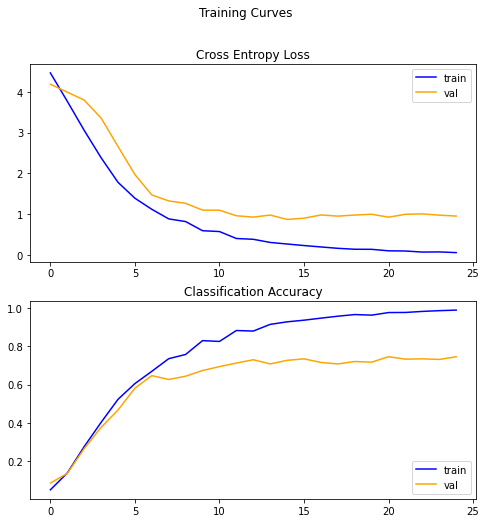


Test set evaluation metrics
10/10 [==============================] - 2s 46ms/step - loss: 0.8889 - accuracy: 0.7258
loss: 0.89
accuracy: 0.73


In [ ]:
model_report(InceptionV3_MODEL_all, InceptionV3_MODEL_history_all, 82)

### Πάγωμα του 15% των επιπέδων

In [ ]:
InceptionV3_MODEL_15 = init_InceptionV3_model(summary = True, trainable = "15")
start_time = time.time()

InceptionV3_MODEL_history_15 = train_model_TL(InceptionV3_MODEL_15,"InceptionV3_15", 82, 50, 30, 5)
duration = time.time() - start_time
print('Training lasted {} seconds'.format(duration))

Model: "sequential_102"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 1, 1, 2048)        21802784  
_________________________________________________________________
dropout_102 (Dropout)        (None, 1, 1, 2048)        0         
_________________________________________________________________
global_average_pooling2d_22  (None, 2048)              0         
_________________________________________________________________
dense_215 (Dense)            (None, 100)               204900    
Total params: 22,007,684
Trainable params: 21,461,460
Non-trainable params: 546,224
_________________________________________________________________
Epoch 1/50
30/30 [==============================] - 15s 203ms/step - loss: 4.6255 - accuracy: 0.0296 - val_loss: 4.1242 - val_accuracy: 0.1312
Epoch 2/50
30/30 [==============================] - 4s 137ms/step - loss: 3.8528 - accura

In [ ]:
InceptionV3_MODEL_15.save("/content/drive/My Drive/NN/Ex3/Models/InceptionV3_15_trainable_82x82.h5")

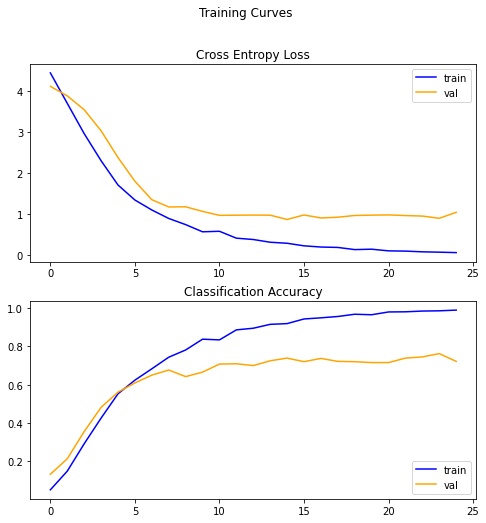


Test set evaluation metrics
10/10 [==============================] - 2s 42ms/step - loss: 0.9896 - accuracy: 0.7180
loss: 0.99
accuracy: 0.72


In [ ]:
model_report(InceptionV3_MODEL_15, InceptionV3_MODEL_history_15, 82)

### Πάγωμα του 30% των επιπέδων

In [ ]:
InceptionV3_MODEL_30 = init_InceptionV3_model(summary = True, trainable = "30")
start_time = time.time()

InceptionV3_MODEL_history_30 = train_model_TL(InceptionV3_MODEL_30,"InceptionV3_30", 82, 50, 30, 5)
duration = time.time() - start_time
print('Training lasted {} seconds'.format(duration))

Model: "sequential_103"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 1, 1, 2048)        21802784  
_________________________________________________________________
dropout_103 (Dropout)        (None, 1, 1, 2048)        0         
_________________________________________________________________
global_average_pooling2d_23  (None, 2048)              0         
_________________________________________________________________
dense_216 (Dense)            (None, 100)               204900    
Total params: 22,007,684
Trainable params: 19,914,692
Non-trainable params: 2,092,992
_________________________________________________________________
Epoch 1/50
30/30 [==============================] - 14s 199ms/step - loss: 4.7013 - accuracy: 0.0209 - val_loss: 4.3491 - val_accuracy: 0.0781
Epoch 2/50
30/30 [==============================] - 4s 127ms/step - loss: 4.0504 - accu

In [ ]:
InceptionV3_MODEL_30.save("/content/drive/My Drive/NN/Ex3/Models/InceptionV3_30_trainable_82x82.h5")

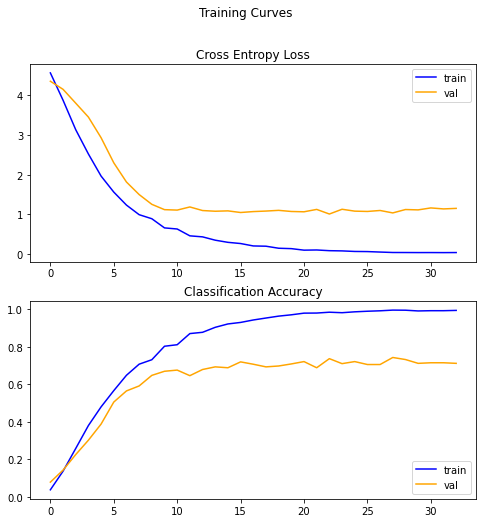


Test set evaluation metrics
10/10 [==============================] - 2s 44ms/step - loss: 1.1101 - accuracy: 0.7016
loss: 1.11
accuracy: 0.70


In [ ]:
model_report(InceptionV3_MODEL_30, InceptionV3_MODEL_history_30, 82)

### Εκπαίδευση μόνο του ανώτερου στρώματος

In [ ]:
InceptionV3_MODEL_top = init_InceptionV3_model(summary = True, trainable = "top")
start_time = time.time()

InceptionV3_MODEL_history_top = train_model_TL(InceptionV3_MODEL_top,"InceptionV3_top", 82, 50, 30, 5)
duration = time.time() - start_time
print('Training lasted {} seconds'.format(duration))

Model: "sequential_104"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 1, 1, 2048)        21802784  
_________________________________________________________________
dropout_104 (Dropout)        (None, 1, 1, 2048)        0         
_________________________________________________________________
global_average_pooling2d_24  (None, 2048)              0         
_________________________________________________________________
dense_217 (Dense)            (None, 100)               204900    
Total params: 22,007,684
Trainable params: 204,900
Non-trainable params: 21,802,784
_________________________________________________________________
Epoch 1/50
30/30 [==============================] - 11s 167ms/step - loss: 5.2734 - accuracy: 0.0153 - val_loss: 4.4084 - val_accuracy: 0.0406
Epoch 2/50
30/30 [==============================] - 3s 103ms/step - loss: 4.7445 - accura

In [ ]:
InceptionV3_MODEL_top.save("/content/drive/My Drive/NN/Ex3/Models/InceptionV3_top_trainable_82x82.h5")

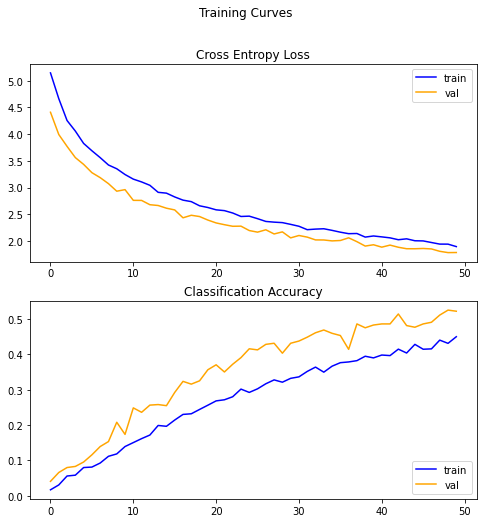


Test set evaluation metrics
10/10 [==============================] - 2s 44ms/step - loss: 1.7652 - accuracy: 0.5023
loss: 1.77
accuracy: 0.50


In [ ]:
model_report(InceptionV3_MODEL_top, InceptionV3_MODEL_history_top, 82)

##  InceptionResNetV2

In [ ]:
# transfer learning: InceptionResNetV2 trained on ImageNet without the top layer

def init_InceptionResNetV2_model(summary, trainable):
  InceptionResNetV2_MODEL=InceptionResNetV2(input_shape=TARGET_SIZE, include_top=False, weights='imagenet')

  if (trainable == "all"):
    # unfreeze conv layers
    InceptionResNetV2_MODEL.trainable=True
  elif (trainable == "top"):
    InceptionResNetV2_MODEL.trainable=False
  else:
    percentage = float(trainable)/100
    nlayers =  len(InceptionResNetV2_MODEL.layers)
    nfreeze = ceil(nlayers*percentage)

    for layer in InceptionResNetV2_MODEL.layers[:nfreeze]:
	    layer.trainable = False


  dropout_layer = tf.keras.layers.Dropout(rate = 0.5)
  global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

  # add top layer for CIFAR100 classification
  prediction_layer = tf.keras.layers.Dense(len(CIFAR100_LABELS_LIST),activation='softmax')
  model = tf.keras.Sequential([InceptionResNetV2_MODEL, dropout_layer, global_average_layer, prediction_layer])
  model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.00005), loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=["accuracy"])
  if summary: 
    model.summary()
  return model

### Εκπαίδευση όλων των επιπέδων

In [ ]:
InceptionResNetV2_MODEL_all = init_InceptionResNetV2_model( True, "all")
start_time = time.time()

InceptionResNetV2_MODEL_history_all = train_model_TL(InceptionResNetV2_MODEL_all, "InceptionResNetV2_all", 82, 50, 30, 5)
duration = time.time() - start_time
print('Training lasted {} seconds'.format(duration))

219062272/219055592 [==============================] - 2s 0us/step
Model: "sequential_105"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Functio (None, 1, 1, 1536)        54336736  
_________________________________________________________________
dropout_105 (Dropout)        (None, 1, 1, 1536)        0         
_________________________________________________________________
global_average_pooling2d_25  (None, 1536)              0         
_________________________________________________________________
dense_218 (Dense)            (None, 100)               153700    
Total params: 54,490,436
Trainable params: 54,429,892
Non-trainable params: 60,544
_________________________________________________________________
Epoch 1/50
30/30 [==============================] - 32s 444ms/step - loss: 4.7565 - accuracy: 0.0352 - val_loss: 3.9791 - val_accuracy: 0.1234
Epoch 2/50
30/30 [=====

In [ ]:
InceptionResNetV2_MODEL_all.save("/content/drive/My Drive/NN/Ex3/Models/InceptionResNetV2_all_trainable_82x82.h5")

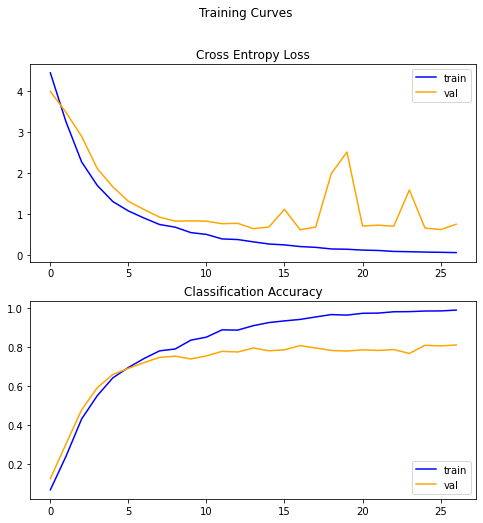


Test set evaluation metrics
10/10 [==============================] - 3s 76ms/step - loss: 1.5378 - accuracy: 0.7758
loss: 1.54
accuracy: 0.78


In [ ]:
model_report(InceptionResNetV2_MODEL_all, InceptionResNetV2_MODEL_history_all, 82)

### Πάγωμα του 15% των επιπέδων

In [ ]:
InceptionResNetV2_MODEL_15 = init_InceptionResNetV2_model(summary = True, trainable = "15")
start_time = time.time()

InceptionResNetV2_MODEL_history_15 = train_model_TL(InceptionResNetV2_MODEL_15,"InceptionResNetV2_15", 82, 50, 30, 5)
duration = time.time() - start_time
print('Training lasted {} seconds'.format(duration))

Model: "sequential_106"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Functio (None, 1, 1, 1536)        54336736  
_________________________________________________________________
dropout_106 (Dropout)        (None, 1, 1, 1536)        0         
_________________________________________________________________
global_average_pooling2d_26  (None, 1536)              0         
_________________________________________________________________
dense_219 (Dense)            (None, 100)               153700    
Total params: 54,490,436
Trainable params: 53,576,388
Non-trainable params: 914,048
_________________________________________________________________
Epoch 1/50
30/30 [==============================] - 35s 450ms/step - loss: 4.8224 - accuracy: 0.0265 - val_loss: 3.9030 - val_accuracy: 0.1391
Epoch 2/50
30/30 [==============================] - 8s 251ms/step - loss: 3.8336 - accura

In [ ]:
InceptionResNetV2_MODEL_15.save("/content/drive/My Drive/NN/Ex3/Models/InceptionResNetV2_15_trainable_82x82.h5")

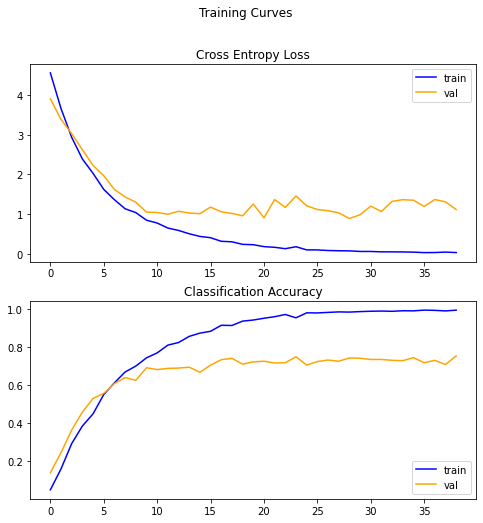


Test set evaluation metrics
10/10 [==============================] - 2s 76ms/step - loss: 3.2970 - accuracy: 0.7586
loss: 3.30
accuracy: 0.76


In [ ]:
model_report(InceptionResNetV2_MODEL_15, InceptionResNetV2_MODEL_history_15, 82)

### Πάγωμα του 30% των επιπέδων

In [ ]:
InceptionResNetV2_MODEL_30 = init_InceptionResNetV2_model(summary = True, trainable = "30")
start_time = time.time()

InceptionResNetV2_MODEL_history_30 = train_model_TL(InceptionResNetV2_MODEL_30,"InceptionResNetV2_30", 82, 50, 30, 5)
duration = time.time() - start_time
print('Training lasted {} seconds'.format(duration))

Model: "sequential_107"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Functio (None, 1, 1, 1536)        54336736  
_________________________________________________________________
dropout_107 (Dropout)        (None, 1, 1, 1536)        0         
_________________________________________________________________
global_average_pooling2d_27  (None, 1536)              0         
_________________________________________________________________
dense_220 (Dense)            (None, 100)               153700    
Total params: 54,490,436
Trainable params: 52,924,756
Non-trainable params: 1,565,680
_________________________________________________________________
Epoch 1/50
30/30 [==============================] - 31s 420ms/step - loss: 4.6964 - accuracy: 0.0482 - val_loss: 3.8087 - val_accuracy: 0.1578
Epoch 2/50
30/30 [==============================] - 7s 238ms/step - loss: 2.9705 - accu

In [ ]:
InceptionResNetV2_MODEL_30.save("/content/drive/My Drive/NN/Ex3/Models/InceptionResNetV2_30_trainable_82x82.h5")

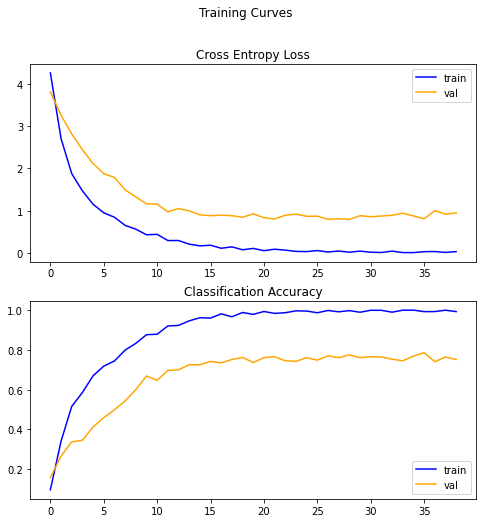


Test set evaluation metrics
10/10 [==============================] - 3s 79ms/step - loss: 0.8692 - accuracy: 0.7594
loss: 0.87
accuracy: 0.76


In [ ]:
model_report(InceptionResNetV2_MODEL_30, InceptionResNetV2_MODEL_history_30, 82)

### Εκπαίδευση μόνο του ανώτερου στρώματος

In [ ]:
InceptionResNetV2_MODEL_top = init_InceptionResNetV2_model(summary = True, trainable = "top")
start_time = time.time()

InceptionResNetV2_MODEL_history_top = train_model_TL(InceptionResNetV2_MODEL_top,"InceptionResNetV2_top", 82, 50, 30, 5)
duration = time.time() - start_time
print('Training lasted {} seconds'.format(duration))

Model: "sequential_108"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Functio (None, 1, 1, 1536)        54336736  
_________________________________________________________________
dropout_108 (Dropout)        (None, 1, 1, 1536)        0         
_________________________________________________________________
global_average_pooling2d_28  (None, 1536)              0         
_________________________________________________________________
dense_221 (Dense)            (None, 100)               153700    
Total params: 54,490,436
Trainable params: 153,700
Non-trainable params: 54,336,736
_________________________________________________________________
Epoch 1/50
30/30 [==============================] - 20s 292ms/step - loss: 6.7230 - accuracy: 0.0178 - val_loss: 4.6915 - val_accuracy: 0.0453
Epoch 2/50
30/30 [==============================] - 4s 131ms/step - loss: 5.7035 - accura

In [ ]:
InceptionResNetV2_MODEL_top.save("/content/drive/My Drive/NN/Ex3/Models/InceptionResNetV2_top_trainable_82x82.h5")

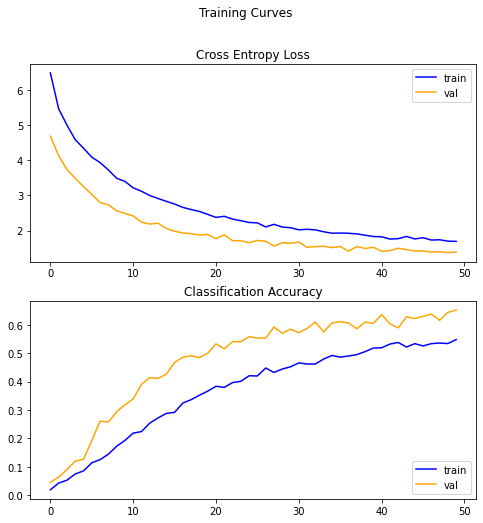


Test set evaluation metrics
10/10 [==============================] - 2s 74ms/step - loss: 1.4801 - accuracy: 0.6055
loss: 1.48
accuracy: 0.61


In [ ]:
model_report(InceptionResNetV2_MODEL_top, InceptionResNetV2_MODEL_history_top, 82)

##  MobileNet

In [ ]:
# transfer learning: MobileNet trained on ImageNet without the top layer

def init_MobileNet_model(summary, trainable):
  MobileNet_MODEL=MobileNet(input_shape=(img_rows, img_cols, img_channels), include_top=False, weights='imagenet')

  if (trainable == "all"):
    # unfreeze conv layers
    MobileNet_MODEL.trainable=True
  elif (trainable == "top"):
    MobileNet_MODEL.trainable=False
  else:
    percentage = float(trainable)/100
    nlayers =  len(MobileNet_MODEL.layers)
    nfreeze = ceil(nlayers*percentage)

    for layer in MobileNet_MODEL.layers[:nfreeze]:
	    layer.trainable = False


  dropout_layer = tf.keras.layers.Dropout(rate = 0.5)
  global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

  # add top layer for CIFAR100 classification
  prediction_layer = tf.keras.layers.Dense(len(CIFAR100_LABELS_LIST),activation='softmax')
  model = tf.keras.Sequential([MobileNet_MODEL, dropout_layer, global_average_layer, prediction_layer])
  model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.00005), loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=["accuracy"])
  if summary: 
    model.summary()
  return model

### Εκπαίδευση όλων των επιπέδων

In [ ]:
MobileNet_MODEL_all = init_MobileNet_model( True, "all")
start_time = time.time()

MobileNet_MODEL_history_all = train_model_TL(MobileNet_MODEL_all, "MobileNet_all", 32, 50, 30, 5)
duration = time.time() - start_time
print('Training lasted {} seconds'.format(duration))

17227776/17225924 [==============================] - 0s 0us/step
Model: "sequential_109"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_224 (Function (None, 1, 1, 1024)        3228864   
_________________________________________________________________
dropout_109 (Dropout)        (None, 1, 1, 1024)        0         
_________________________________________________________________
global_average_pooling2d_29  (None, 1024)              0         
_________________________________________________________________
dense_222 (Dense)            (None, 100)               102500    
Total params: 3,331,364
Trainable params: 3,309,476
Non-trainable params: 21,888
_________________________________________________________________
Epoch 1/50
30/30 [==============================] - 5s 69ms/step - loss: 8.2152 - accuracy: 0.0138 - val_loss: 4.6110 - val_accuracy: 0.0156
Epoch 2/50
30/30 [===========

In [ ]:
MobileNet_MODEL_all.save("/content/drive/My Drive/NN/Ex3/Models/MobileNet_all_trainable_32x32.h5")

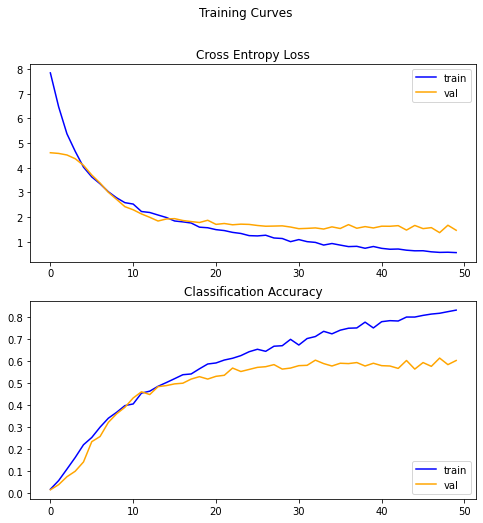


Test set evaluation metrics
10/10 [==============================] - 0s 9ms/step - loss: 1.4614 - accuracy: 0.6148
loss: 1.46
accuracy: 0.61


In [ ]:
model_report(MobileNet_MODEL_all, MobileNet_MODEL_history_all, 32)

### Πάγωμα του 15% των επιπέδων

In [ ]:
MobileNet_MODEL_15 = init_MobileNet_model(summary = True, trainable = "15")
start_time = time.time()

MobileNet_MODEL_history_15 = train_model_TL(MobileNet_MODEL_15,"MobileNet_15", 32, 50, 30, 5)
duration = time.time() - start_time
print('Training lasted {} seconds'.format(duration))

Model: "sequential_110"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_224 (Function (None, 1, 1, 1024)        3228864   
_________________________________________________________________
dropout_110 (Dropout)        (None, 1, 1, 1024)        0         
_________________________________________________________________
global_average_pooling2d_30  (None, 1024)              0         
_________________________________________________________________
dense_223 (Dense)            (None, 100)               102500    
Total params: 3,331,364
Trainable params: 3,305,316
Non-trainable params: 26,048
_________________________________________________________________
Epoch 1/50
30/30 [==============================] - 3s 48ms/step - loss: 8.2598 - accuracy: 0.0093 - val_loss: 4.5811 - val_accuracy: 0.0359
Epoch 2/50
30/30 [==============================] - 1s 20ms/step - loss: 6.8691 - accuracy: 0.

In [ ]:
MobileNet_MODEL_15.save("/content/drive/My Drive/NN/Ex3/Models/MobileNet_15_trainable_32x32.h5")

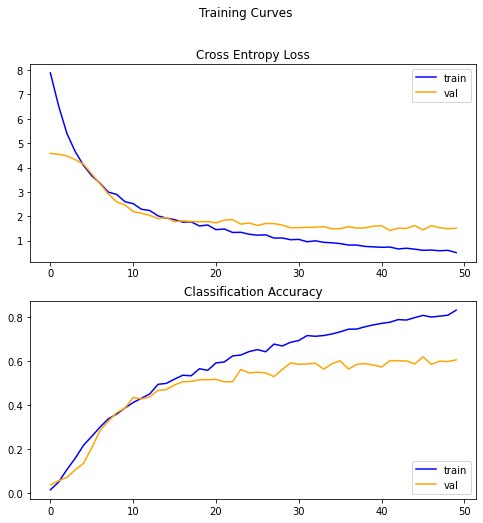


Test set evaluation metrics
10/10 [==============================] - 0s 9ms/step - loss: 1.4658 - accuracy: 0.6109
loss: 1.47
accuracy: 0.61


In [ ]:
model_report(MobileNet_MODEL_15, MobileNet_MODEL_history_15, 32)

### Πάγωμα του 30% των επιπέδων

In [ ]:
MobileNet_MODEL_30 = init_MobileNet_model(summary = True, trainable = "30")
start_time = time.time()

MobileNet_MODEL_history_30 = train_model_TL(MobileNet_MODEL_30,"MobileNet_30", 32, 50, 30, 5)
duration = time.time() - start_time
print('Training lasted {} seconds'.format(duration))

Model: "sequential_111"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_224 (Function (None, 1, 1, 1024)        3228864   
_________________________________________________________________
dropout_111 (Dropout)        (None, 1, 1, 1024)        0         
_________________________________________________________________
global_average_pooling2d_31  (None, 1024)              0         
_________________________________________________________________
dense_224 (Dense)            (None, 100)               102500    
Total params: 3,331,364
Trainable params: 3,277,412
Non-trainable params: 53,952
_________________________________________________________________
Epoch 1/50
30/30 [==============================] - 3s 45ms/step - loss: 8.2954 - accuracy: 0.0104 - val_loss: 4.5863 - val_accuracy: 0.0203
Epoch 2/50
30/30 [==============================] - 1s 18ms/step - loss: 6.9399 - accuracy: 0.

In [ ]:
MobileNet_MODEL_30.save("/content/drive/My Drive/NN/Ex3/Models/MobileNet_30_trainable_32x32.h5")

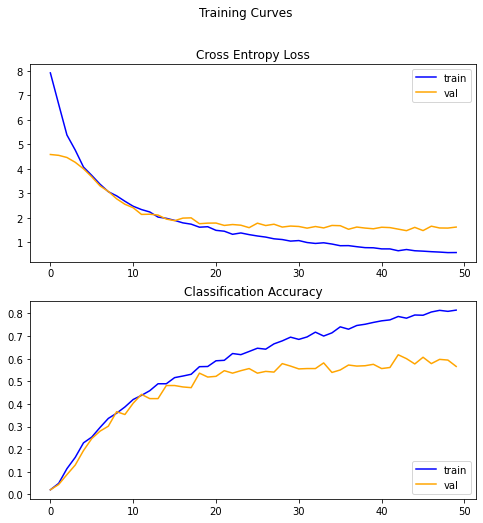


Test set evaluation metrics
10/10 [==============================] - 0s 8ms/step - loss: 1.4150 - accuracy: 0.6305
loss: 1.42
accuracy: 0.63


In [ ]:
model_report(MobileNet_MODEL_30, MobileNet_MODEL_history_30, 32)

### Εκπαίδευση μόνο του ανώτερου στρώματος

In [ ]:
MobileNet_MODEL_top = init_MobileNet_model(summary = True, trainable = "top")
start_time = time.time()

MobileNet_MODEL_history_top = train_model_TL(MobileNet_MODEL_top,"MobileNet_top", 32, 50, 30, 5)
duration = time.time() - start_time
print('Training lasted {} seconds'.format(duration))

Model: "sequential_112"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_224 (Function (None, 1, 1, 1024)        3228864   
_________________________________________________________________
dropout_112 (Dropout)        (None, 1, 1, 1024)        0         
_________________________________________________________________
global_average_pooling2d_32  (None, 1024)              0         
_________________________________________________________________
dense_225 (Dense)            (None, 100)               102500    
Total params: 3,331,364
Trainable params: 102,500
Non-trainable params: 3,228,864
_________________________________________________________________
Epoch 1/50
30/30 [==============================] - 2s 38ms/step - loss: 4.6276 - accuracy: 0.0210 - val_loss: 4.6025 - val_accuracy: 0.0156
Epoch 2/50
30/30 [==============================] - 0s 14ms/step - loss: 4.6174 - accuracy: 0

In [ ]:
MobileNet_MODEL_top.save("/content/drive/My Drive/NN/Ex3/Models/MobileNet_top_trainable_32x32.h5")

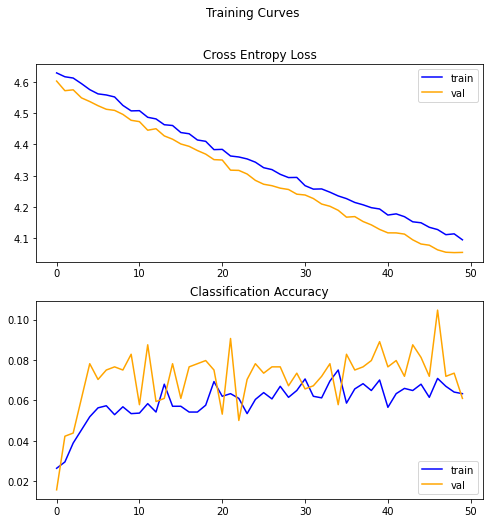


Test set evaluation metrics
10/10 [==============================] - 0s 9ms/step - loss: 4.0667 - accuracy: 0.0820
loss: 4.07
accuracy: 0.08


In [ ]:
model_report(MobileNet_MODEL_top, MobileNet_MODEL_history_top, 32)

##  DenseNet121

In [ ]:
# transfer learning: DenseNet121 trained on ImageNet without the top layer

def init_DenseNet121_model(summary, trainable):
  DenseNet121_MODEL=DenseNet121(input_shape=(img_rows, img_cols, img_channels), include_top=False, weights='imagenet')

  if (trainable == "all"):
    # unfreeze conv layers
    DenseNet121_MODEL.trainable=True
  elif (trainable == "top"):
    DenseNet121_MODEL.trainable=False
  else:
    percentage = float(trainable)/100
    nlayers =  len(DenseNet121_MODEL.layers)
    nfreeze = ceil(nlayers*percentage)

    for layer in DenseNet121_MODEL.layers[:nfreeze]:
	    layer.trainable = False


  dropout_layer = tf.keras.layers.Dropout(rate = 0.5)
  global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

  # add top layer for CIFAR100 classification
  prediction_layer = tf.keras.layers.Dense(len(CIFAR100_LABELS_LIST),activation='softmax')
  model = tf.keras.Sequential([DenseNet121_MODEL, dropout_layer, global_average_layer, prediction_layer])
  model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.00005), loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=["accuracy"])
  if summary: 
    model.summary()
  return model

### Εκπαίδευση όλων των επιπέδων

In [ ]:
DenseNet121_MODEL_all = init_DenseNet121_model( True, "all")
start_time = time.time()

DenseNet121_MODEL_history_all = train_model_TL(DenseNet121_MODEL_all, "DenseNet121_all", 32, 50, 30, 5)
duration = time.time() - start_time
print('Training lasted {} seconds'.format(duration))

29089792/29084464 [==============================] - 0s 0us/step
Model: "sequential_113"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Functional)     (None, 1, 1, 1024)        7037504   
_________________________________________________________________
dropout_113 (Dropout)        (None, 1, 1, 1024)        0         
_________________________________________________________________
global_average_pooling2d_33  (None, 1024)              0         
_________________________________________________________________
dense_226 (Dense)            (None, 100)               102500    
Total params: 7,140,004
Trainable params: 7,056,356
Non-trainable params: 83,648
_________________________________________________________________
Epoch 1/50
30/30 [==============================] - 15s 154ms/step - loss: 6.5497 - accuracy: 0.0071 - val_loss: 4.7987 - val_accuracy: 0.0219
Epoch 2/50
30/30 [=========

In [ ]:
DenseNet121_MODEL_all.save("/content/drive/My Drive/NN/Ex3/Models/DenseNet121_all_trainable_32x32.h5")

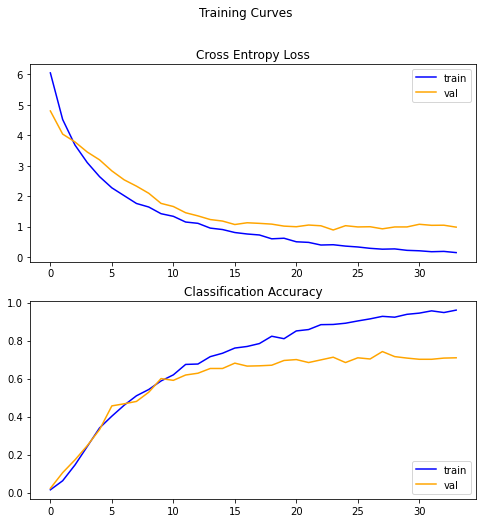


Test set evaluation metrics
10/10 [==============================] - 0s 28ms/step - loss: 1.0310 - accuracy: 0.6891
loss: 1.03
accuracy: 0.69


In [ ]:
model_report(DenseNet121_MODEL_all, DenseNet121_MODEL_history_all, 32)

### Πάγωμα του 15% των επιπέδων

In [ ]:
DenseNet121_MODEL_15 = init_DenseNet121_model(summary = True, trainable = "15")
start_time = time.time()

DenseNet121_MODEL_history_15 = train_model_TL(DenseNet121_MODEL_15,"DenseNet121_15", 32, 50, 30, 5)
duration = time.time() - start_time
print('Training lasted {} seconds'.format(duration))

Model: "sequential_114"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Functional)     (None, 1, 1, 1024)        7037504   
_________________________________________________________________
dropout_114 (Dropout)        (None, 1, 1, 1024)        0         
_________________________________________________________________
global_average_pooling2d_34  (None, 1024)              0         
_________________________________________________________________
dense_227 (Dense)            (None, 100)               102500    
Total params: 7,140,004
Trainable params: 6,603,684
Non-trainable params: 536,320
_________________________________________________________________
Epoch 1/50
30/30 [==============================] - 15s 147ms/step - loss: 5.9554 - accuracy: 0.0271 - val_loss: 4.3560 - val_accuracy: 0.0641
Epoch 2/50
30/30 [==============================] - 1s 49ms/step - loss: 4.5247 - accuracy:

In [ ]:
DenseNet121_MODEL_15.save("/content/drive/My Drive/NN/Ex3/Models/DenseNet121_15_trainable_32x32.h5")

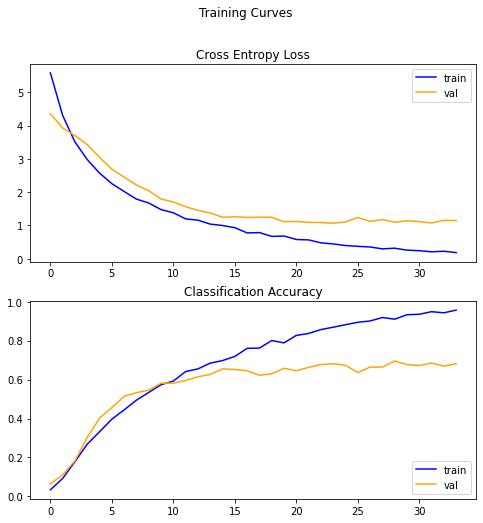


Test set evaluation metrics
10/10 [==============================] - 0s 28ms/step - loss: 1.0689 - accuracy: 0.6836
loss: 1.07
accuracy: 0.68


In [ ]:
model_report(DenseNet121_MODEL_15, DenseNet121_MODEL_history_15, 32)

### Πάγωμα του 30% των επιπέδων

In [ ]:
DenseNet121_MODEL_30 = init_DenseNet121_model(summary = True, trainable = "30")
start_time = time.time()

DenseNet121_MODEL_history_30 = train_model_TL(DenseNet121_MODEL_30,"DenseNet121_30", 32, 50, 30, 5)
duration = time.time() - start_time
print('Training lasted {} seconds'.format(duration))

Model: "sequential_115"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Functional)     (None, 1, 1, 1024)        7037504   
_________________________________________________________________
dropout_115 (Dropout)        (None, 1, 1, 1024)        0         
_________________________________________________________________
global_average_pooling2d_35  (None, 1024)              0         
_________________________________________________________________
dense_228 (Dense)            (None, 100)               102500    
Total params: 7,140,004
Trainable params: 5,858,340
Non-trainable params: 1,281,664
_________________________________________________________________
Epoch 1/50
30/30 [==============================] - 12s 140ms/step - loss: 6.1358 - accuracy: 0.0167 - val_loss: 4.1318 - val_accuracy: 0.0812
Epoch 2/50
30/30 [==============================] - 1s 44ms/step - loss: 4.6244 - accurac

In [ ]:
DenseNet121_MODEL_30.save("/content/drive/My Drive/NN/Ex3/Models/DenseNet121_30_trainable_32x32.h5")

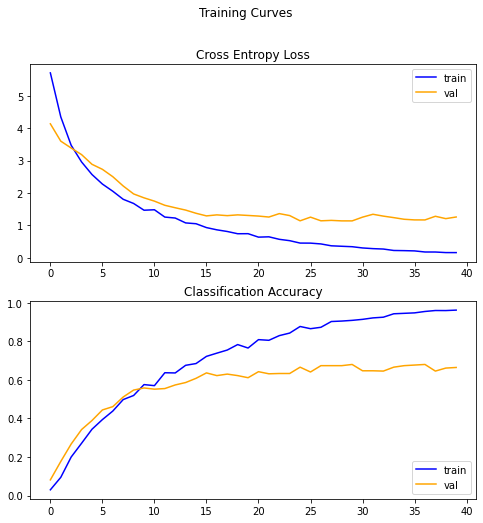


Test set evaluation metrics
10/10 [==============================] - 0s 28ms/step - loss: 1.1852 - accuracy: 0.6570
loss: 1.19
accuracy: 0.66


In [ ]:
model_report(DenseNet121_MODEL_30, DenseNet121_MODEL_history_30, 32)

### Εκπαίδευση μόνο του ανώτερου στρώματος

In [ ]:
DenseNet121_MODEL_top = init_DenseNet121_model(summary = True, trainable = "top")
start_time = time.time()

DenseNet121_MODEL_history_top = train_model_TL(DenseNet121_MODEL_top,"DenseNet121_top", 32, 50, 30, 5)
duration = time.time() - start_time
print('Training lasted {} seconds'.format(duration))

Model: "sequential_116"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Functional)     (None, 1, 1, 1024)        7037504   
_________________________________________________________________
dropout_116 (Dropout)        (None, 1, 1, 1024)        0         
_________________________________________________________________
global_average_pooling2d_36  (None, 1024)              0         
_________________________________________________________________
dense_229 (Dense)            (None, 100)               102500    
Total params: 7,140,004
Trainable params: 102,500
Non-trainable params: 7,037,504
_________________________________________________________________
Epoch 1/50
30/30 [==============================] - 9s 108ms/step - loss: 6.2970 - accuracy: 0.0129 - val_loss: 4.8754 - val_accuracy: 0.0391
Epoch 2/50
30/30 [==============================] - 1s 27ms/step - loss: 5.7036 - accuracy: 

In [ ]:
DenseNet121_MODEL_top.save("/content/drive/My Drive/NN/Ex3/Models/DenseNet121_top_trainable_32x32.h5")

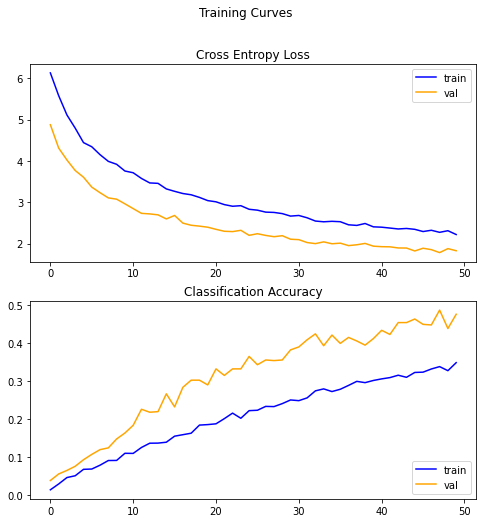


Test set evaluation metrics
10/10 [==============================] - 0s 28ms/step - loss: 1.7337 - accuracy: 0.4680
loss: 1.73
accuracy: 0.47


In [ ]:
model_report(DenseNet121_MODEL_top, DenseNet121_MODEL_history_top, 32)

##  EfficientNetB0

In [ ]:
pip install tf-nightly

     |████████████████████████████████| 409.1MB 46kB/s 
     |████████████████████████████████| 5.9MB 30.8MB/s 
     |████████████████████████████████| 4.0MB 41.5MB/s 
     |████████████████████████████████| 4.0MB 42.8MB/s 
     |████████████████████████████████| 471kB 56.9MB/s 
     |████████████████████████████████| 3.8MB 58.5MB/s 
ERROR: tensorflow 2.4.1 has requirement gast==0.3.3, but you'll have gast 0.4.0 which is incompatible.
ERROR: tensorflow 2.4.1 has requirement grpcio~=1.32.0, but you'll have grpcio 1.34.1 which is incompatible.
ERROR: tensorflow 2.4.1 has requirement h5py~=2.10.0, but you'll have h5py 3.1.0 which is incompatible.
  Found existing installation: grpcio 1.32.0
    Uninstalling grpcio-1.32.0:
      Successfully uninstalled grpcio-1.32.0
  Found existing installation: gast 0.3.3
    Uninstalling gast-0.3.3:
      Successfully uninstalled gast-0.3.3
  Found existing installation: h5py 2.10.0
    Uninstalling h5py-2.10.0:
      Successfully uninstalled h5py-2.10

In [ ]:
# transfer learning: EfficientNetB0 trained on ImageNet without the top layer

def init_EfficientNetB0_model(summary, trainable):
  EfficientNetB0_MODEL=EfficientNetB0(input_shape=(img_rows, img_cols, img_channels), include_top=False, weights='imagenet')

  if (trainable == "all"):
    # unfreeze conv layers
    EfficientNetB0_MODEL.trainable=True
  elif (trainable == "top"):
    EfficientNetB0_MODEL.trainable=False
  else:
    percentage = float(trainable)/100
    nlayers =  len(EfficientNetB0_MODEL.layers)
    nfreeze = ceil(nlayers*percentage)

    for layer in EfficientNetB0_MODEL.layers[:nfreeze]:
	    layer.trainable = False


  dropout_layer = tf.keras.layers.Dropout(rate = 0.5)
  global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

  # add top layer for CIFAR100 classification
  prediction_layer = tf.keras.layers.Dense(len(CIFAR100_LABELS_LIST),activation='softmax')
  model = tf.keras.Sequential([EfficientNetB0_MODEL, dropout_layer, global_average_layer, prediction_layer])
  model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.00005), loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=["accuracy"])
  if summary: 
    model.summary()
  return model

### Εκπαίδευση όλων των επιπέδων

In [ ]:
EfficientNetB0_MODEL_all = init_EfficientNetB0_model(True, "all")
start_time = time.time()

EfficientNetB0_MODEL_history_all = train_model_TL(EfficientNetB0_MODEL_all, "EfficientNetB0_all", 32, 50, 30, 5)
duration = time.time() - start_time
print('Training lasted {} seconds'.format(duration))

16711680/16705208 [==============================] - 0s 0us/step
Model: "sequential_117"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb0 (Functional)  (None, 1, 1, 1280)        4049571   
_________________________________________________________________
dropout_117 (Dropout)        (None, 1, 1, 1280)        0         
_________________________________________________________________
global_average_pooling2d_37  (None, 1280)              0         
_________________________________________________________________
dense_230 (Dense)            (None, 100)               128100    
Total params: 4,177,671
Trainable params: 4,135,648
Non-trainable params: 42,023
_________________________________________________________________
Epoch 1/50
30/30 [==============================] - 11s 126ms/step - loss: 5.4945 - accuracy: 0.0105 - val_loss: 4.7912 - val_accuracy: 0.0000e+00
Epoch 2/50
30/30 [=====

In [ ]:
EfficientNetB0_MODEL_all.save("/content/drive/My Drive/NN/Ex3/Models/EfficientNetB0_all_trainable_32x32.h5")

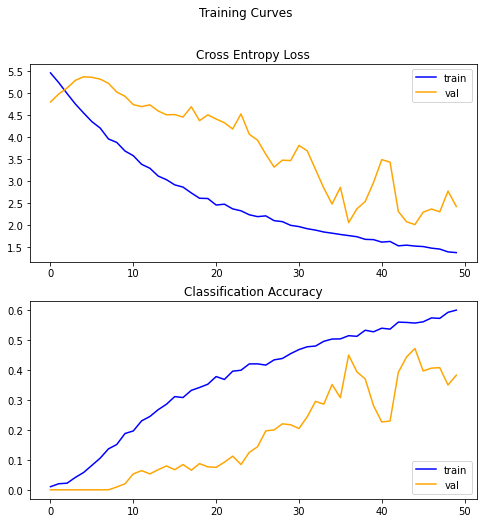


Test set evaluation metrics
10/10 [==============================] - 0s 25ms/step - loss: 2.3692 - accuracy: 0.4078
loss: 2.37
accuracy: 0.41


In [ ]:
model_report(EfficientNetB0_MODEL_all, EfficientNetB0_MODEL_history_all, 32)

### Πάγωμα του 15% των επιπέδων

In [ ]:
EfficientNetB0_MODEL_15 = init_EfficientNetB0_model(summary = True, trainable = "15")
start_time = time.time()

EfficientNetB0_MODEL_history_15 = train_model_TL(EfficientNetB0_MODEL_15,"EfficientNetB0_15", 32, 50, 30, 5)
duration = time.time() - start_time
print('Training lasted {} seconds'.format(duration))

Model: "sequential_118"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb0 (Functional)  (None, 1, 1, 1280)        4049571   
_________________________________________________________________
dropout_118 (Dropout)        (None, 1, 1, 1280)        0         
_________________________________________________________________
global_average_pooling2d_38  (None, 1280)              0         
_________________________________________________________________
dense_231 (Dense)            (None, 100)               128100    
Total params: 4,177,671
Trainable params: 4,121,940
Non-trainable params: 55,731
_________________________________________________________________
Epoch 1/50
30/30 [==============================] - 10s 116ms/step - loss: 5.6438 - accuracy: 0.0075 - val_loss: 4.7660 - val_accuracy: 0.0000e+00
Epoch 2/50
30/30 [==============================] - 1s 42ms/step - loss: 5.3373 - accura

In [ ]:
EfficientNetB0_MODEL_15.save("/content/drive/My Drive/NN/Ex3/Models/EfficientNetB0_15_trainable_32x32.h5")

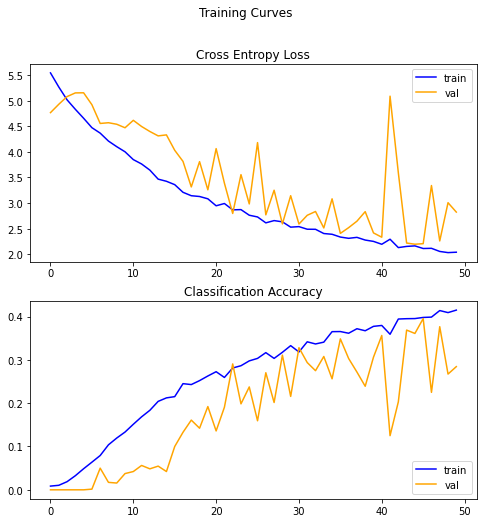


Test set evaluation metrics
10/10 [==============================] - 0s 23ms/step - loss: 2.7196 - accuracy: 0.3141
loss: 2.72
accuracy: 0.31


In [ ]:
model_report(EfficientNetB0_MODEL_15, EfficientNetB0_MODEL_history_15, 32)

### Πάγωμα του 30% των επιπέδων

In [ ]:
EfficientNetB0_MODEL_30 = init_EfficientNetB0_model(summary = True, trainable = "30")
start_time = time.time()

EfficientNetB0_MODEL_history_30 = train_model_TL(EfficientNetB0_MODEL_30,"EfficientNetB0_30", 32, 50, 30, 5)
duration = time.time() - start_time
print('Training lasted {} seconds'.format(duration))

Model: "sequential_119"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb0 (Functional)  (None, 1, 1, 1280)        4049571   
_________________________________________________________________
dropout_119 (Dropout)        (None, 1, 1, 1280)        0         
_________________________________________________________________
global_average_pooling2d_39  (None, 1280)              0         
_________________________________________________________________
dense_232 (Dense)            (None, 100)               128100    
Total params: 4,177,671
Trainable params: 4,069,998
Non-trainable params: 107,673
_________________________________________________________________
Epoch 1/50
30/30 [==============================] - 10s 110ms/step - loss: 5.3261 - accuracy: 0.0104 - val_loss: 4.6181 - val_accuracy: 0.0000e+00
Epoch 2/50
30/30 [==============================] - 1s 41ms/step - loss: 5.0369 - accur

In [ ]:
EfficientNetB0_MODEL_30.save("/content/drive/My Drive/NN/Ex3/Models/EfficientNetB0_30_trainable_32x32.h5")

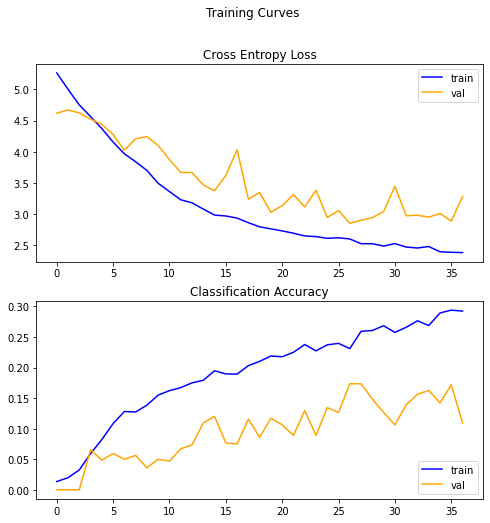


Test set evaluation metrics
10/10 [==============================] - 0s 26ms/step - loss: 2.8291 - accuracy: 0.1516
loss: 2.83
accuracy: 0.15


In [ ]:
model_report(EfficientNetB0_MODEL_30, EfficientNetB0_MODEL_history_30, 32)

### Εκπαίδευση μόνο του ανώτερου στρώματος

In [ ]:
EfficientNetB0_MODEL_top = init_EfficientNetB0_model(summary = True, trainable = "top")
start_time = time.time()

EfficientNetB0_MODEL_history_top = train_model_TL(EfficientNetB0_MODEL_top,"EfficientNetB0_top", 32, 50, 30, 5)
duration = time.time() - start_time
print('Training lasted {} seconds'.format(duration))

Model: "sequential_120"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb0 (Functional)  (None, 1, 1, 1280)        4049571   
_________________________________________________________________
dropout_120 (Dropout)        (None, 1, 1, 1280)        0         
_________________________________________________________________
global_average_pooling2d_40  (None, 1280)              0         
_________________________________________________________________
dense_233 (Dense)            (None, 100)               128100    
Total params: 4,177,671
Trainable params: 128,100
Non-trainable params: 4,049,571
_________________________________________________________________
Epoch 1/50
30/30 [==============================] - 7s 87ms/step - loss: 4.6399 - accuracy: 0.0110 - val_loss: 4.1976 - val_accuracy: 0.0547
Epoch 2/50
30/30 [==============================] - 1s 25ms/step - loss: 4.1481 - accuracy: 0

In [ ]:
EfficientNetB0_MODEL_top.save("/content/drive/My Drive/NN/Ex3/Models/EfficientNetB0_top_trainable_32x32.h5")

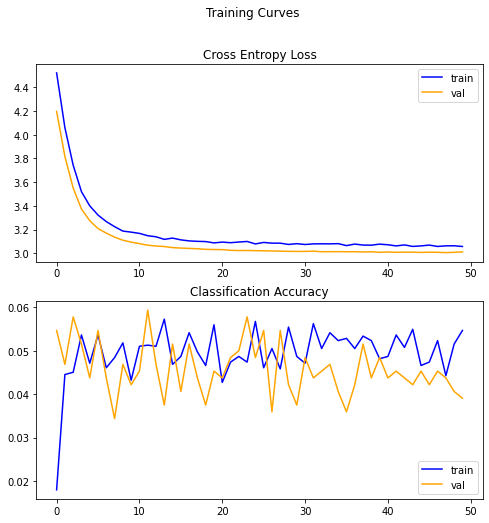


Test set evaluation metrics
10/10 [==============================] - 0s 15ms/step - loss: 3.0027 - accuracy: 0.0500
loss: 3.00
accuracy: 0.05


In [ ]:
model_report(EfficientNetB0_MODEL_top, EfficientNetB0_MODEL_history_top, 32)

##  EfficientNetB4

In [ ]:
# transfer learning: EfficientNetB4 trained on ImageNet without the top layer

def init_EfficientNetB4_model(summary, trainable):
  EfficientNetB4_MODEL=EfficientNetB4(input_shape=(img_rows, img_cols, img_channels), include_top=False, weights='imagenet')

  if (trainable == "all"):
    # unfreeze conv layers
    EfficientNetB4_MODEL.trainable=True
  elif (trainable == "top"):
    EfficientNetB4_MODEL.trainable=False
  else:
    percentage = float(trainable)/100
    nlayers =  len(EfficientNetB4_MODEL.layers)
    nfreeze = ceil(nlayers*percentage)

    for layer in EfficientNetB4_MODEL.layers[:nfreeze]:
	    layer.trainable = False


  dropout_layer = tf.keras.layers.Dropout(rate = 0.5)
  global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

  # add top layer for CIFAR100 classification
  prediction_layer = tf.keras.layers.Dense(len(CIFAR100_LABELS_LIST),activation='softmax')
  model = tf.keras.Sequential([EfficientNetB4_MODEL, dropout_layer, global_average_layer, prediction_layer])
  model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.00005), loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=["accuracy"])
  if summary: 
    model.summary()
  return model

### Εκπαίδευση όλων των επιπέδων

In [ ]:
EfficientNetB4_MODEL_all = init_EfficientNetB4_model( True, "all")
start_time = time.time()

EfficientNetB4_MODEL_history_all = train_model_TL(EfficientNetB4_MODEL_all, "EfficientNetB4_all", 32, 50, 30, 5)
duration = time.time() - start_time
print('Training lasted {} seconds'.format(duration))

71688192/71686520 [==============================] - 1s 0us/step
Model: "sequential_121"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb4 (Functional)  (None, 1, 1, 1792)        17673823  
_________________________________________________________________
dropout_121 (Dropout)        (None, 1, 1, 1792)        0         
_________________________________________________________________
global_average_pooling2d_41  (None, 1792)              0         
_________________________________________________________________
dense_234 (Dense)            (None, 100)               179300    
Total params: 17,853,123
Trainable params: 17,727,916
Non-trainable params: 125,207
_________________________________________________________________
Epoch 1/50
30/30 [==============================] - 23s 253ms/step - loss: 4.9469 - accuracy: 0.0143 - val_loss: 4.4580 - val_accuracy: 0.0547
Epoch 2/50
30/30 [======

In [ ]:
EfficientNetB4_MODEL_all.save("/content/drive/My Drive/NN/Ex3/Models/EfficientNetB4_all_trainable_32x32.h5")

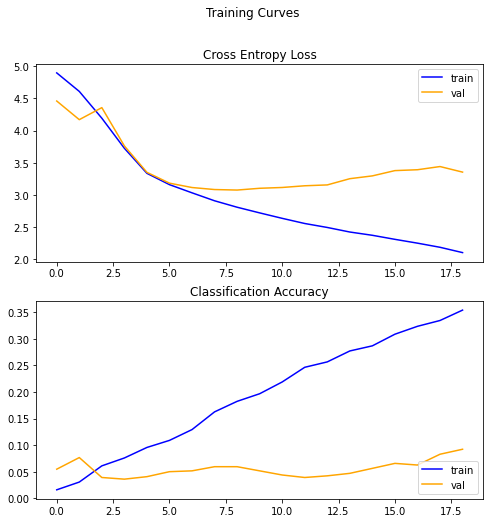


Test set evaluation metrics
10/10 [==============================] - 1s 45ms/step - loss: 3.0779 - accuracy: 0.0625
loss: 3.08
accuracy: 0.06


In [ ]:
model_report(EfficientNetB4_MODEL_all, EfficientNetB4_MODEL_history_all, 32)

### Πάγωμα του 15% των επιπέδων

In [ ]:
EfficientNetB4_MODEL_15 = init_EfficientNetB4_model(summary = True, trainable = "15")
start_time = time.time()

EfficientNetB4_MODEL_history_15 = train_model_TL(EfficientNetB4_MODEL_15,"EfficientNetB4_15", 32, 50, 30, 5)
duration = time.time() - start_time
print('Training lasted {} seconds'.format(duration))

Model: "sequential_122"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb4 (Functional)  (None, 1, 1, 1792)        17673823  
_________________________________________________________________
dropout_122 (Dropout)        (None, 1, 1, 1792)        0         
_________________________________________________________________
global_average_pooling2d_42  (None, 1792)              0         
_________________________________________________________________
dense_235 (Dense)            (None, 100)               179300    
Total params: 17,853,123
Trainable params: 17,674,260
Non-trainable params: 178,863
_________________________________________________________________
Epoch 1/50
30/30 [==============================] - 21s 239ms/step - loss: 4.9685 - accuracy: 0.0110 - val_loss: 4.5774 - val_accuracy: 0.0500
Epoch 2/50
30/30 [==============================] - 3s 95ms/step - loss: 4.5750 - accurac

In [ ]:
EfficientNetB4_MODEL_15.save("/content/drive/My Drive/NN/Ex3/Models/EfficientNetB4_15_trainable_32x32.h5")

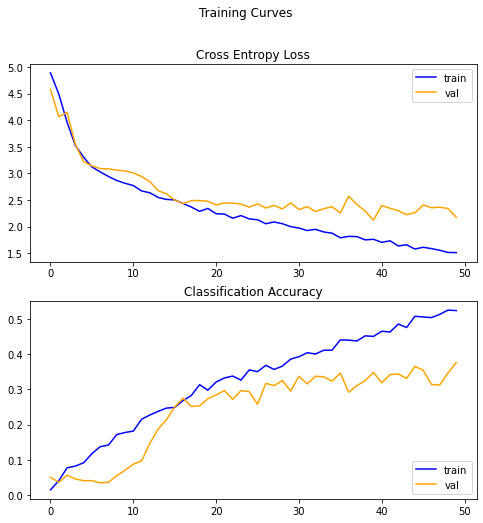


Test set evaluation metrics
10/10 [==============================] - 1s 46ms/step - loss: 2.1477 - accuracy: 0.3570
loss: 2.15
accuracy: 0.36


In [ ]:
model_report(EfficientNetB4_MODEL_15, EfficientNetB4_MODEL_history_15, 32)

### Πάγωμα του 30% των επιπέδων

In [ ]:
EfficientNetB4_MODEL_30 = init_EfficientNetB4_model(summary = True, trainable = "30")
start_time = time.time()

EfficientNetB4_MODEL_history_30 = train_model_TL(EfficientNetB4_MODEL_30,"EfficientNetB4_30", 32, 50, 30, 5)
duration = time.time() - start_time
print('Training lasted {} seconds'.format(duration))

Model: "sequential_123"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb4 (Functional)  (None, 1, 1, 1792)        17673823  
_________________________________________________________________
dropout_123 (Dropout)        (None, 1, 1, 1792)        0         
_________________________________________________________________
global_average_pooling2d_43  (None, 1792)              0         
_________________________________________________________________
dense_236 (Dense)            (None, 100)               179300    
Total params: 17,853,123
Trainable params: 17,477,482
Non-trainable params: 375,641
_________________________________________________________________
Epoch 1/50
30/30 [==============================] - 23s 225ms/step - loss: 4.8208 - accuracy: 0.0096 - val_loss: 4.1739 - val_accuracy: 0.0562
Epoch 2/50
30/30 [==============================] - 3s 86ms/step - loss: 4.2472 - accurac

In [ ]:
EfficientNetB4_MODEL_30.save("/content/drive/My Drive/NN/Ex3/Models/EfficientNetB4_30_trainable_32x32.h5")

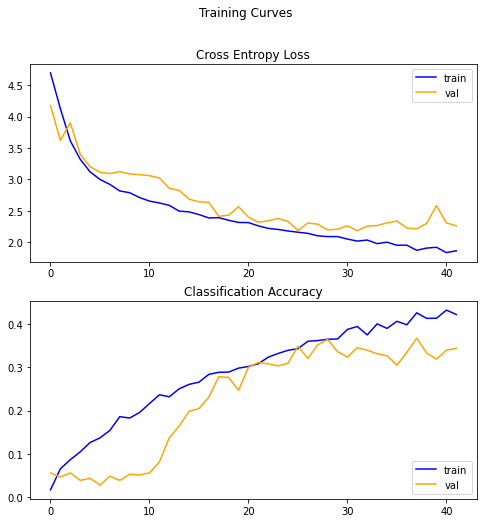


Test set evaluation metrics
10/10 [==============================] - 1s 43ms/step - loss: 2.1259 - accuracy: 0.3539
loss: 2.13
accuracy: 0.35


In [ ]:
model_report(EfficientNetB4_MODEL_30, EfficientNetB4_MODEL_history_30, 32)

### Εκπαίδευση μόνο του ανώτερου στρώματος

In [ ]:
EfficientNetB4_MODEL_top = init_EfficientNetB4_model(summary = True, trainable = "top")
start_time = time.time()

EfficientNetB4_MODEL_history_top = train_model_TL(EfficientNetB4_MODEL_top,"EfficientNetB4_top", 32, 50, 30, 5)
duration = time.time() - start_time
print('Training lasted {} seconds'.format(duration))

Model: "sequential_124"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb4 (Functional)  (None, 1, 1, 1792)        17673823  
_________________________________________________________________
dropout_124 (Dropout)        (None, 1, 1, 1792)        0         
_________________________________________________________________
global_average_pooling2d_44  (None, 1792)              0         
_________________________________________________________________
dense_237 (Dense)            (None, 100)               179300    
Total params: 17,853,123
Trainable params: 179,300
Non-trainable params: 17,673,823
_________________________________________________________________
Epoch 1/50
30/30 [==============================] - 15s 172ms/step - loss: 4.5903 - accuracy: 0.0144 - val_loss: 3.9072 - val_accuracy: 0.0547
Epoch 2/50
30/30 [==============================] - 2s 52ms/step - loss: 3.9052 - accurac

In [ ]:
EfficientNetB4_MODEL_top.save("/content/drive/My Drive/NN/Ex3/Models/EfficientNetB4_top_trainable_32x32.h5")

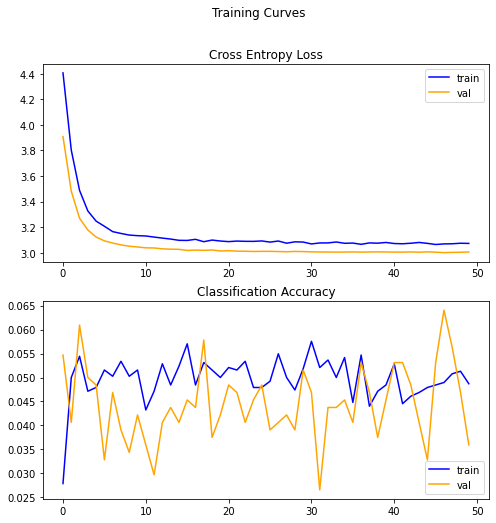


Test set evaluation metrics
10/10 [==============================] - 1s 45ms/step - loss: 2.9999 - accuracy: 0.0508
loss: 3.00
accuracy: 0.05


In [ ]:
model_report(EfficientNetB4_MODEL_top, EfficientNetB4_MODEL_history_top, 32)

##  EfficientNetB7

In [ ]:
# transfer learning: EfficientNetB7 trained on ImageNet without the top layer

def init_EfficientNetB7_model(summary, trainable):
  EfficientNetB7_MODEL=EfficientNetB7(input_shape=(img_rows, img_cols, img_channels), include_top=False, weights='imagenet')

  if (trainable == "all"):
    # unfreeze conv layers
    EfficientNetB7_MODEL.trainable=True
  elif (trainable == "top"):
    EfficientNetB7_MODEL.trainable=False
  else:
    percentage = float(trainable)/100
    nlayers =  len(EfficientNetB7_MODEL.layers)
    nfreeze = ceil(nlayers*percentage)

    for layer in EfficientNetB7_MODEL.layers[:nfreeze]:
	    layer.trainable = False


  dropout_layer = tf.keras.layers.Dropout(rate = 0.5)
  global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

  # add top layer for CIFAR100 classification
  prediction_layer = tf.keras.layers.Dense(len(CIFAR100_LABELS_LIST),activation='softmax')
  model = tf.keras.Sequential([EfficientNetB7_MODEL, dropout_layer, global_average_layer, prediction_layer])
  model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.00005), loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=["accuracy"])
  if summary: 
    model.summary()
  return model

### Εκπαίδευση όλων των επιπέδων

In [ ]:
EfficientNetB7_MODEL_all = init_EfficientNetB7_model( True, "all")
start_time = time.time()

EfficientNetB7_MODEL_history_all = train_model_TL(EfficientNetB7_MODEL_all, "EfficientNetB7_all", 32, 50, 30, 5)
duration = time.time() - start_time
print('Training lasted {} seconds'.format(duration))

258080768/258076736 [==============================] - 2s 0us/step
Model: "sequential_125"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb7 (Functional)  (None, 1, 1, 2560)        64097687  
_________________________________________________________________
dropout_125 (Dropout)        (None, 1, 1, 2560)        0         
_________________________________________________________________
global_average_pooling2d_45  (None, 2560)              0         
_________________________________________________________________
dense_238 (Dense)            (None, 100)               256100    
Total params: 64,353,787
Trainable params: 64,043,060
Non-trainable params: 310,727
_________________________________________________________________
Epoch 1/50
30/30 [==============================] - 40s 484ms/step - loss: 4.9664 - accuracy: 0.0131 - val_loss: 9.2480 - val_accuracy: 0.0000e+00
Epoch 2/50
30/30 [

In [ ]:
EfficientNetB7_MODEL_all.save("/content/drive/My Drive/NN/Ex3/Models/EfficientNetB7_all_trainable_32x32.h5")

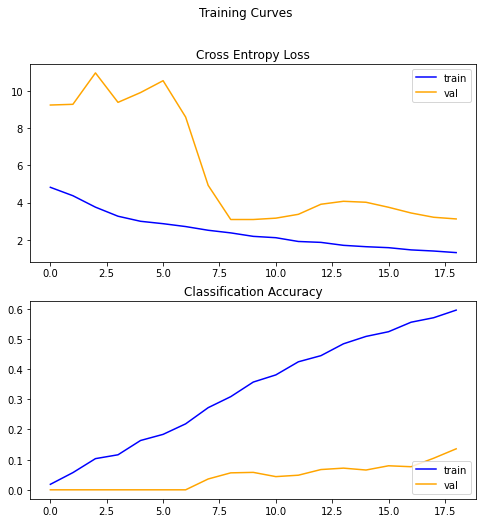


Test set evaluation metrics
10/10 [==============================] - 1s 88ms/step - loss: 3.1186 - accuracy: 0.0453
loss: 3.12
accuracy: 0.05


In [ ]:
model_report(EfficientNetB7_MODEL_all, EfficientNetB7_MODEL_history_all, 32)

### Πάγωμα του 15% των επιπέδων

In [ ]:
EfficientNetB7_MODEL_15 = init_EfficientNetB7_model(summary = True, trainable = "15")
start_time = time.time()

EfficientNetB7_MODEL_history_15 = train_model_TL(EfficientNetB7_MODEL_15,"EfficientNetB7_15", 32, 50, 30, 5)
duration = time.time() - start_time
print('Training lasted {} seconds'.format(duration))

Model: "sequential_126"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb7 (Functional)  (None, 1, 1, 2560)        64097687  
_________________________________________________________________
dropout_126 (Dropout)        (None, 1, 1, 2560)        0         
_________________________________________________________________
global_average_pooling2d_46  (None, 2560)              0         
_________________________________________________________________
dense_239 (Dense)            (None, 100)               256100    
Total params: 64,353,787
Trainable params: 63,868,180
Non-trainable params: 485,607
_________________________________________________________________
Epoch 1/50
30/30 [==============================] - 43s 452ms/step - loss: 4.9735 - accuracy: 0.0106 - val_loss: 10.8665 - val_accuracy: 0.0000e+00
Epoch 2/50
30/30 [==============================] - 6s 205ms/step - loss: 4.4060 - a

In [ ]:
EfficientNetB7_MODEL_15.save("/content/drive/My Drive/NN/Ex3/Models/EfficientNetB7_15_trainable_32x32.h5")

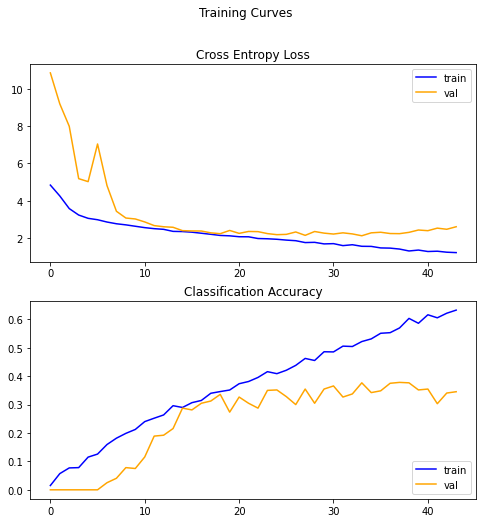


Test set evaluation metrics
10/10 [==============================] - 1s 84ms/step - loss: 2.1278 - accuracy: 0.3609
loss: 2.13
accuracy: 0.36


In [ ]:
model_report(EfficientNetB7_MODEL_15, EfficientNetB7_MODEL_history_15, 32)

### Πάγωμα του 30% των επιπέδων

In [ ]:
EfficientNetB7_MODEL_30 = init_EfficientNetB7_model(summary = True, trainable = "30")
start_time = time.time()

EfficientNetB7_MODEL_history_30 = train_model_TL(EfficientNetB7_MODEL_30,"EfficientNetB7_30", 32, 50, 30, 5)
duration = time.time() - start_time
print('Training lasted {} seconds'.format(duration))

Model: "sequential_127"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb7 (Functional)  (None, 1, 1, 2560)        64097687  
_________________________________________________________________
dropout_127 (Dropout)        (None, 1, 1, 2560)        0         
_________________________________________________________________
global_average_pooling2d_47  (None, 2560)              0         
_________________________________________________________________
dense_240 (Dense)            (None, 100)               256100    
Total params: 64,353,787
Trainable params: 63,171,372
Non-trainable params: 1,182,415
_________________________________________________________________
Epoch 1/50
30/30 [==============================] - 39s 439ms/step - loss: 4.8545 - accuracy: 0.0153 - val_loss: 12.1894 - val_accuracy: 0.0000e+00
Epoch 2/50
30/30 [==============================] - 6s 184ms/step - loss: 4.1992 -

In [ ]:
EfficientNetB7_MODEL_30.save("/content/drive/My Drive/NN/Ex3/Models/EfficientNetB7_30_trainable_32x32.h5")

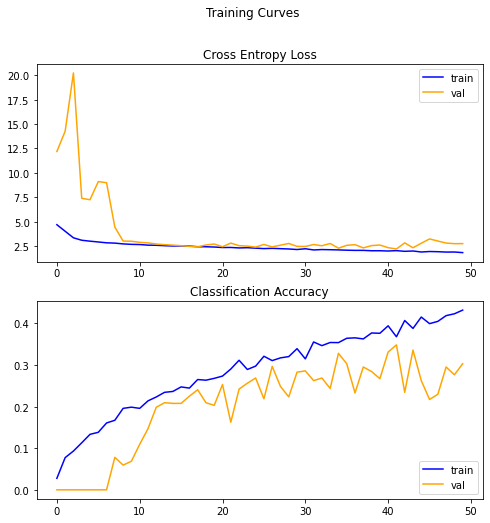


Test set evaluation metrics
10/10 [==============================] - 1s 88ms/step - loss: 2.6760 - accuracy: 0.3039
loss: 2.68
accuracy: 0.30


In [ ]:
model_report(EfficientNetB7_MODEL_30, EfficientNetB7_MODEL_history_30, 32)

### Εκπαίδευση μόνο του ανώτερου στρώματος

In [ ]:
EfficientNetB7_MODEL_top = init_EfficientNetB7_model(summary = True, trainable = "top")
start_time = time.time()

EfficientNetB7_MODEL_history_top = train_model_TL(EfficientNetB7_MODEL_top,"EfficientNetB7_top", 32, 50, 30, 5)
duration = time.time() - start_time
print('Training lasted {} seconds'.format(duration))

Model: "sequential_128"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb7 (Functional)  (None, 1, 1, 2560)        64097687  
_________________________________________________________________
dropout_128 (Dropout)        (None, 1, 1, 2560)        0         
_________________________________________________________________
global_average_pooling2d_48  (None, 2560)              0         
_________________________________________________________________
dense_241 (Dense)            (None, 100)               256100    
Total params: 64,353,787
Trainable params: 256,100
Non-trainable params: 64,097,687
_________________________________________________________________
Epoch 1/50
30/30 [==============================] - 26s 312ms/step - loss: 14.2679 - accuracy: 0.0208 - val_loss: 3.6326 - val_accuracy: 0.0375
Epoch 2/50
30/30 [==============================] - 3s 111ms/step - loss: 9.3153 - accur

In [ ]:
EfficientNetB7_MODEL_top.save("/content/drive/My Drive/NN/Ex3/Models/EfficientNetB7_top_trainable_32x32.h5")

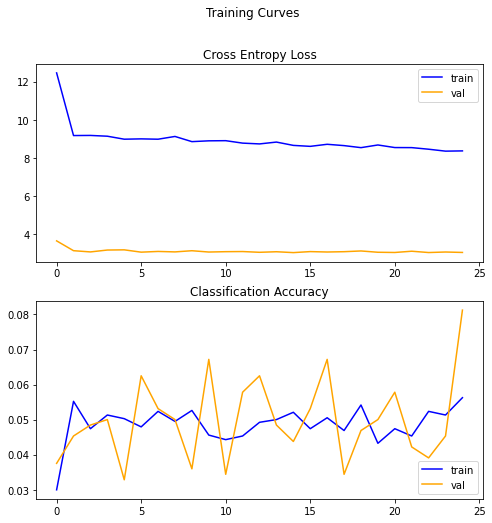


Test set evaluation metrics
10/10 [==============================] - 1s 84ms/step - loss: 3.0321 - accuracy: 0.0508
loss: 3.03
accuracy: 0.05


In [ ]:
model_report(EfficientNetB7_MODEL_top, EfficientNetB7_MODEL_history_top, 32)